##1. DATA COLLECTION

In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm #untuk OLS
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix #untuk roc curve
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from numpy import log

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_store = pd.read_csv('/content/drive/MyDrive/HandsOnIndonesiaAI/Project_1/store5.csv')
df_store

Mounted at /content/drive


id        date  store_nbr                      family     sales  \
0         1452  2013-01-01          5                  AUTOMOTIVE     0.000   
1         1453  2013-01-01          5                   BABY CARE     0.000   
2         1454  2013-01-01          5                      BEAUTY     0.000   
3         1455  2013-01-01          5                   BEVERAGES     0.000   
4         1456  2013-01-01          5                       BOOKS     0.000   
...        ...         ...        ...                         ...       ...   
55567  3000586  2017-08-15          5                     POULTRY   241.011   
55568  3000587  2017-08-15          5              PREPARED FOODS    52.121   
55569  3000588  2017-08-15          5                     PRODUCE  1357.823   
55570  3000589  2017-08-15          5  SCHOOL AND OFFICE SUPPLIES     0.000   
55571  3000590  2017-08-15          5                     SEAFOOD     9.669   

       onpromotion  dcoilwtico  
0                0         NaN  
1                0         NaN  
2                0         NaN  
3                0         NaN  
4                0         NaN  
...            ...         ...  
55567            1       47.57  
55568            0       47.57  
55569            4       47.57  
55570            0       47.57  
55571            0       47.57  

[55572 rows x 7 columns]

##2. DATA PREPARATION

In [ ]:
df_store_prep = df_store.copy()
df_store_prep.drop(columns=['store_nbr', 'id'], inplace=True)
df_store_prep['date'] = pd.to_datetime(df_store_prep['date'])
df_store_prep

date                      family     sales  onpromotion  \
0     2013-01-01                  AUTOMOTIVE     0.000            0   
1     2013-01-01                   BABY CARE     0.000            0   
2     2013-01-01                      BEAUTY     0.000            0   
3     2013-01-01                   BEVERAGES     0.000            0   
4     2013-01-01                       BOOKS     0.000            0   
...          ...                         ...       ...          ...   
55567 2017-08-15                     POULTRY   241.011            1   
55568 2017-08-15              PREPARED FOODS    52.121            0   
55569 2017-08-15                     PRODUCE  1357.823            4   
55570 2017-08-15  SCHOOL AND OFFICE SUPPLIES     0.000            0   
55571 2017-08-15                     SEAFOOD     9.669            0   

       dcoilwtico  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
55567       47.57  
55568       47.57  
55569       47.57  
55570       47.57  
55571       47.57  

[55572 rows x 5 columns]

In [ ]:
df_store_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
 4   dcoilwtico   38379 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 2.1+ MB


###2.1. AUTOMOTIVE

In [ ]:
df_store_automotive = df_store_prep[df_store_prep['family'] == 'AUTOMOTIVE']
df_store_automotive

date      family  sales  onpromotion  dcoilwtico
0     2013-01-01  AUTOMOTIVE    0.0            0         NaN
33    2013-01-02  AUTOMOTIVE    6.0            0       93.14
66    2013-01-03  AUTOMOTIVE    4.0            0       92.97
99    2013-01-04  AUTOMOTIVE    6.0            0       93.12
132   2013-01-05  AUTOMOTIVE    4.0            0         NaN
...          ...         ...    ...          ...         ...
55407 2017-08-11  AUTOMOTIVE   12.0            0       48.81
55440 2017-08-12  AUTOMOTIVE    1.0            0         NaN
55473 2017-08-13  AUTOMOTIVE   15.0            0         NaN
55506 2017-08-14  AUTOMOTIVE    6.0            0       47.59
55539 2017-08-15  AUTOMOTIVE    9.0            0       47.57

[1684 rows x 5 columns]

In [ ]:
df_store_automotive.describe()

date        sales  onpromotion   dcoilwtico
count                           1684  1684.000000  1684.000000  1163.000000
mean   2015-04-24 08:27:04.703088128     5.459620     0.011283    67.925589
min              2013-01-01 00:00:00     0.000000     0.000000    26.190000
25%              2014-02-26 18:00:00     3.000000     0.000000    46.390000
50%              2015-04-24 12:00:00     5.000000     0.000000    53.330000
75%              2016-06-19 06:00:00     7.000000     0.000000    95.790000
max              2017-08-15 00:00:00    19.000000     2.000000   110.620000
std                              NaN     3.257265     0.111132    25.677366

In [ ]:
df_store_automotive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1684 entries, 0 to 55539
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1684 non-null   datetime64[ns]
 1   family       1684 non-null   object        
 2   sales        1684 non-null   float64       
 3   onpromotion  1684 non-null   int64         
 4   dcoilwtico   1163 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 78.9+ KB


In [ ]:
#Data di mana missing value berada
df_store_automotive[df_store_automotive['dcoilwtico'].isna()]

date      family  sales  onpromotion  dcoilwtico
0     2013-01-01  AUTOMOTIVE    0.0            0         NaN
132   2013-01-05  AUTOMOTIVE    4.0            0         NaN
165   2013-01-06  AUTOMOTIVE   10.0            0         NaN
363   2013-01-12  AUTOMOTIVE    7.0            0         NaN
396   2013-01-13  AUTOMOTIVE    2.0            0         NaN
...          ...         ...    ...          ...         ...
55011 2017-07-30  AUTOMOTIVE    4.0            0         NaN
55209 2017-08-05  AUTOMOTIVE    8.0            0         NaN
55242 2017-08-06  AUTOMOTIVE   12.0            0         NaN
55440 2017-08-12  AUTOMOTIVE    1.0            0         NaN
55473 2017-08-13  AUTOMOTIVE   15.0            0         NaN

[521 rows x 5 columns]

In [ ]:
df_store_automotive.isna().sum()

date             0
family           0
sales            0
onpromotion      0
dcoilwtico     521
dtype: int64

Tokonya hanya libur 2 hari dalam setahun (setiap New Years Eve tanggal 01 Januari dan Christmas Day tanggal 25 Desember).
Pada daftar hari libur lainnya di Equador:
*   Carnaval (2 hari berubah-ubah setiap tahun) : range awal Februari hingga pertengahan Maret
*   Good Friday (berubah-ubah setiap tahun) : range akhir Maret hingga pertengahan April
*   International Workers Day : selalu 1 Mei
*   The Battle of Pichincha : selalu 24 Mei
*   Declaration of Independence of Quito: selalu 10 Agustus
*   Declaration of Independence of Guayaquil : selalu 9 Oktober
*   All Souls' Day : selalu 2 November
*   Declaration of Independence of Cuenca : selalu 3 November

In [ ]:
holiday_list = ['01-01', '05-01', '05-24', '08-10', '10-09', '11-02', '11-03', '12-25']
df_holiday = df_store_automotive[df_store_automotive['date'].dt.strftime('%m-%d').isin(holiday_list)]
df_holiday[df_holiday['sales'] == 0]

date      family  sales  onpromotion  dcoilwtico
0     2013-01-01  AUTOMOTIVE    0.0            0         NaN
12012 2014-01-01  AUTOMOTIVE    0.0            0         NaN
24024 2015-01-01  AUTOMOTIVE    0.0            0         NaN
36036 2016-01-01  AUTOMOTIVE    0.0            0         NaN
48081 2017-01-01  AUTOMOTIVE    0.0            0         NaN

####2.1.1. AUTOMOTIVE Interpolasi

#####2.1.1.A. Interpolation

In [ ]:
df_store_automotive_imp_int = df_store_automotive.interpolate(method='linear')
df_store_automotive_imp_int

<ipython-input-26-5569d279a515>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_store_automotive_imp_int = df_store_automotive.interpolate(method='linear')


date      family  sales  onpromotion  dcoilwtico
0     2013-01-01  AUTOMOTIVE    0.0            0         NaN
33    2013-01-02  AUTOMOTIVE    6.0            0   93.140000
66    2013-01-03  AUTOMOTIVE    4.0            0   92.970000
99    2013-01-04  AUTOMOTIVE    6.0            0   93.120000
132   2013-01-05  AUTOMOTIVE    4.0            0   93.146667
...          ...         ...    ...          ...         ...
55407 2017-08-11  AUTOMOTIVE   12.0            0   48.810000
55440 2017-08-12  AUTOMOTIVE    1.0            0   48.403333
55473 2017-08-13  AUTOMOTIVE   15.0            0   47.996667
55506 2017-08-14  AUTOMOTIVE    6.0            0   47.590000
55539 2017-08-15  AUTOMOTIVE    9.0            0   47.570000

[1684 rows x 5 columns]

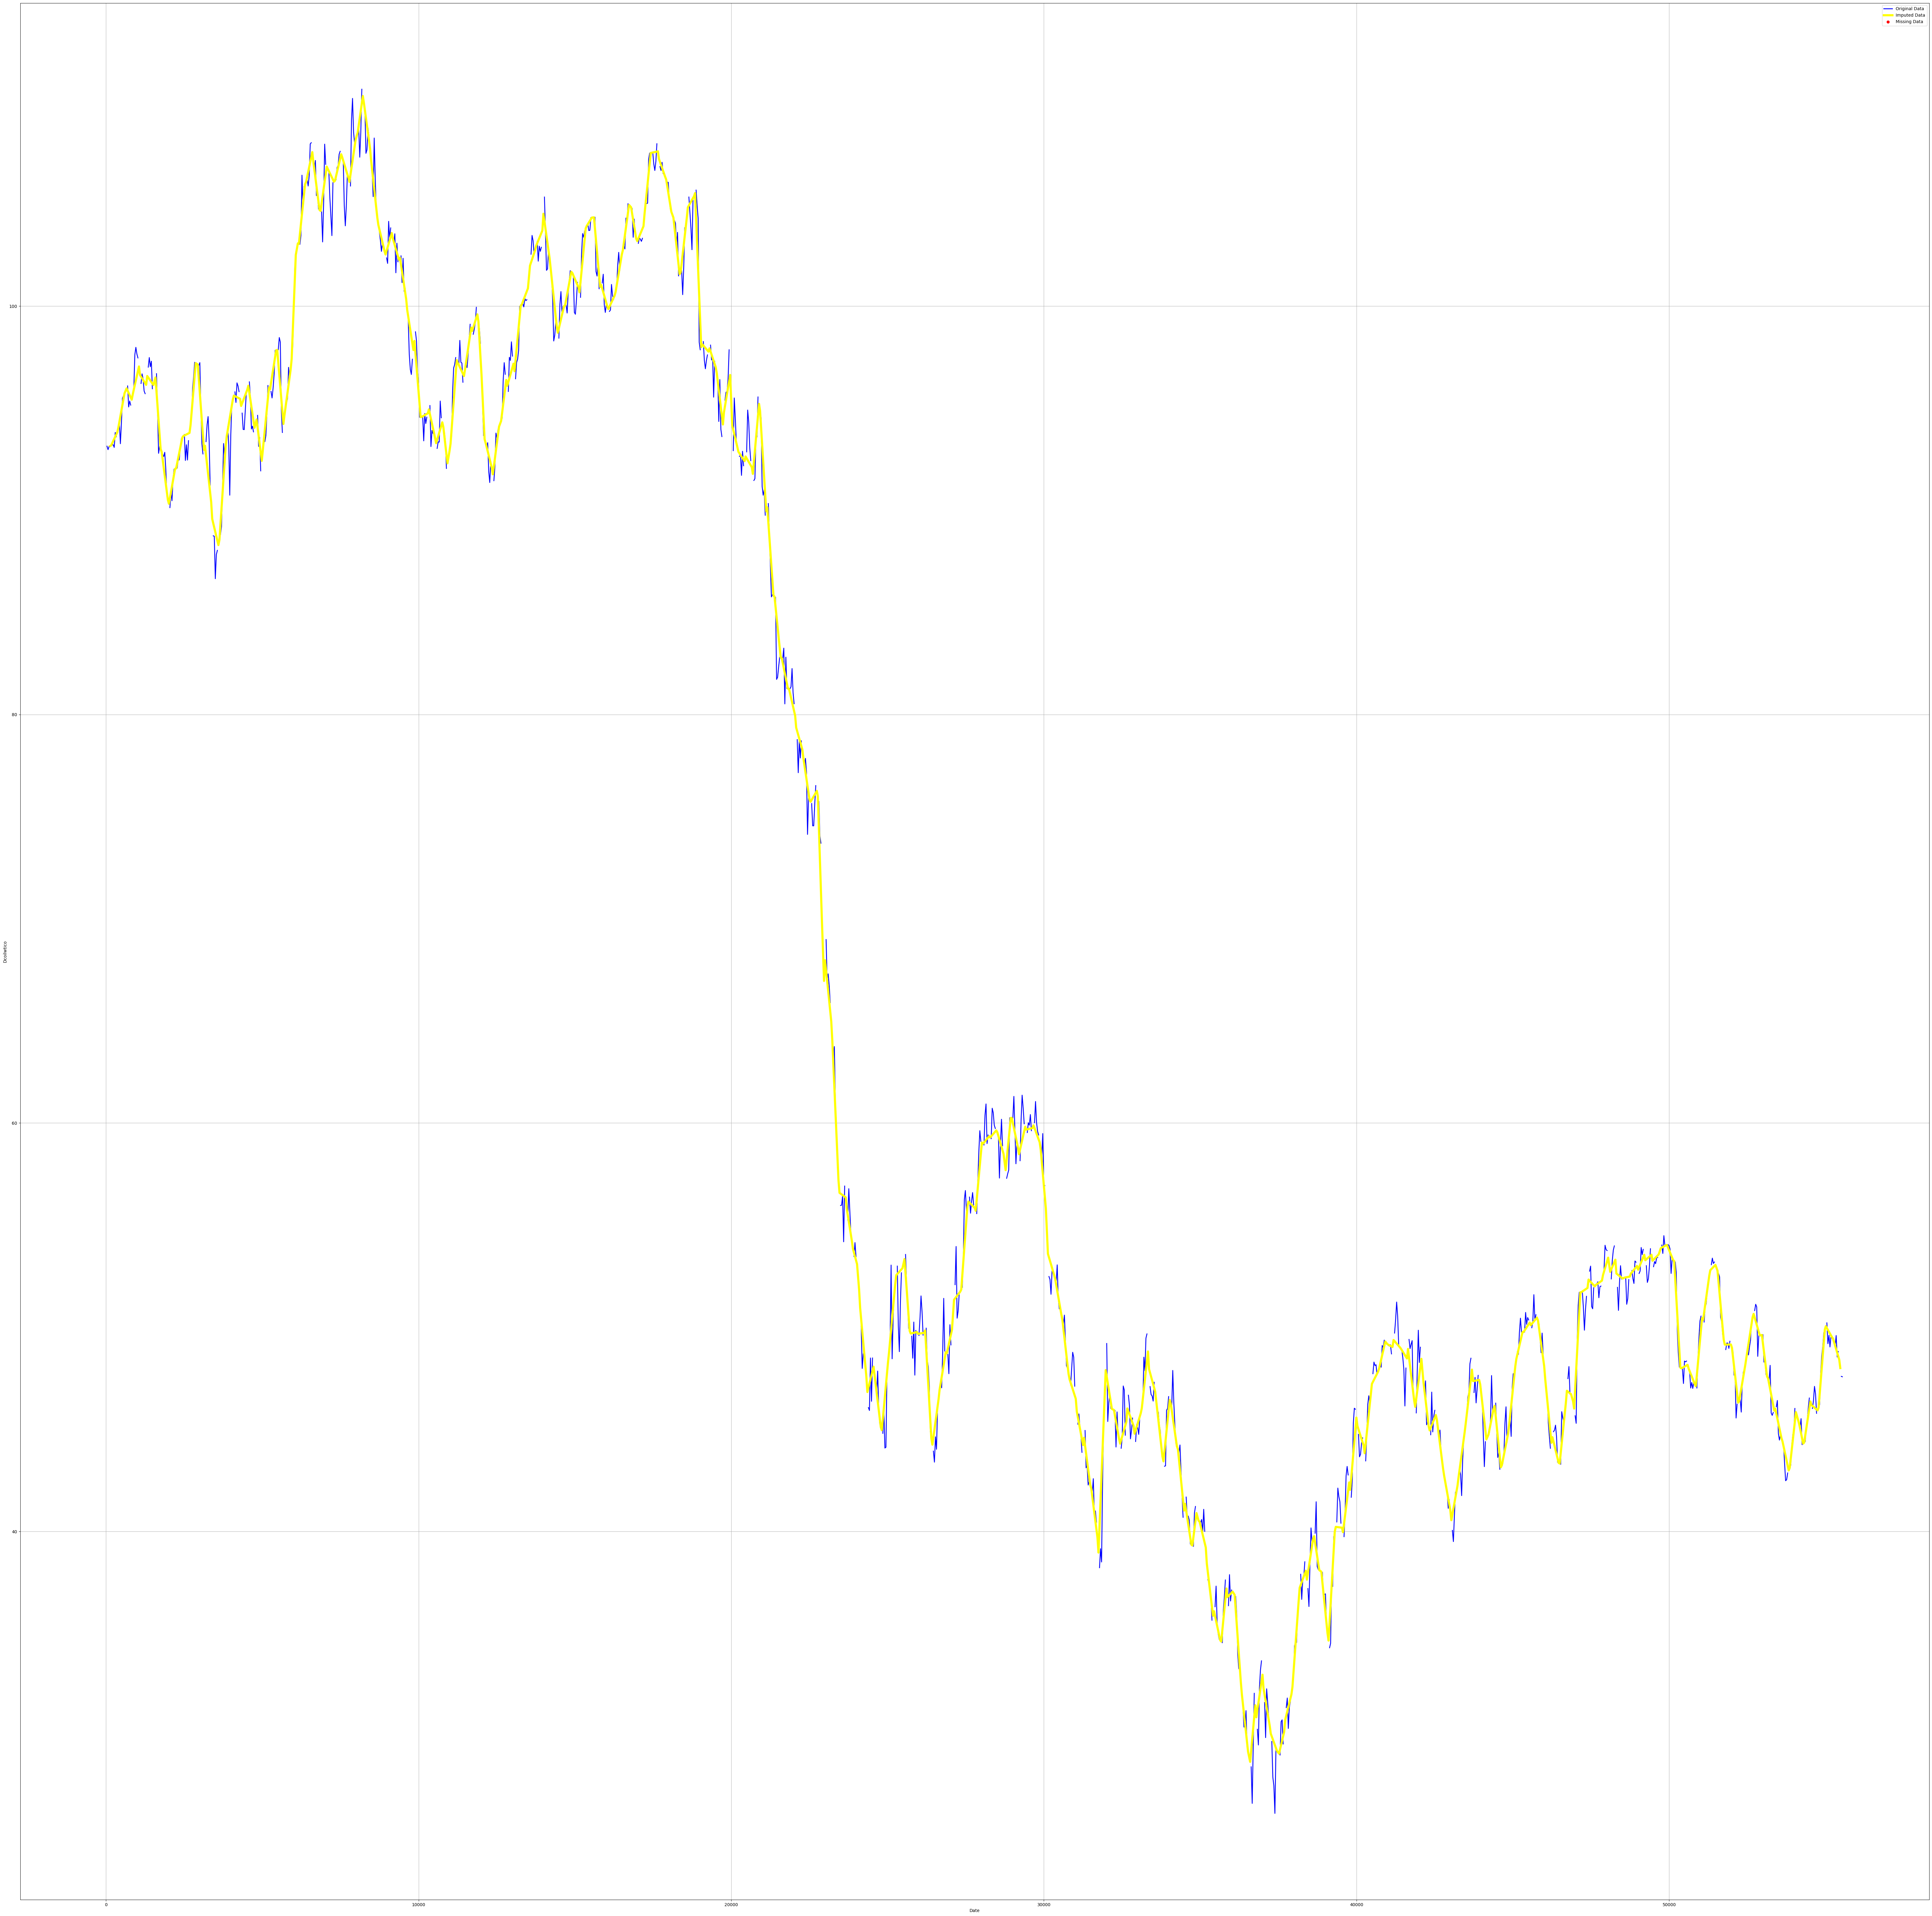

Jumlah missing value: 1


In [ ]:
missing_mask_automotive = df_store_automotive['dcoilwtico'].isna()

plt.figure(figsize=(80, 80))
plt.plot(df_store_automotive.index, df_store_automotive['dcoilwtico'], linestyle='-', color='blue', label='Original Data', lw=2)
plt.plot(df_store_automotive.index[missing_mask_automotive], df_store_automotive_imp_int.loc[missing_mask_automotive, 'dcoilwtico'], linestyle='-', color='yellow', label='Imputed Data', lw=5)

missing_indices_automotive = df_store_automotive_imp_int.isna()
plt.scatter(df_store_automotive.index[missing_mask_automotive], df_store_automotive.loc[missing_mask_automotive, 'dcoilwtico'], color='red', label='Missing Data', zorder=5)
plt.xlabel('Date')
plt.ylabel('Dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()
print(f"Jumlah missing value: {missing_indices_automotive['dcoilwtico'].sum()}")

In [ ]:
#Imputasi diatas dilanjutkan Backward Fill karena masih ada nilai missing value
df_store_automotive_imp_int = df_store_automotive_imp_int.bfill()
print(f"Jumlah missing value: {df_store_automotive_imp_int['dcoilwtico'].isna().sum()}")
df_store_automotive_imp_int['year'] = df_store_automotive_imp_int['date'].dt.year
df_store_automotive_imp_int['month'] = df_store_automotive_imp_int['date'].dt.month
df_store_automotive_imp_int['day'] = df_store_automotive_imp_int['date'].dt.day
#df_store_automotive_imp_int = df_store_automotive_imp_int.set_index('date')
try:
  df_store_automotive_imp_int.drop(columns=['family'], inplace=True)
except KeyError:
  pass

df_store_automotive_imp_int

Jumlah missing value: 0


date  sales  onpromotion  dcoilwtico  year  month  day
0     2013-01-01    0.0            0   93.140000  2013      1    1
33    2013-01-02    6.0            0   93.140000  2013      1    2
66    2013-01-03    4.0            0   92.970000  2013      1    3
99    2013-01-04    6.0            0   93.120000  2013      1    4
132   2013-01-05    4.0            0   93.146667  2013      1    5
...          ...    ...          ...         ...   ...    ...  ...
55407 2017-08-11   12.0            0   48.810000  2017      8   11
55440 2017-08-12    1.0            0   48.403333  2017      8   12
55473 2017-08-13   15.0            0   47.996667  2017      8   13
55506 2017-08-14    6.0            0   47.590000  2017      8   14
55539 2017-08-15    9.0            0   47.570000  2017      8   15

[1684 rows x 7 columns]

#####2.1.1.B. Lineplot

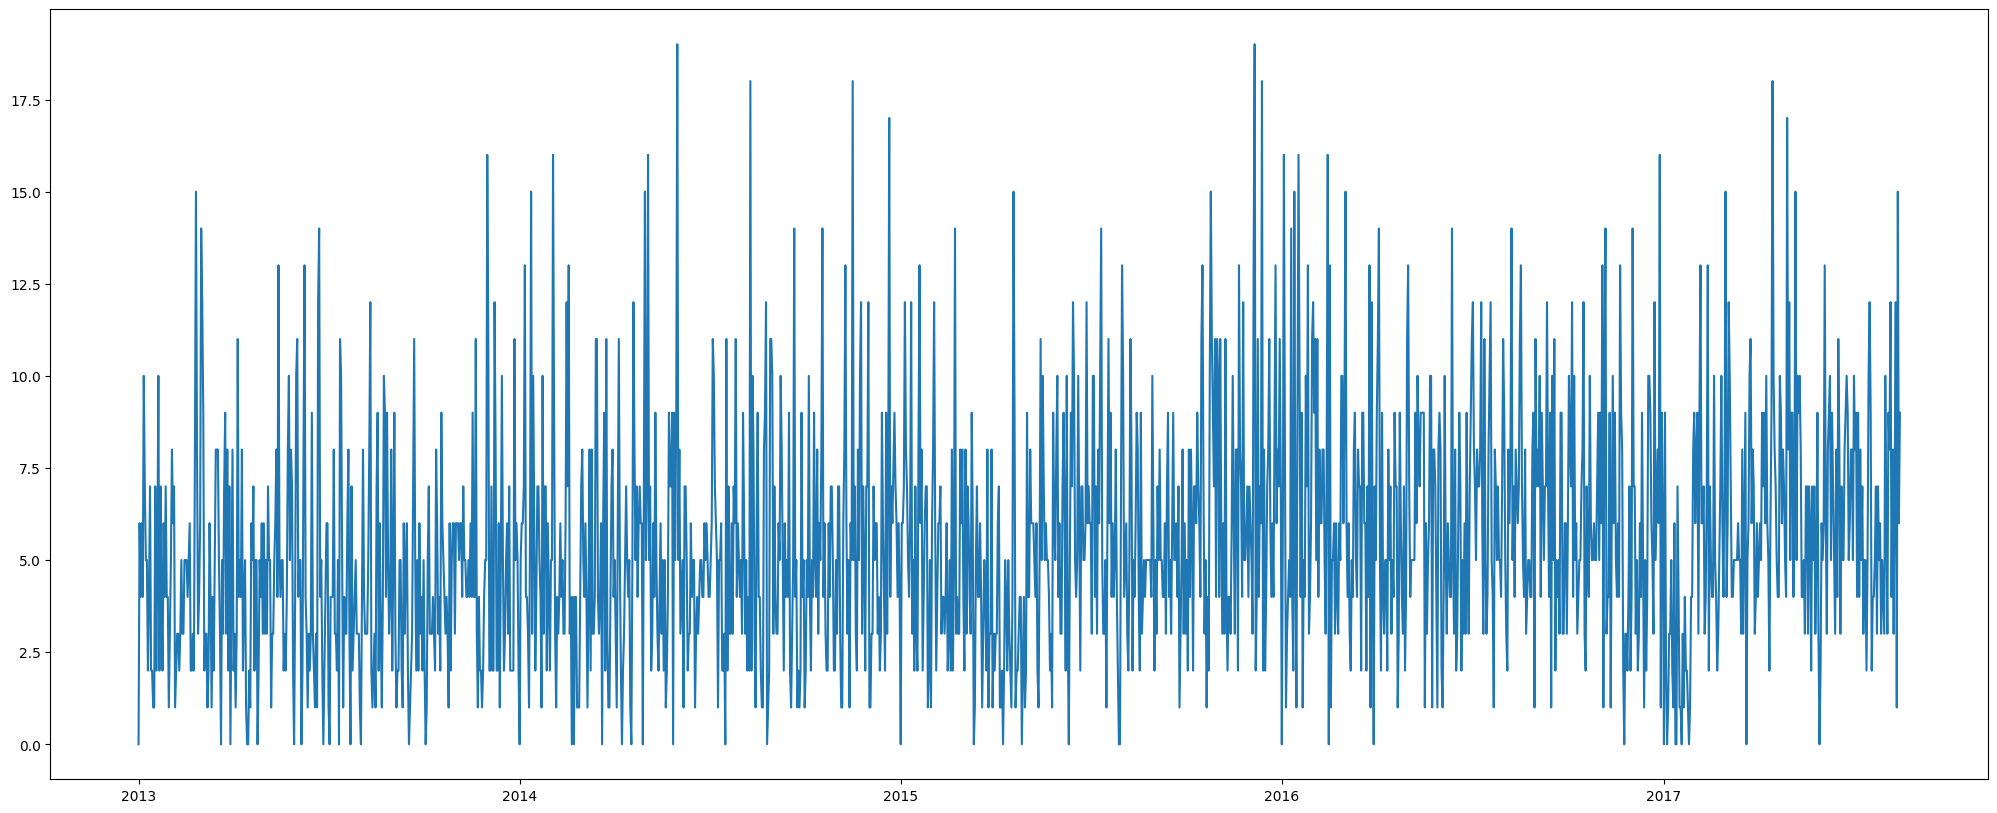

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('')
plt.plot(df_store_automotive_imp_int['date'], df_store_automotive_imp_int['sales'])
plt.show()

Melihat Lineplot lebih kecil lagi

In [ ]:
df_filtered = df_store_automotive_imp_int[(df_store_automotive_imp_int['date']>='2015-01-01') & (df_store_automotive_imp_int['date'] <='2015-12-31')]

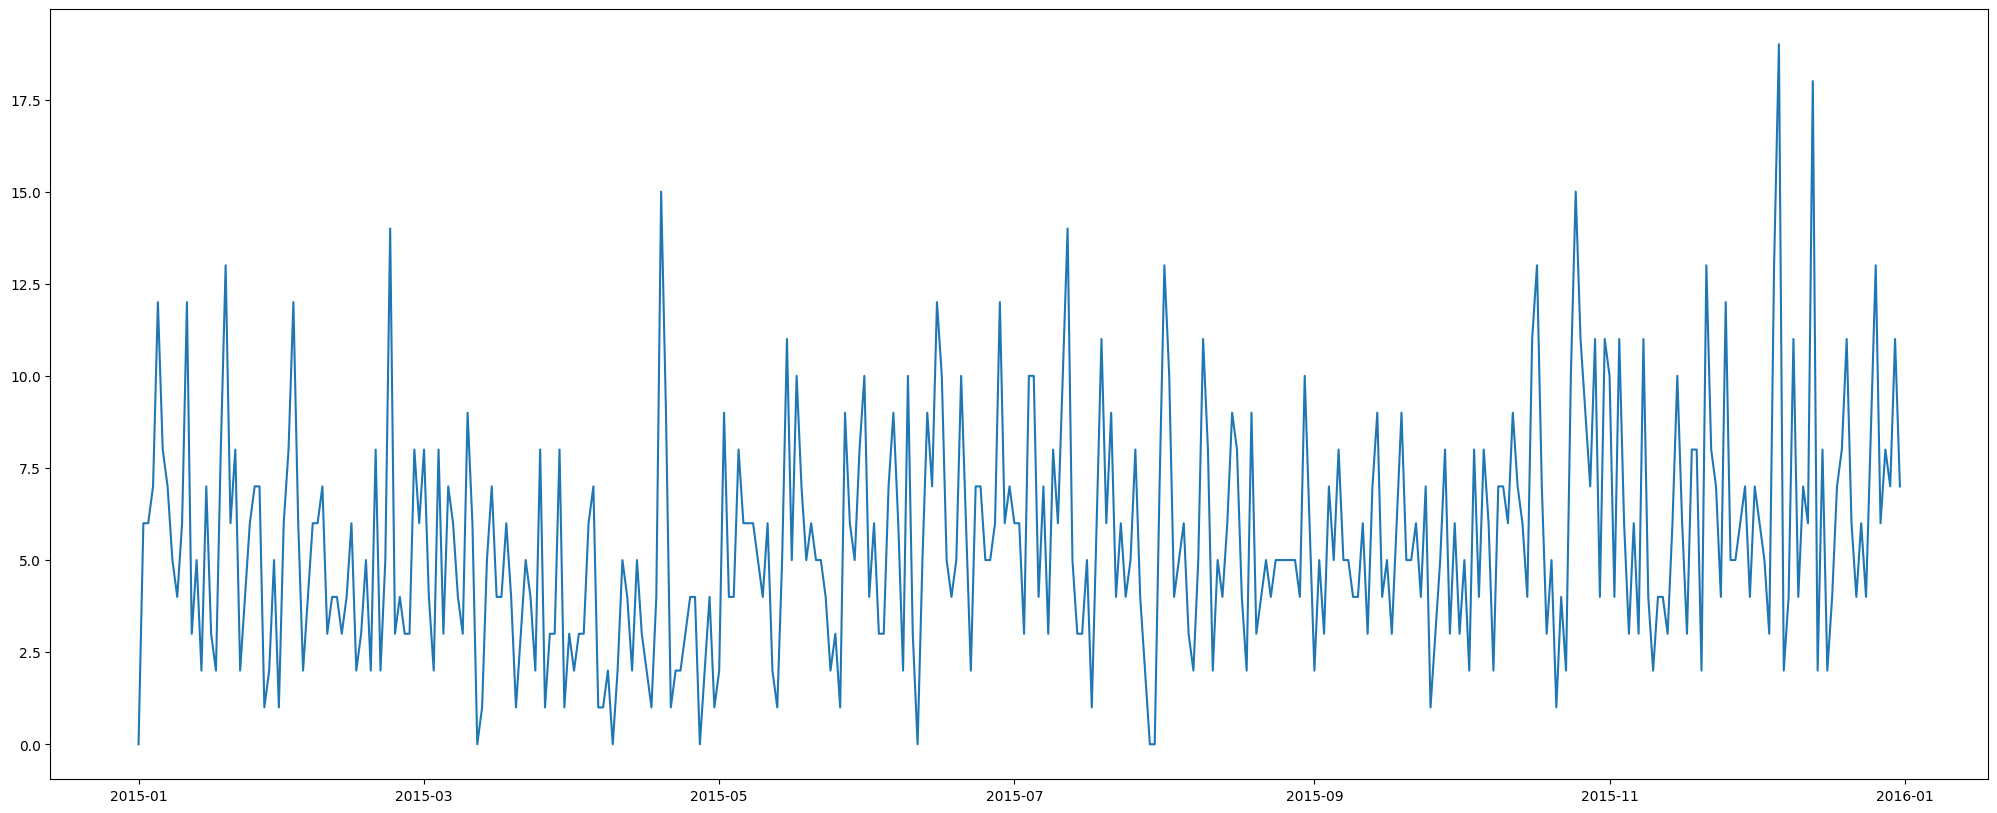

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('')
plt.plot(df_filtered['date'], df_filtered['sales'])
plt.show()

Gabungan feature slaes dan onpromotion

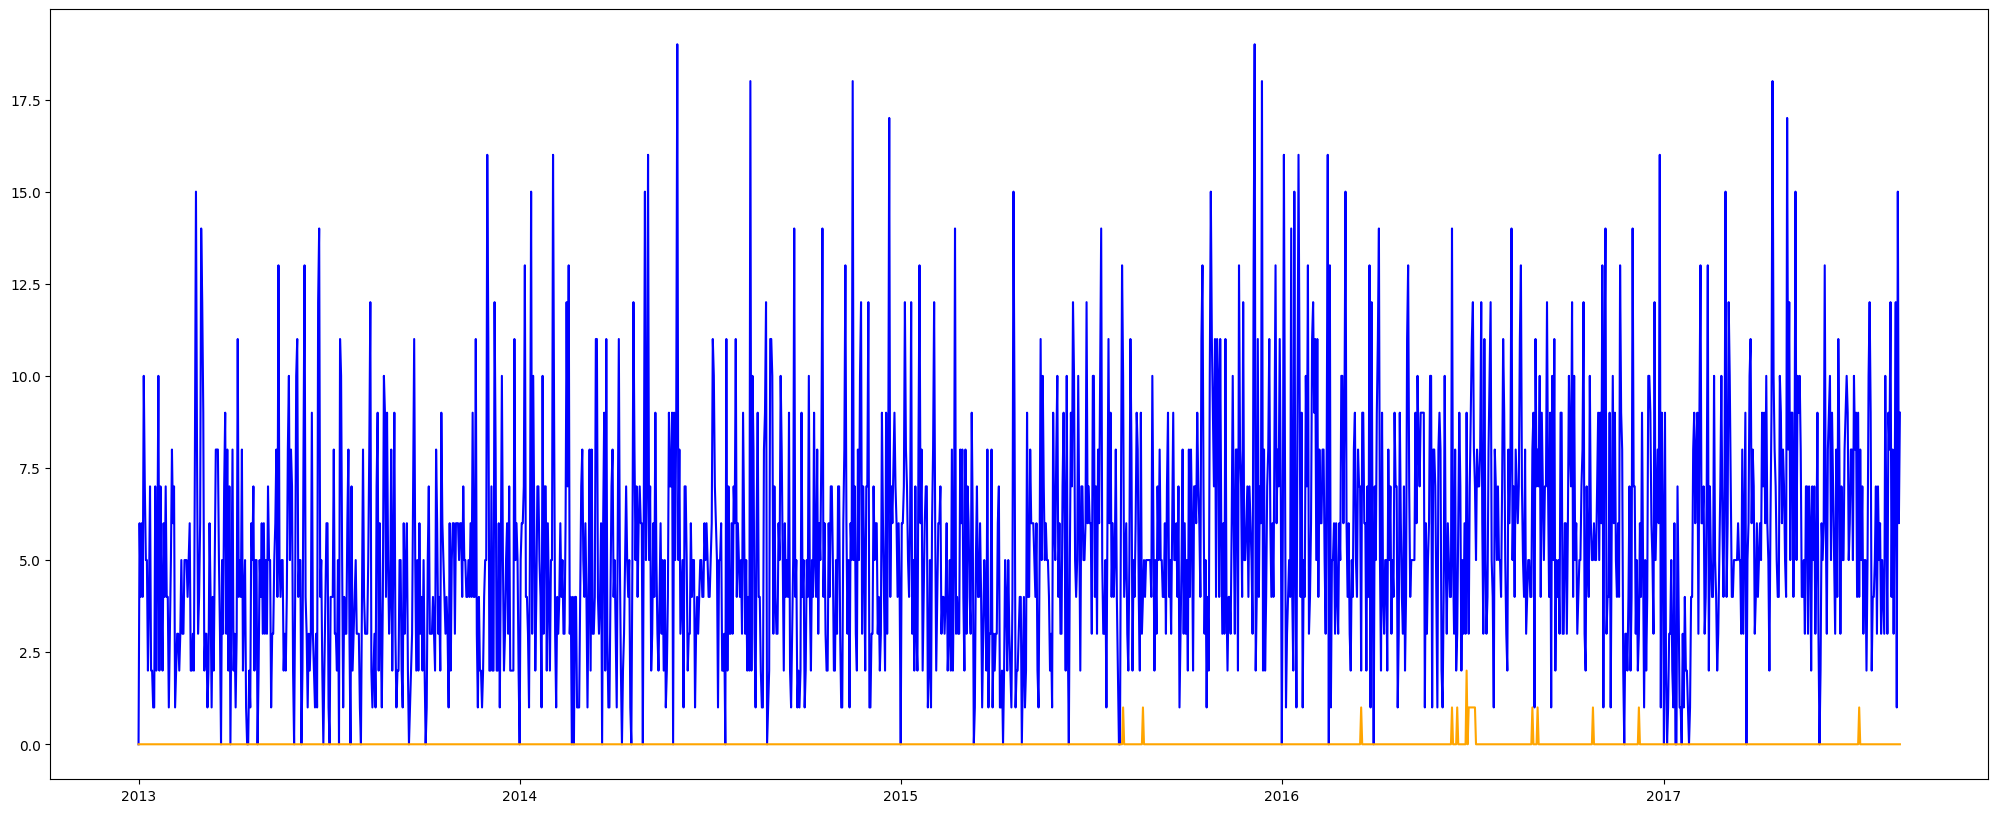

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('')
plt.plot(df_store_automotive_imp_int['date'], df_store_automotive_imp_int['sales'], c='blue')
plt.plot(df_store_automotive_imp_int['date'], df_store_automotive_imp_int['onpromotion'], c='orange')
plt.show()

#####2.1.1.C. Seasonal Decomposition

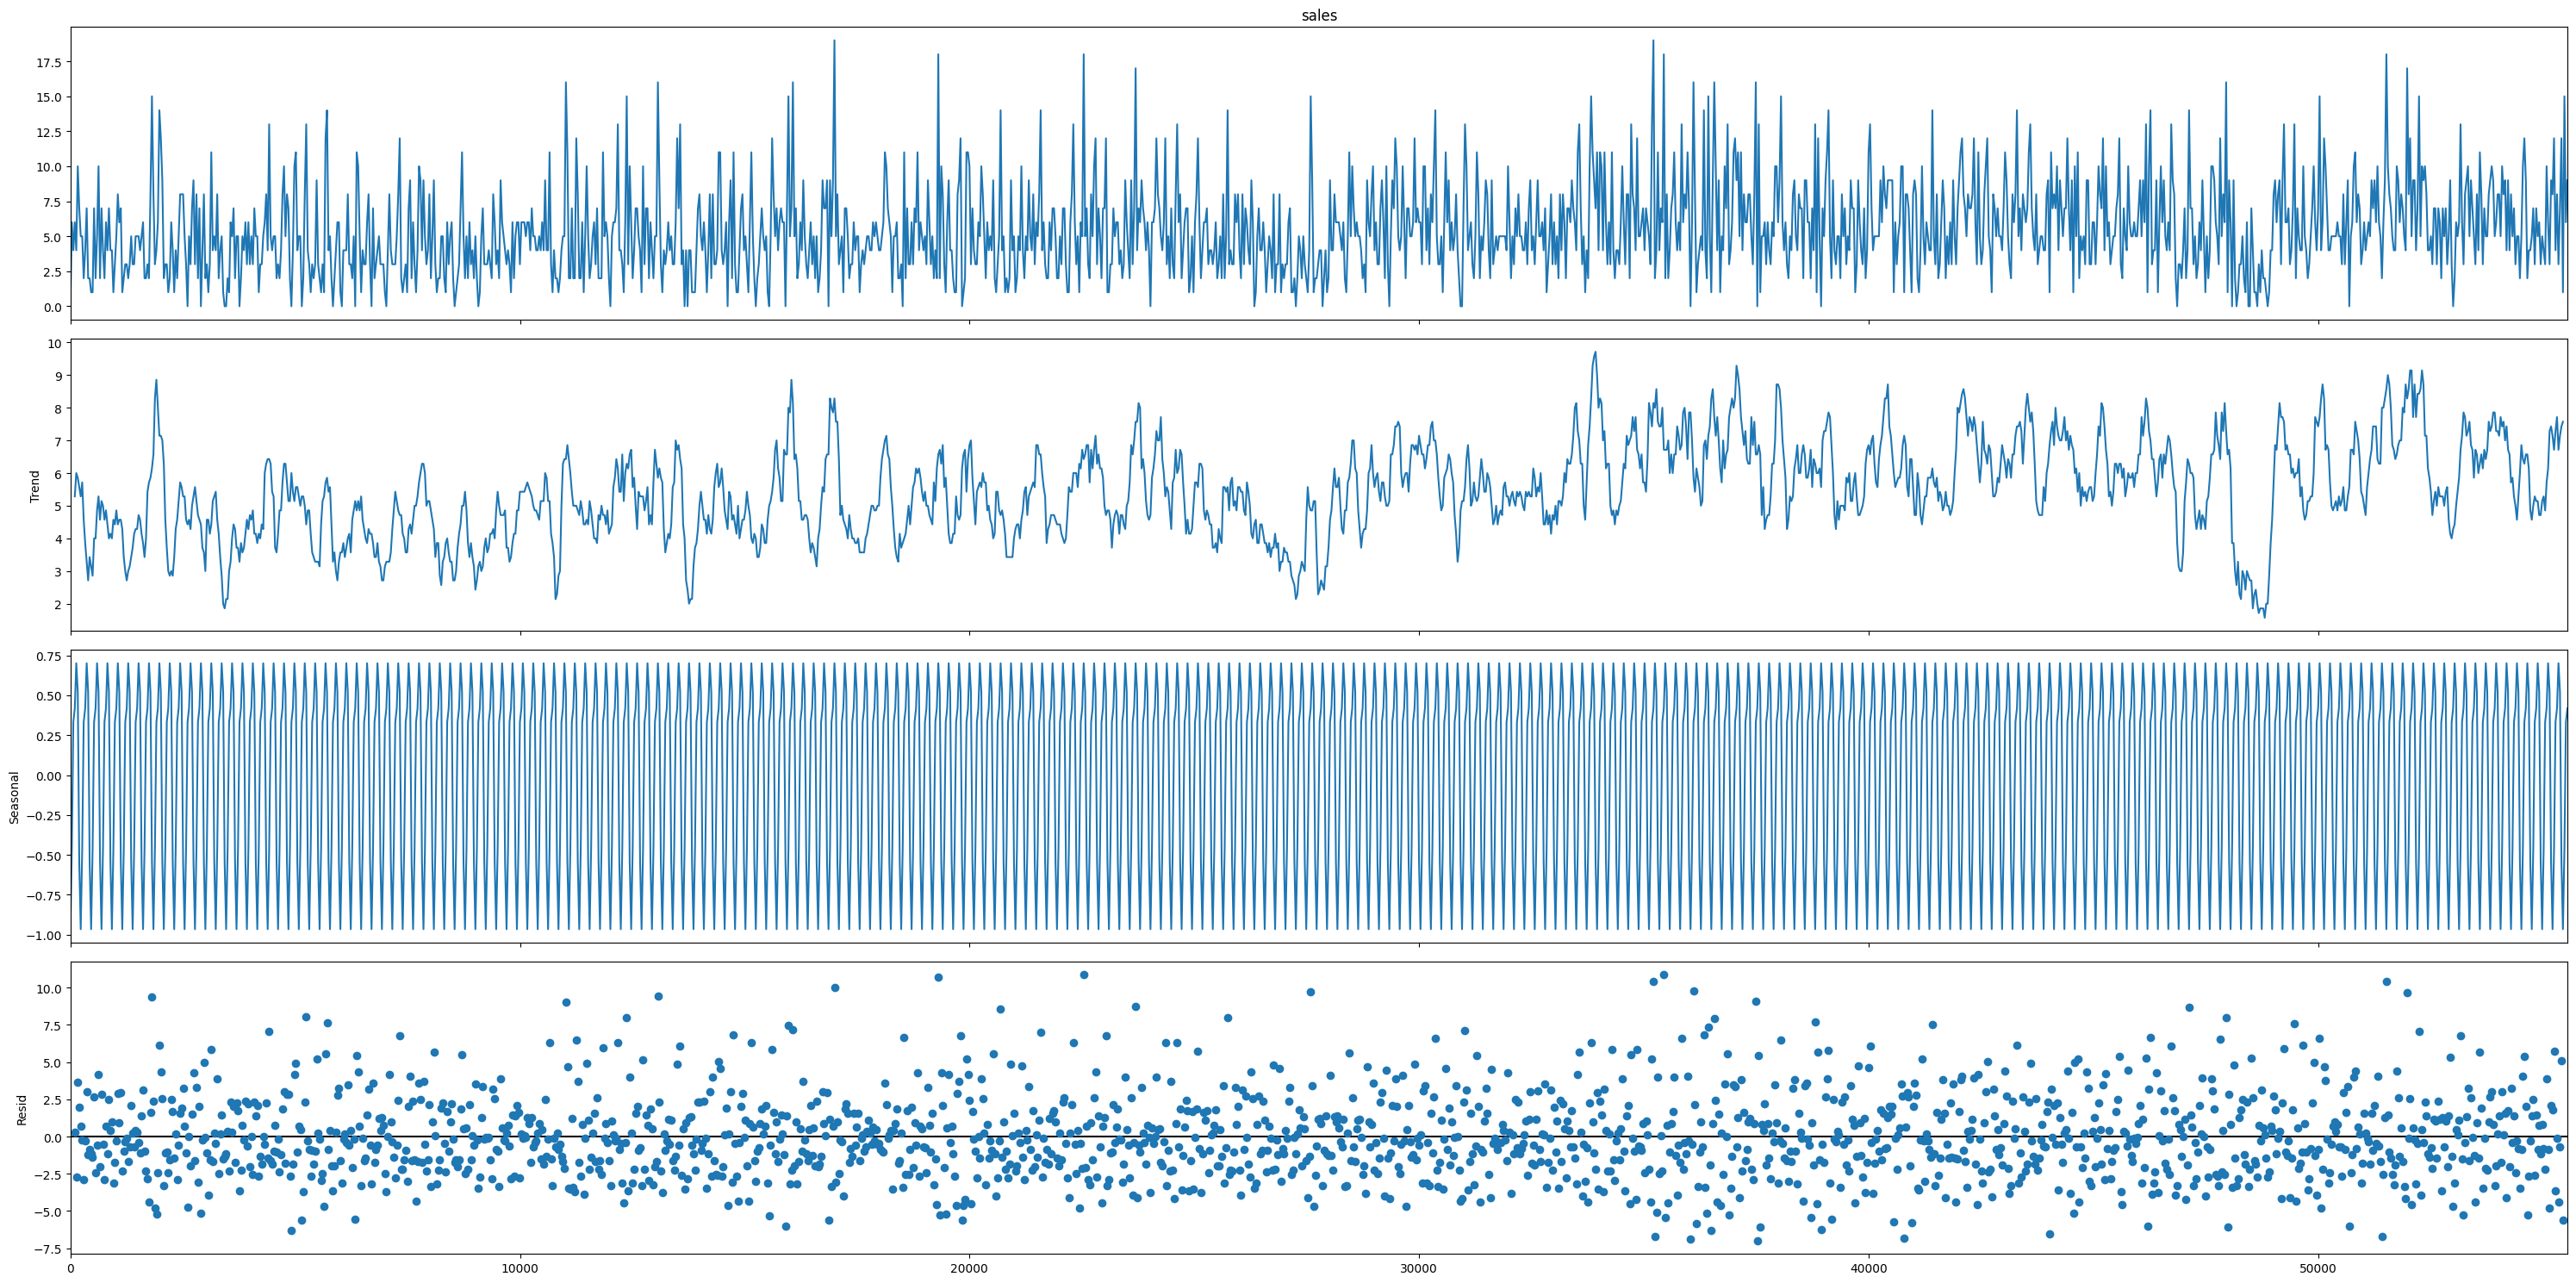

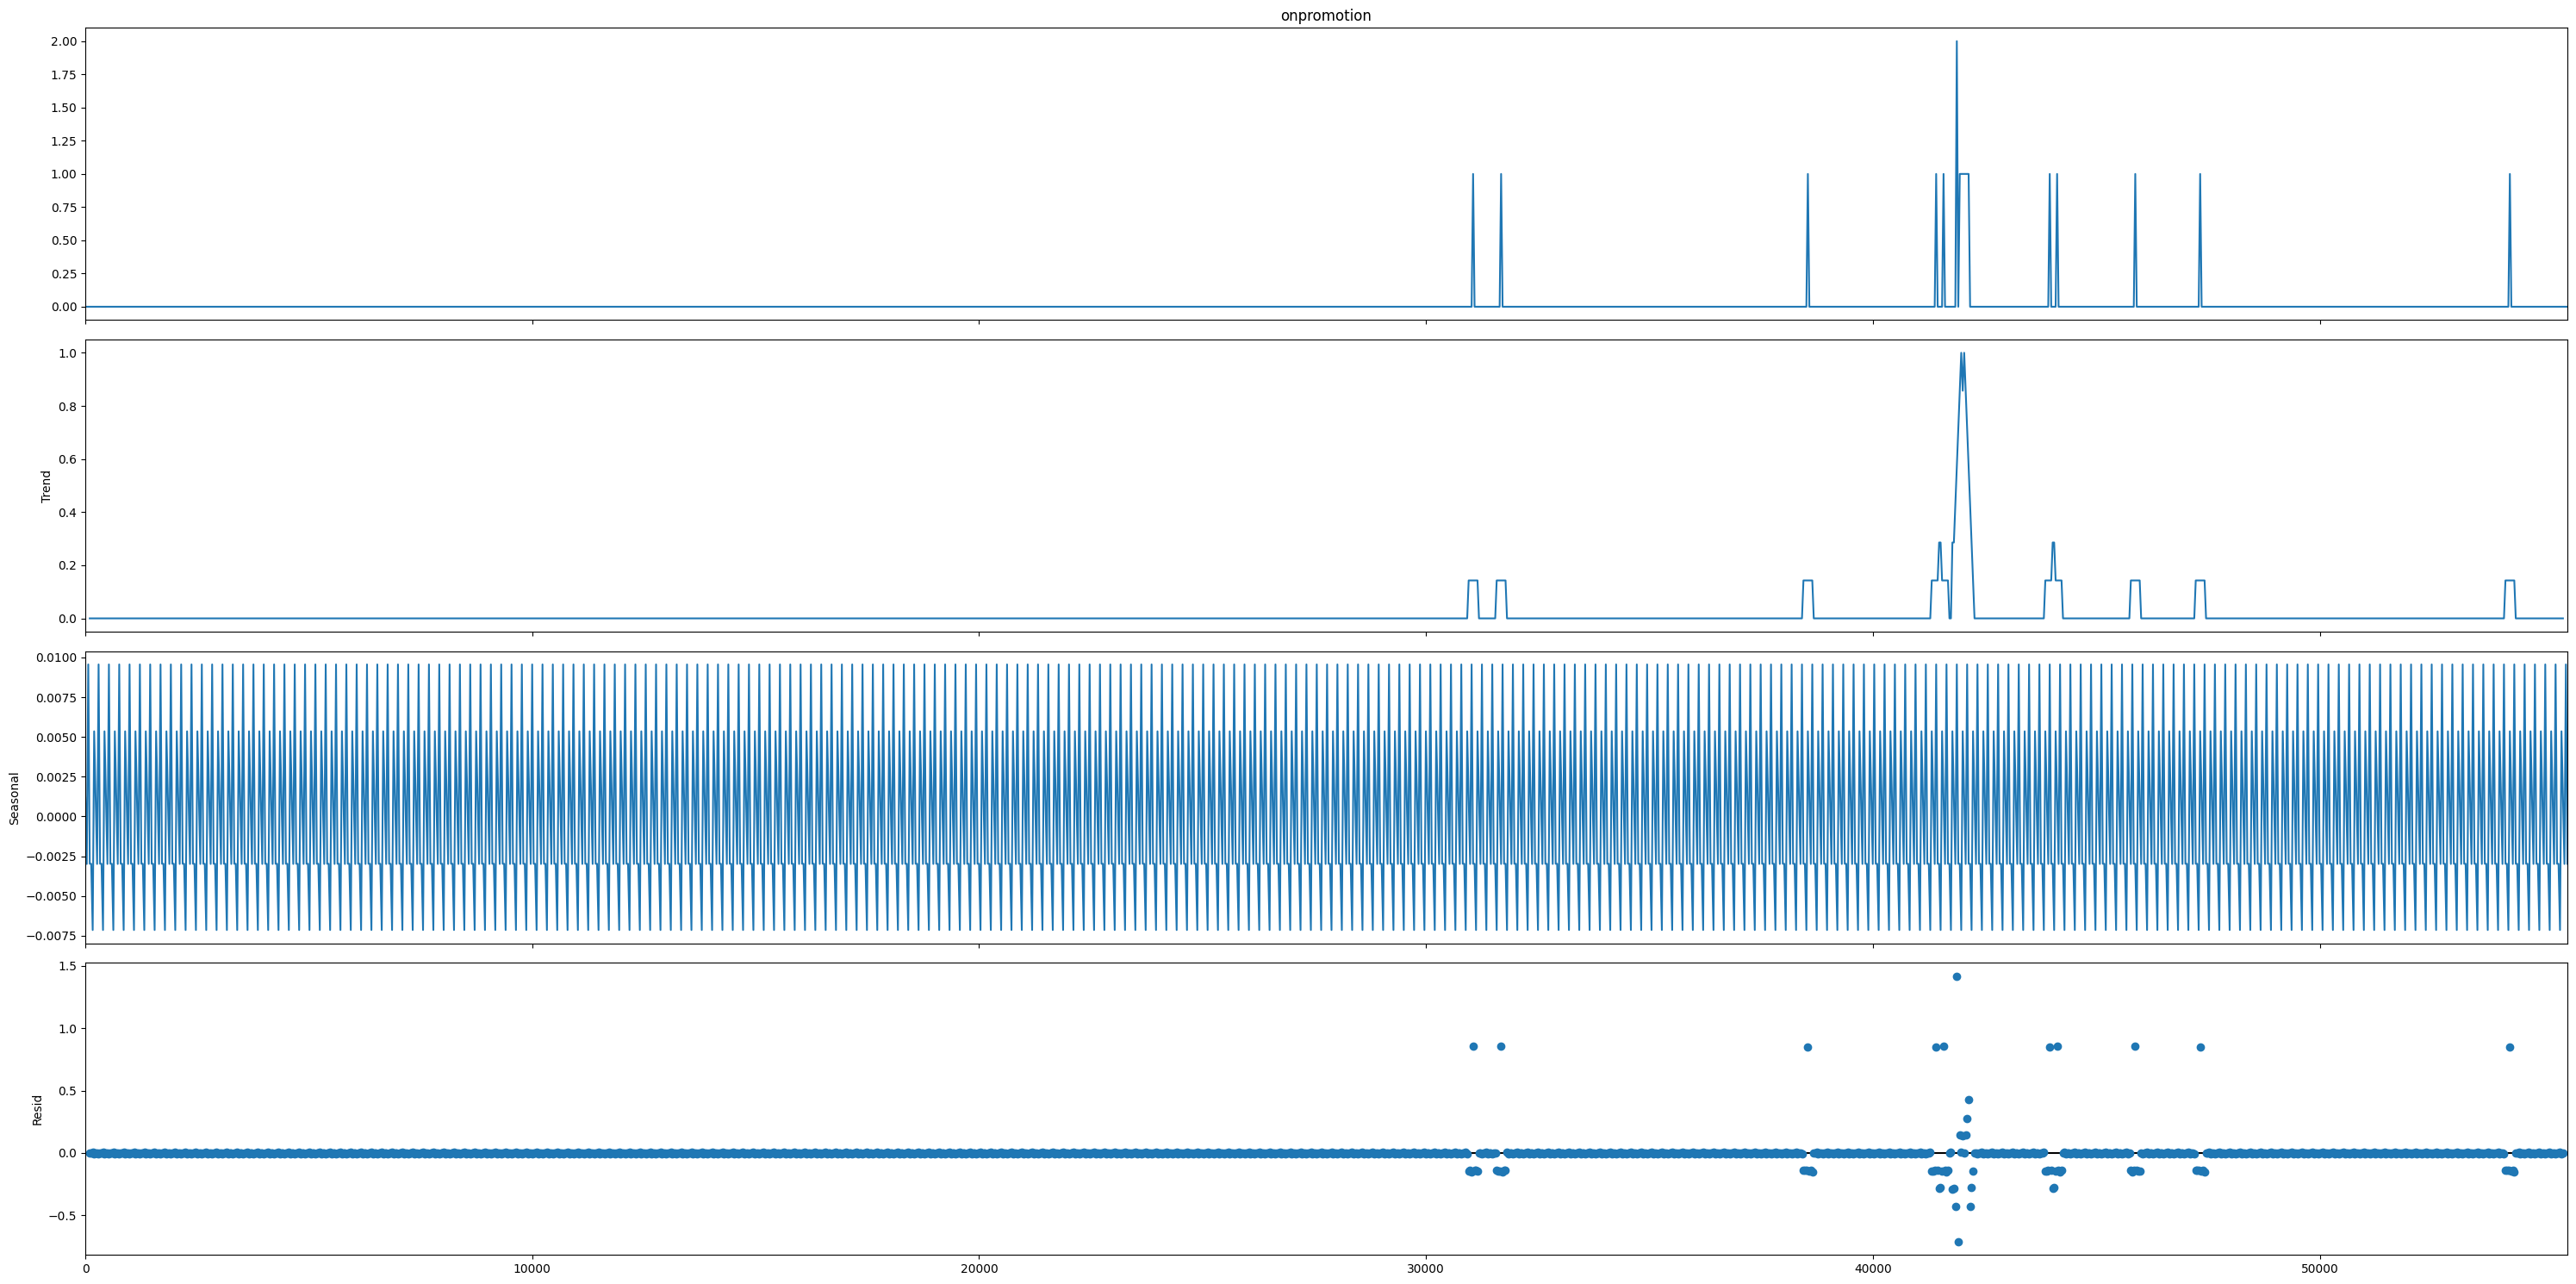

In [ ]:
#Seasonal Component weekly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_automotive_imp_int[var], model='add', period=7).plot()

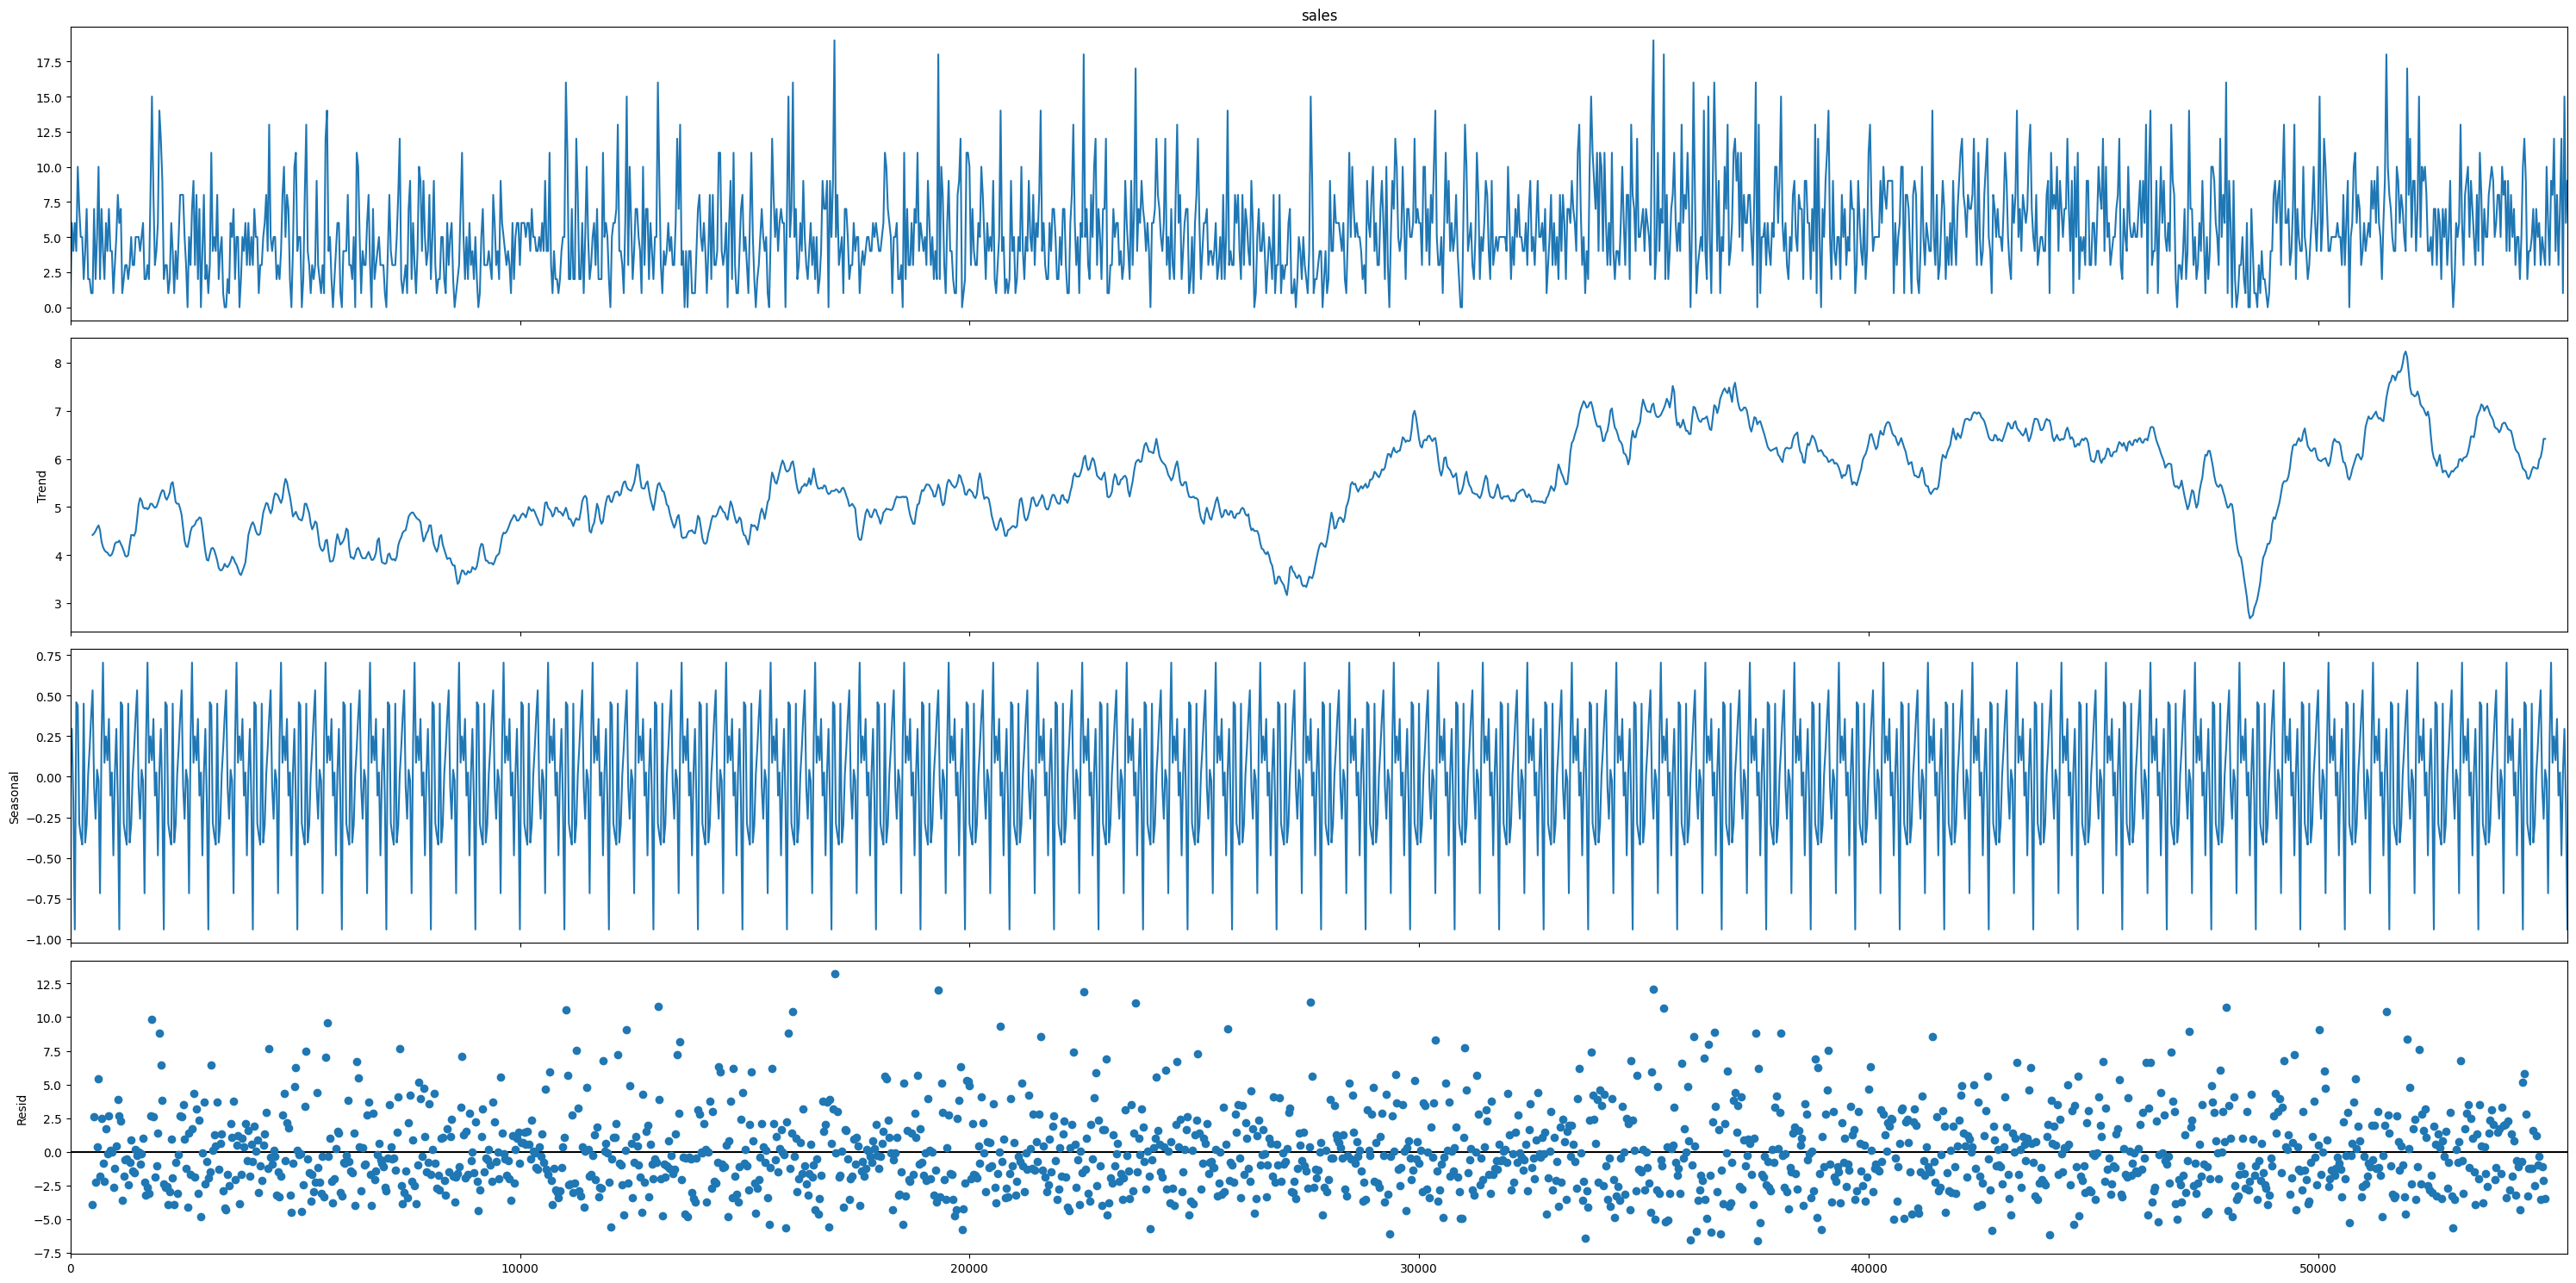

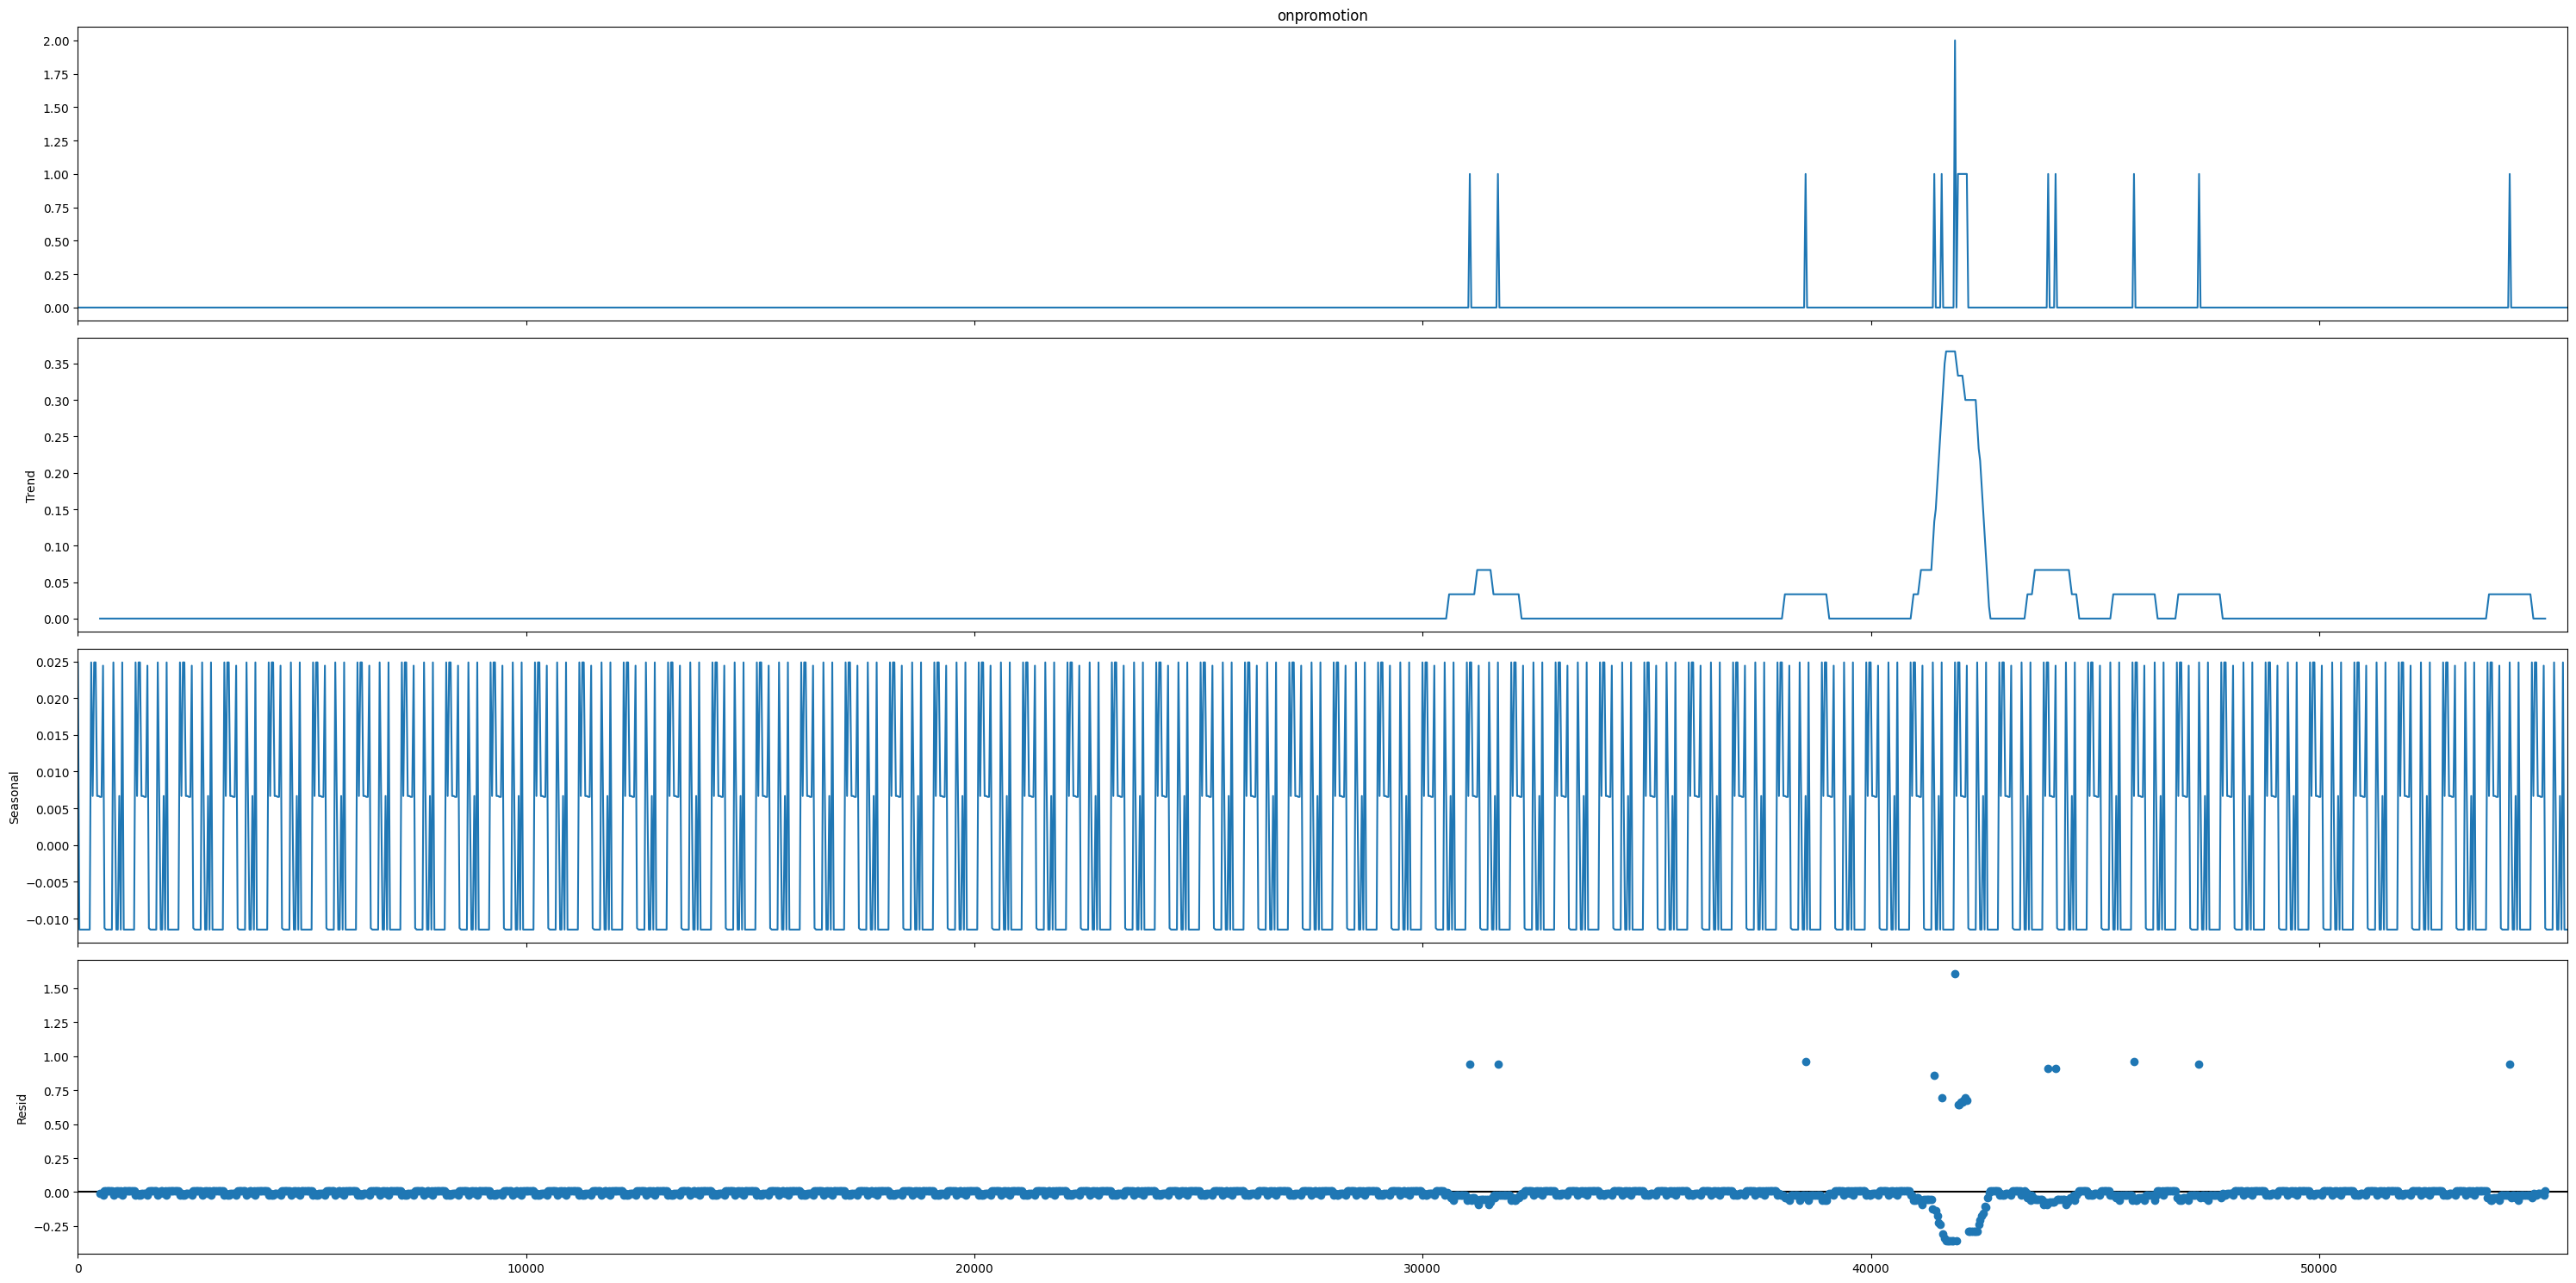

In [ ]:
#Komponen seasonal monthly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_automotive_imp_int[var], model='add', period=30).plot()

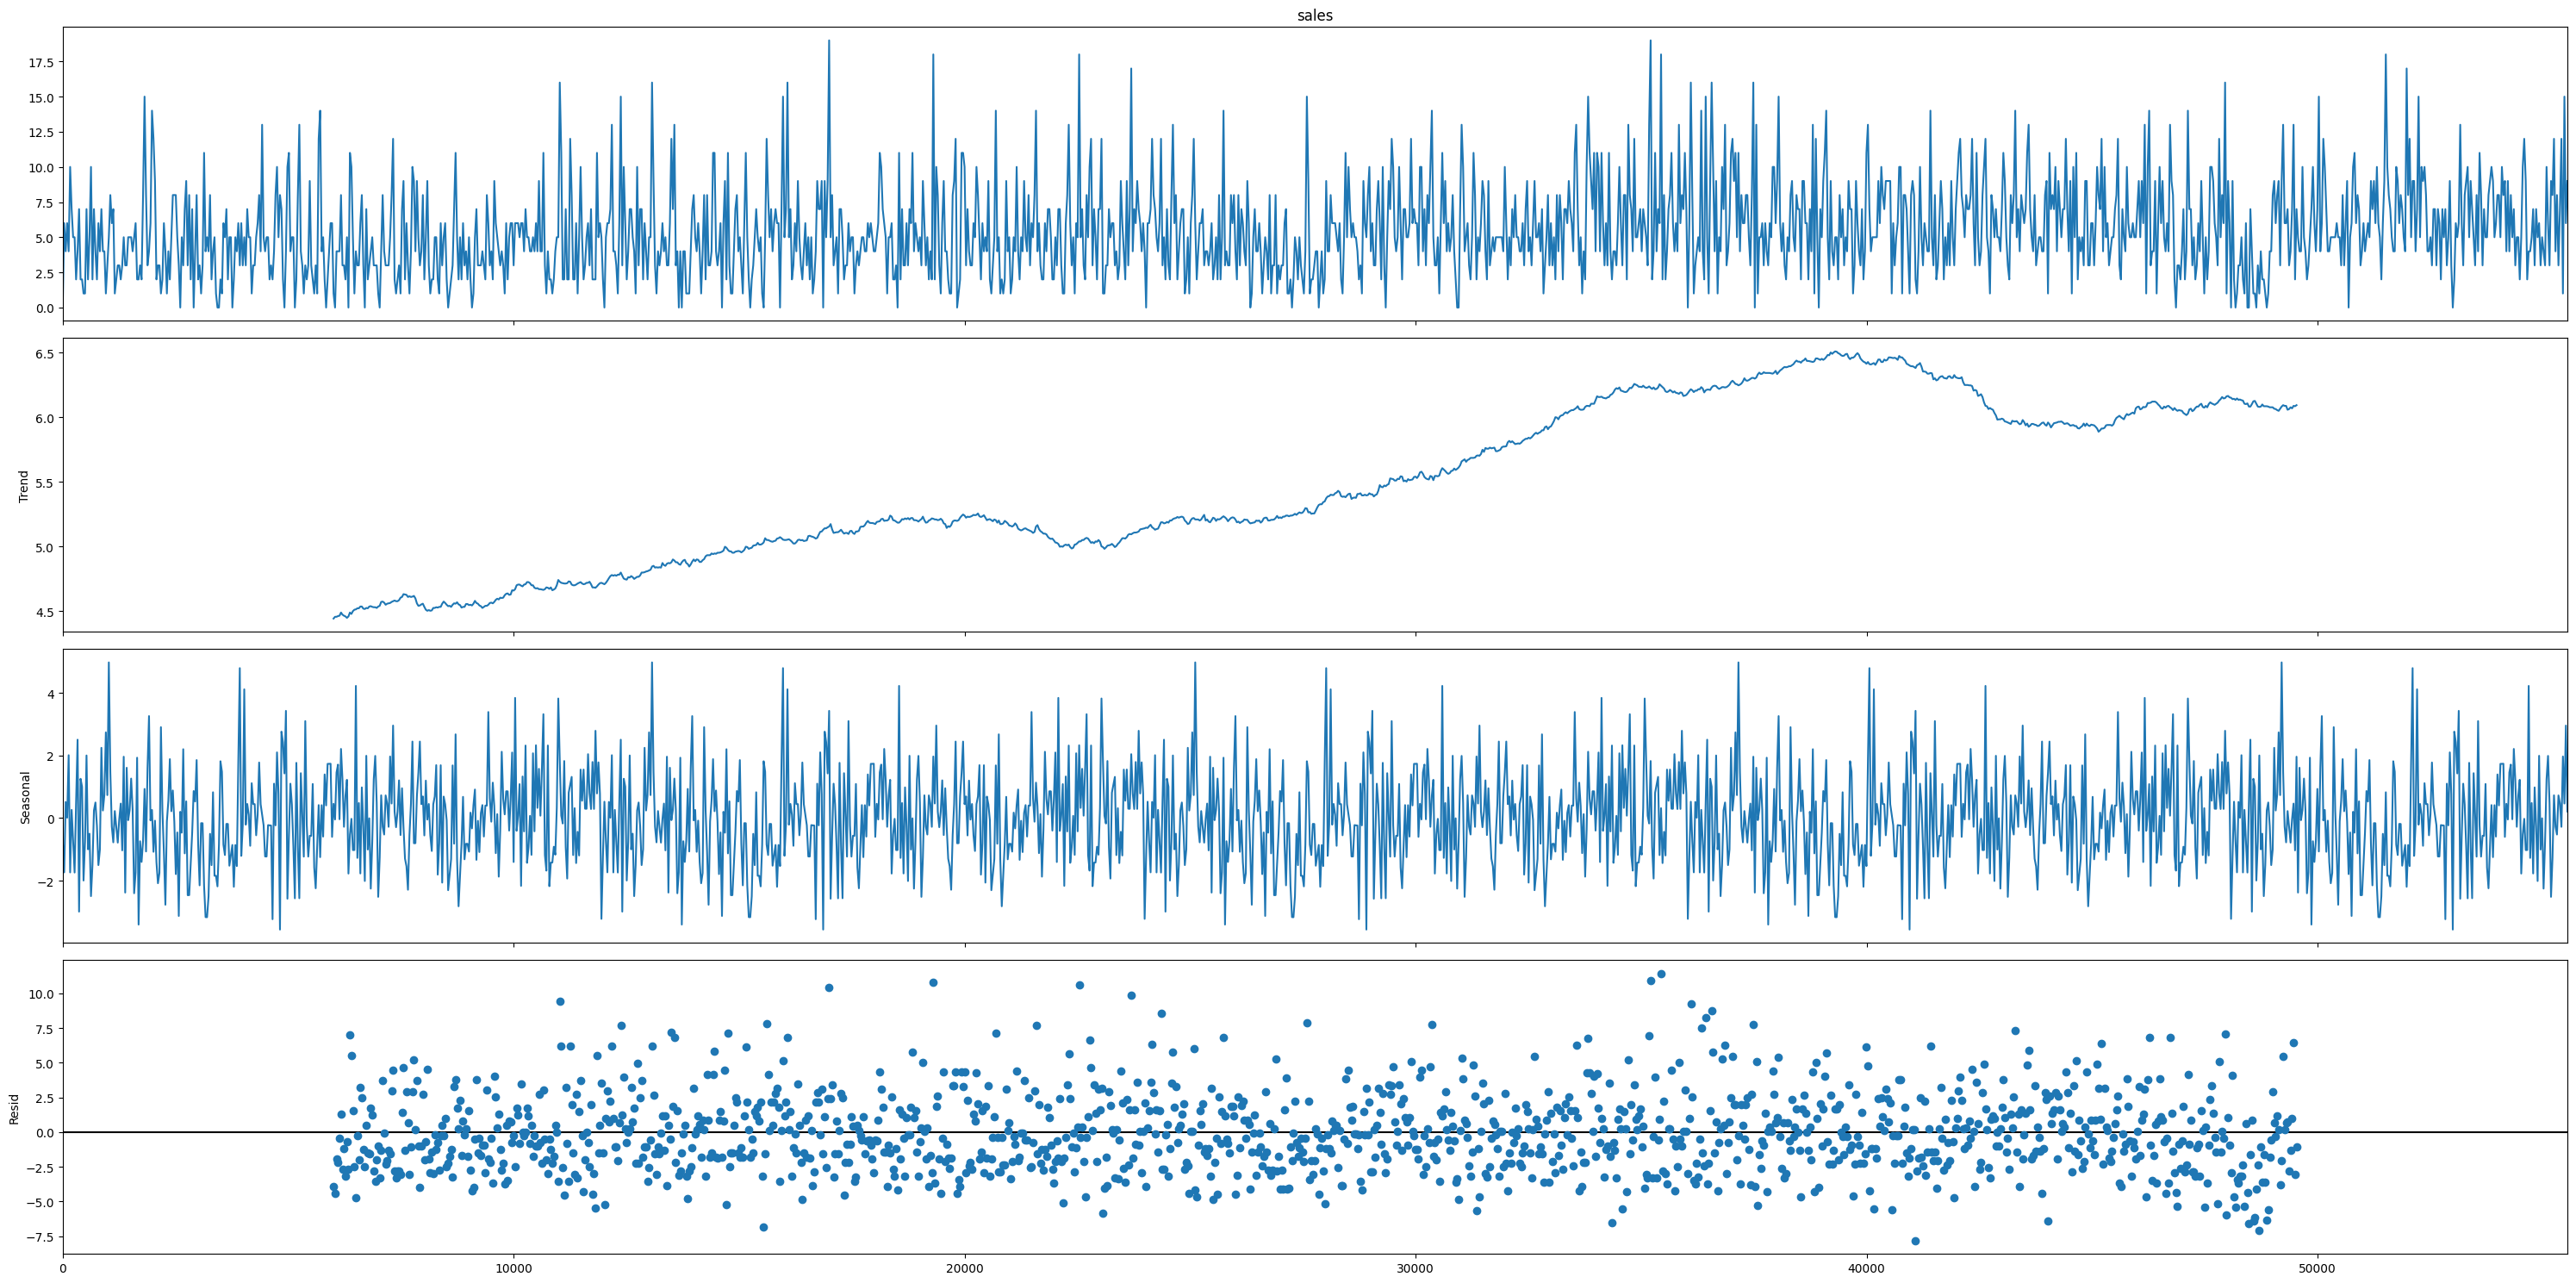

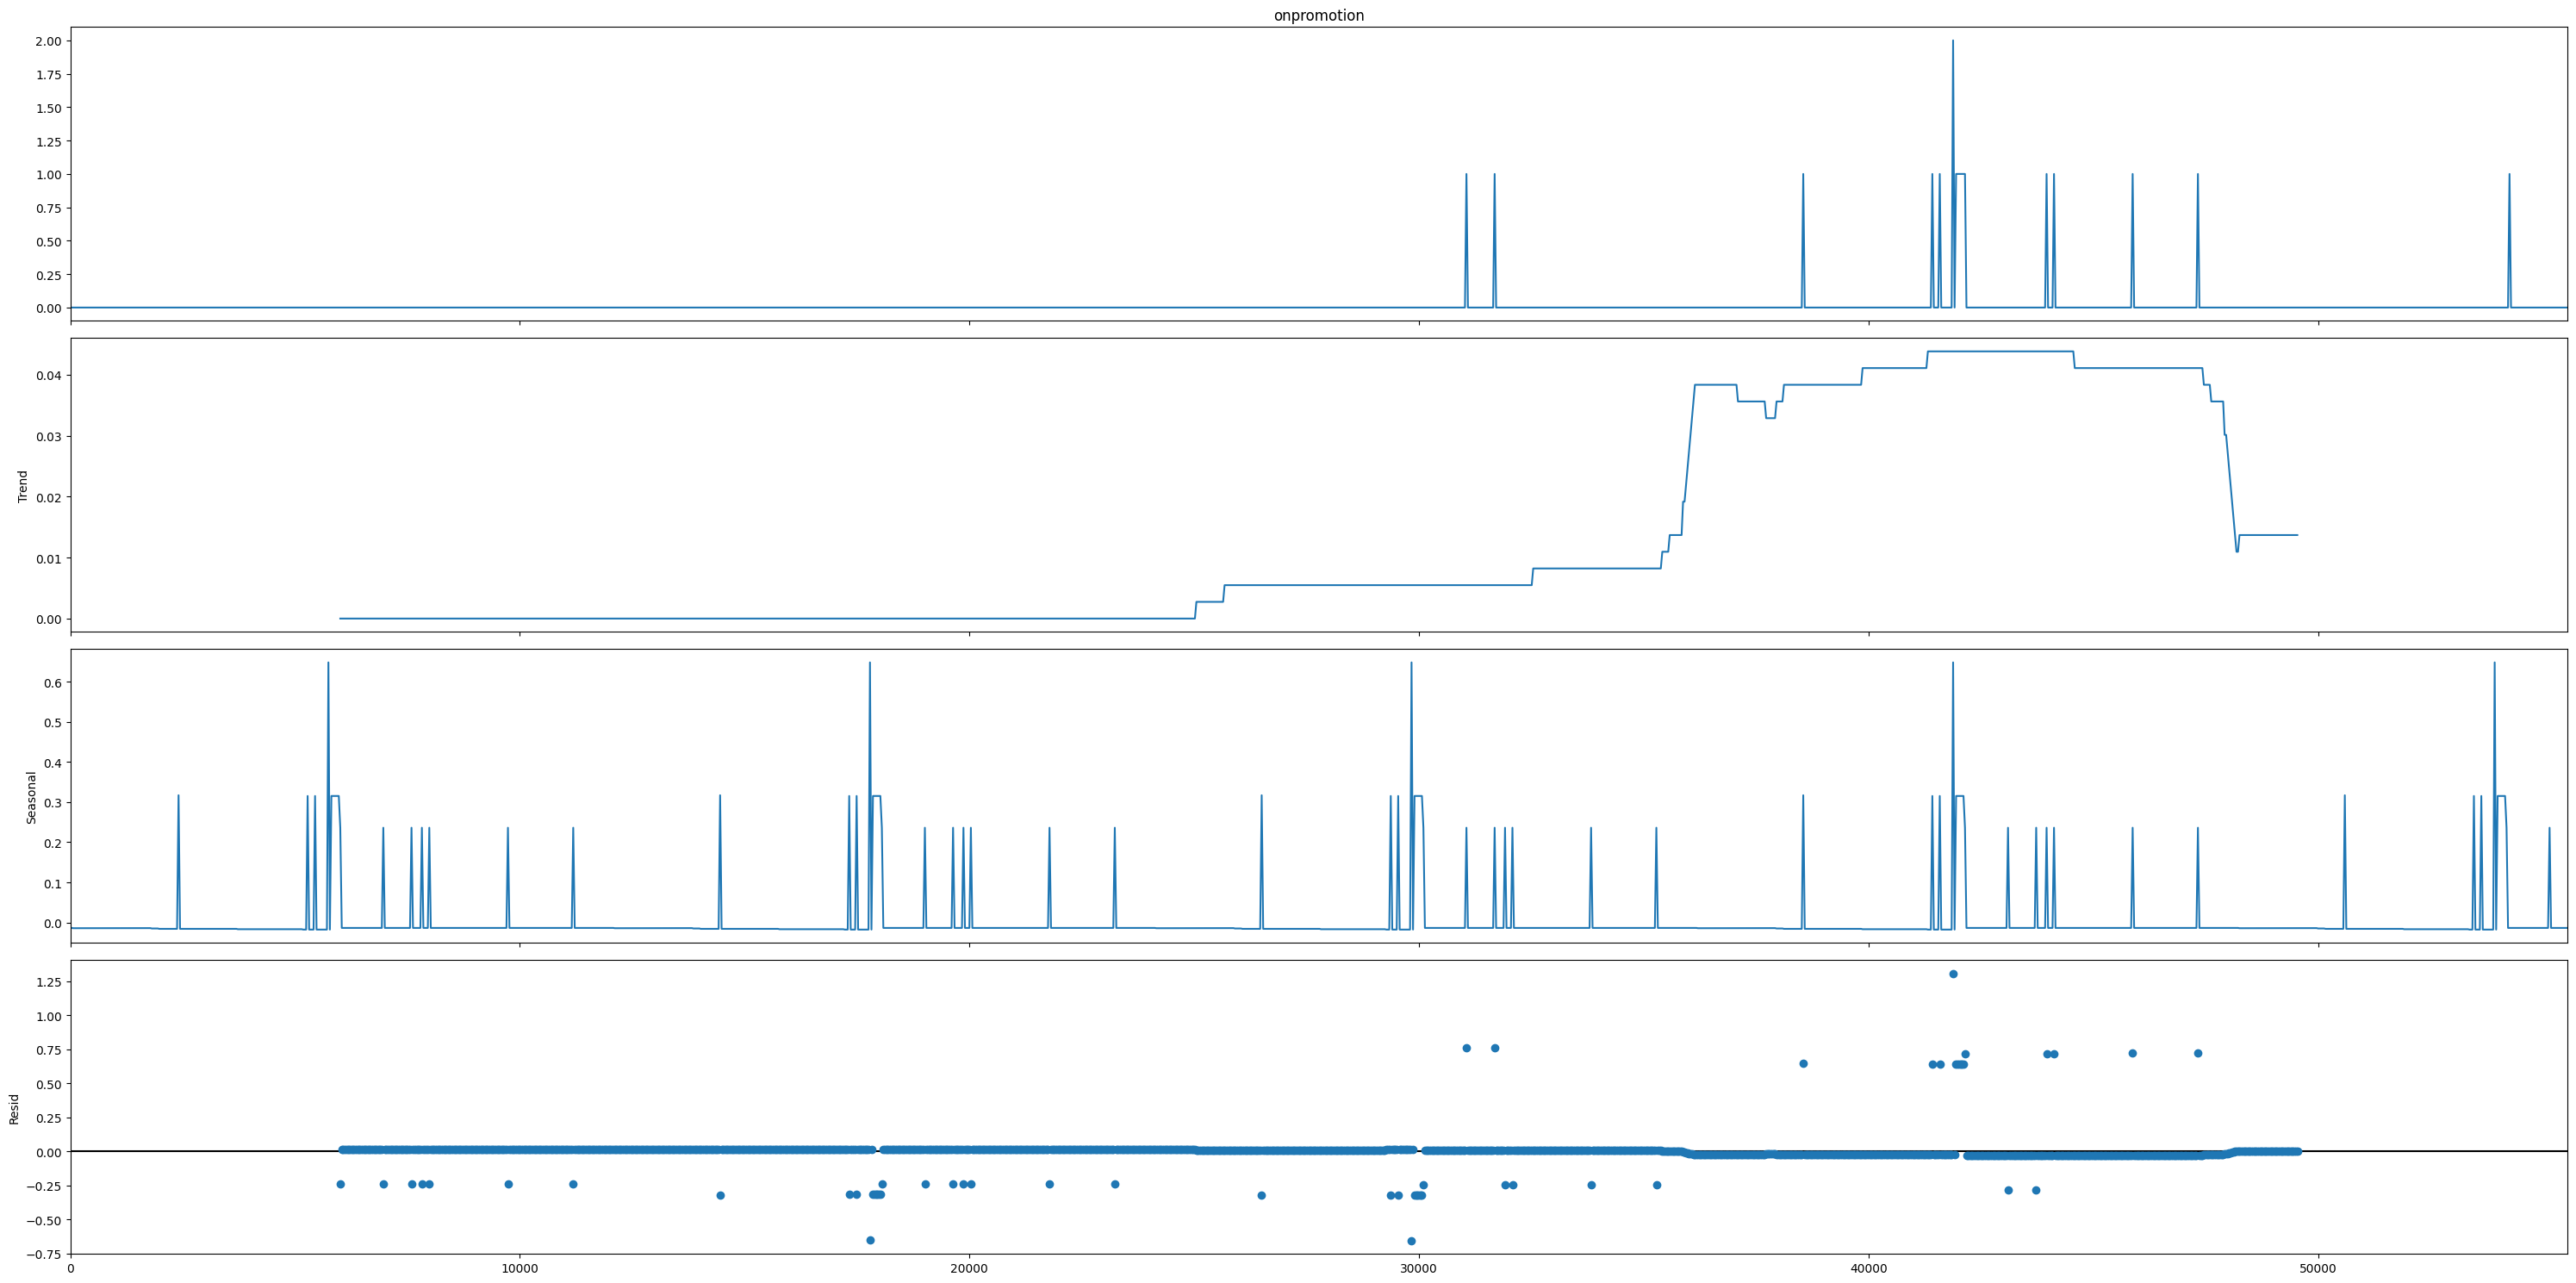

In [ ]:
#Komponen seasonal yearly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_automotive_imp_int[var], model='add', period=365).plot()

#####2.1.1.D. Autocorrelation Plot

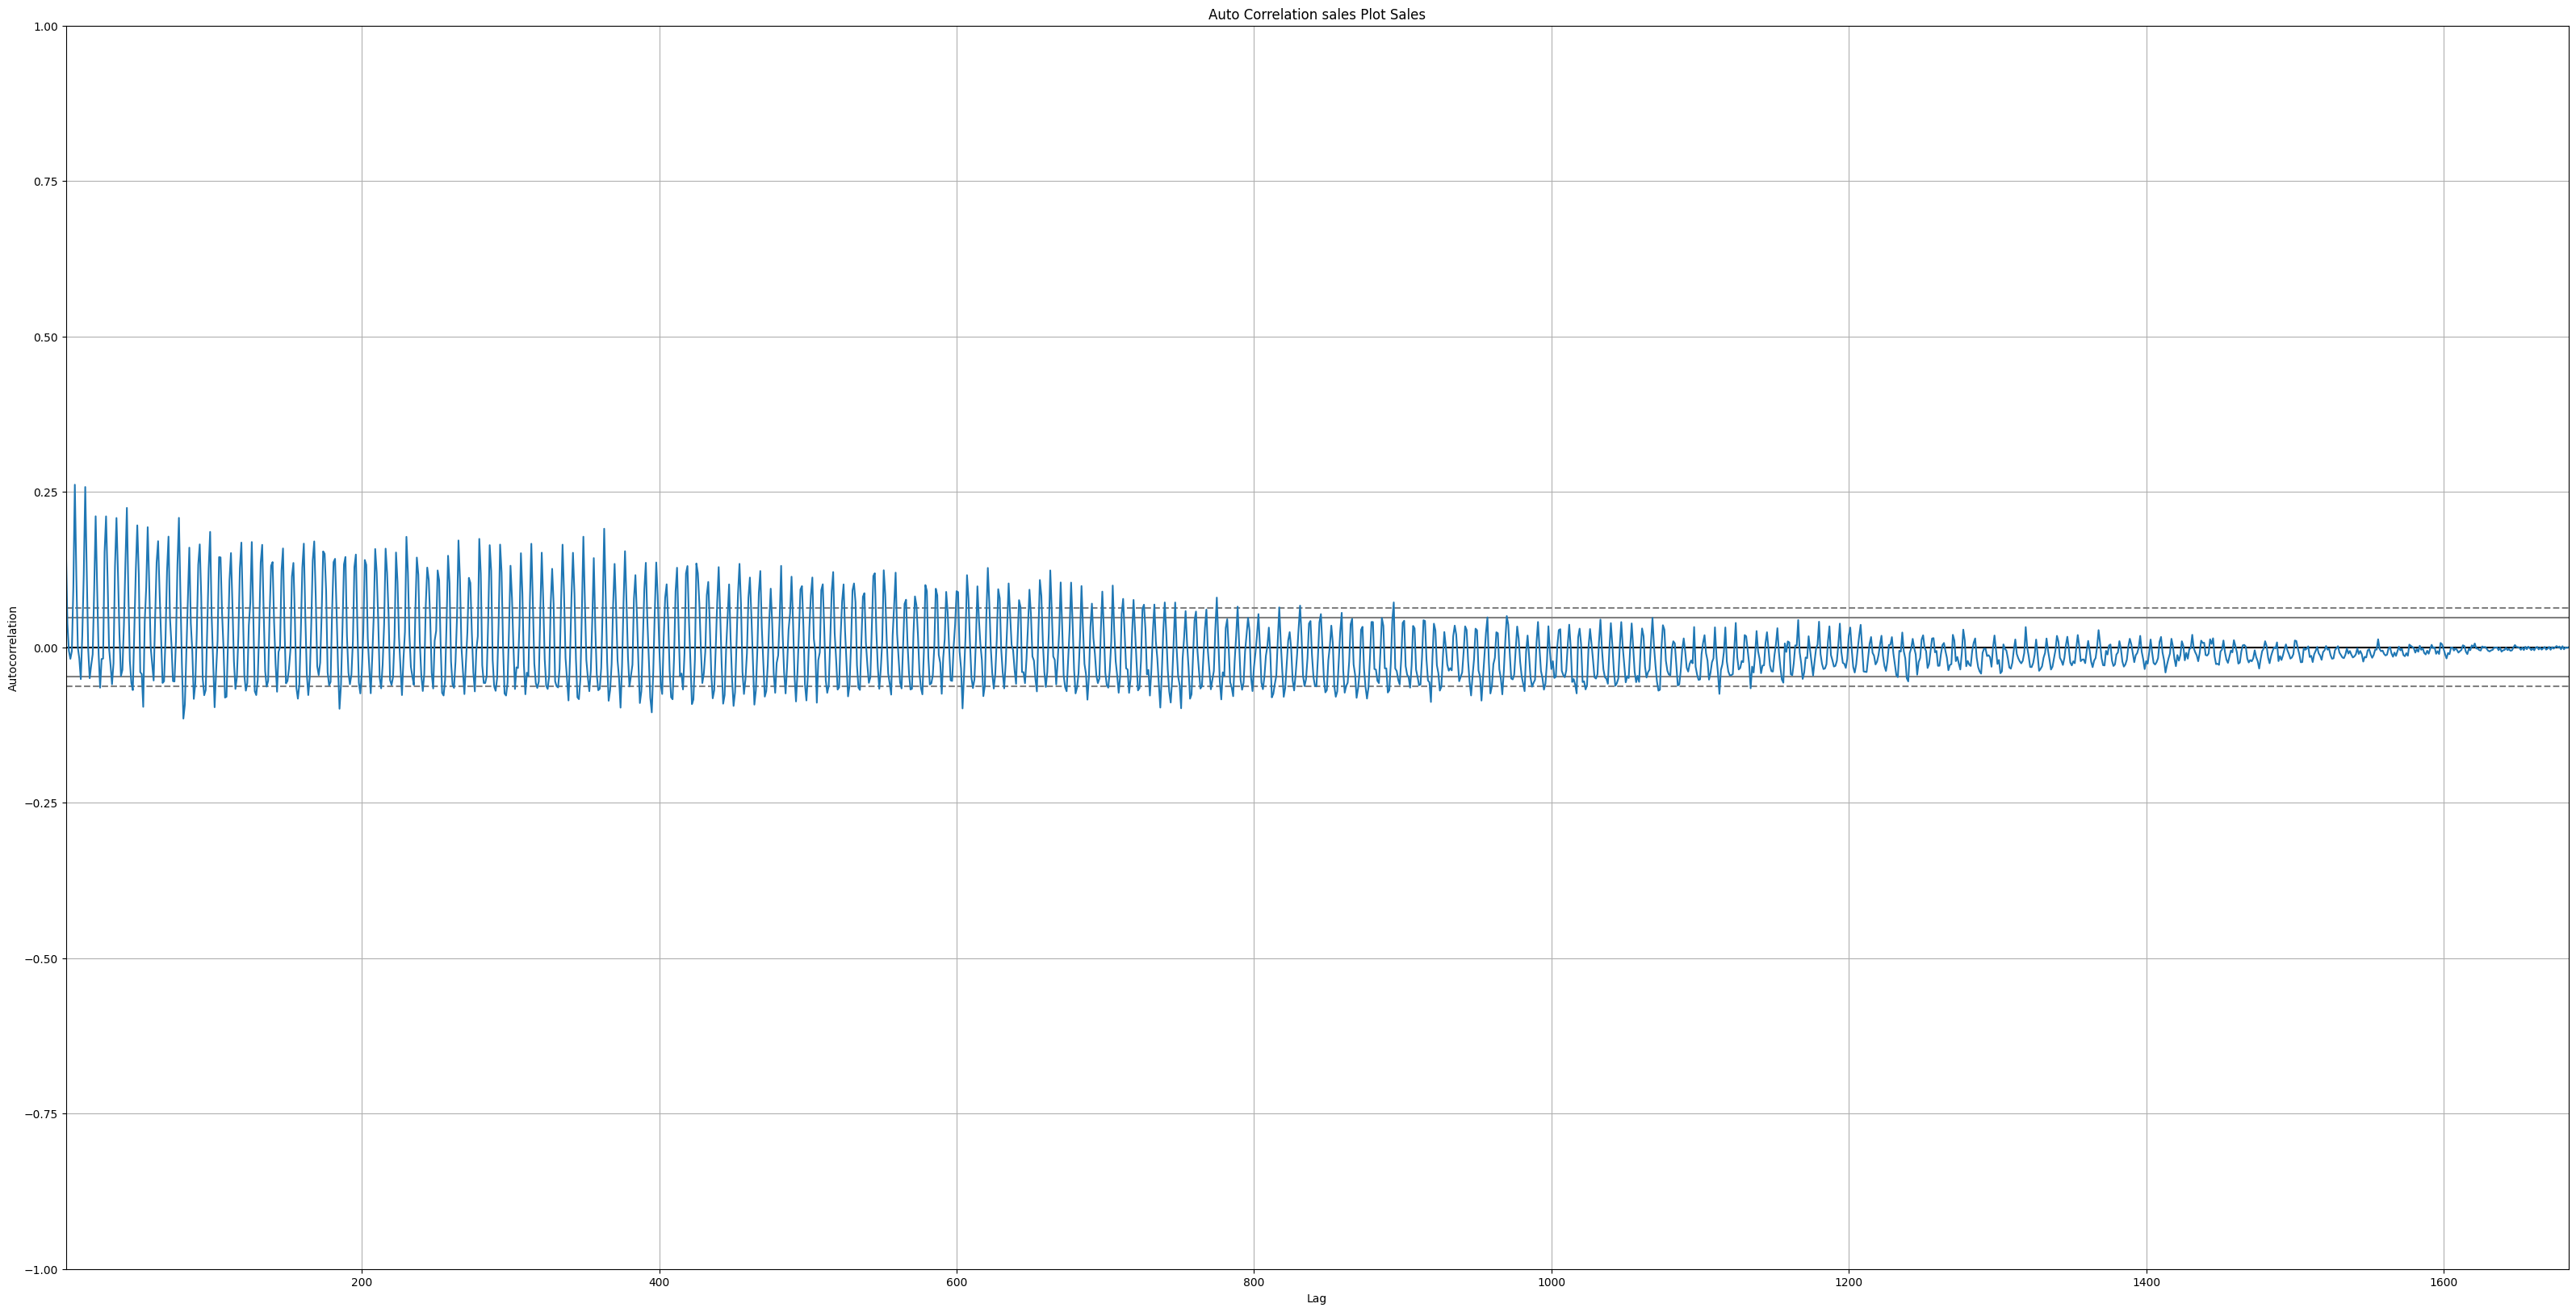

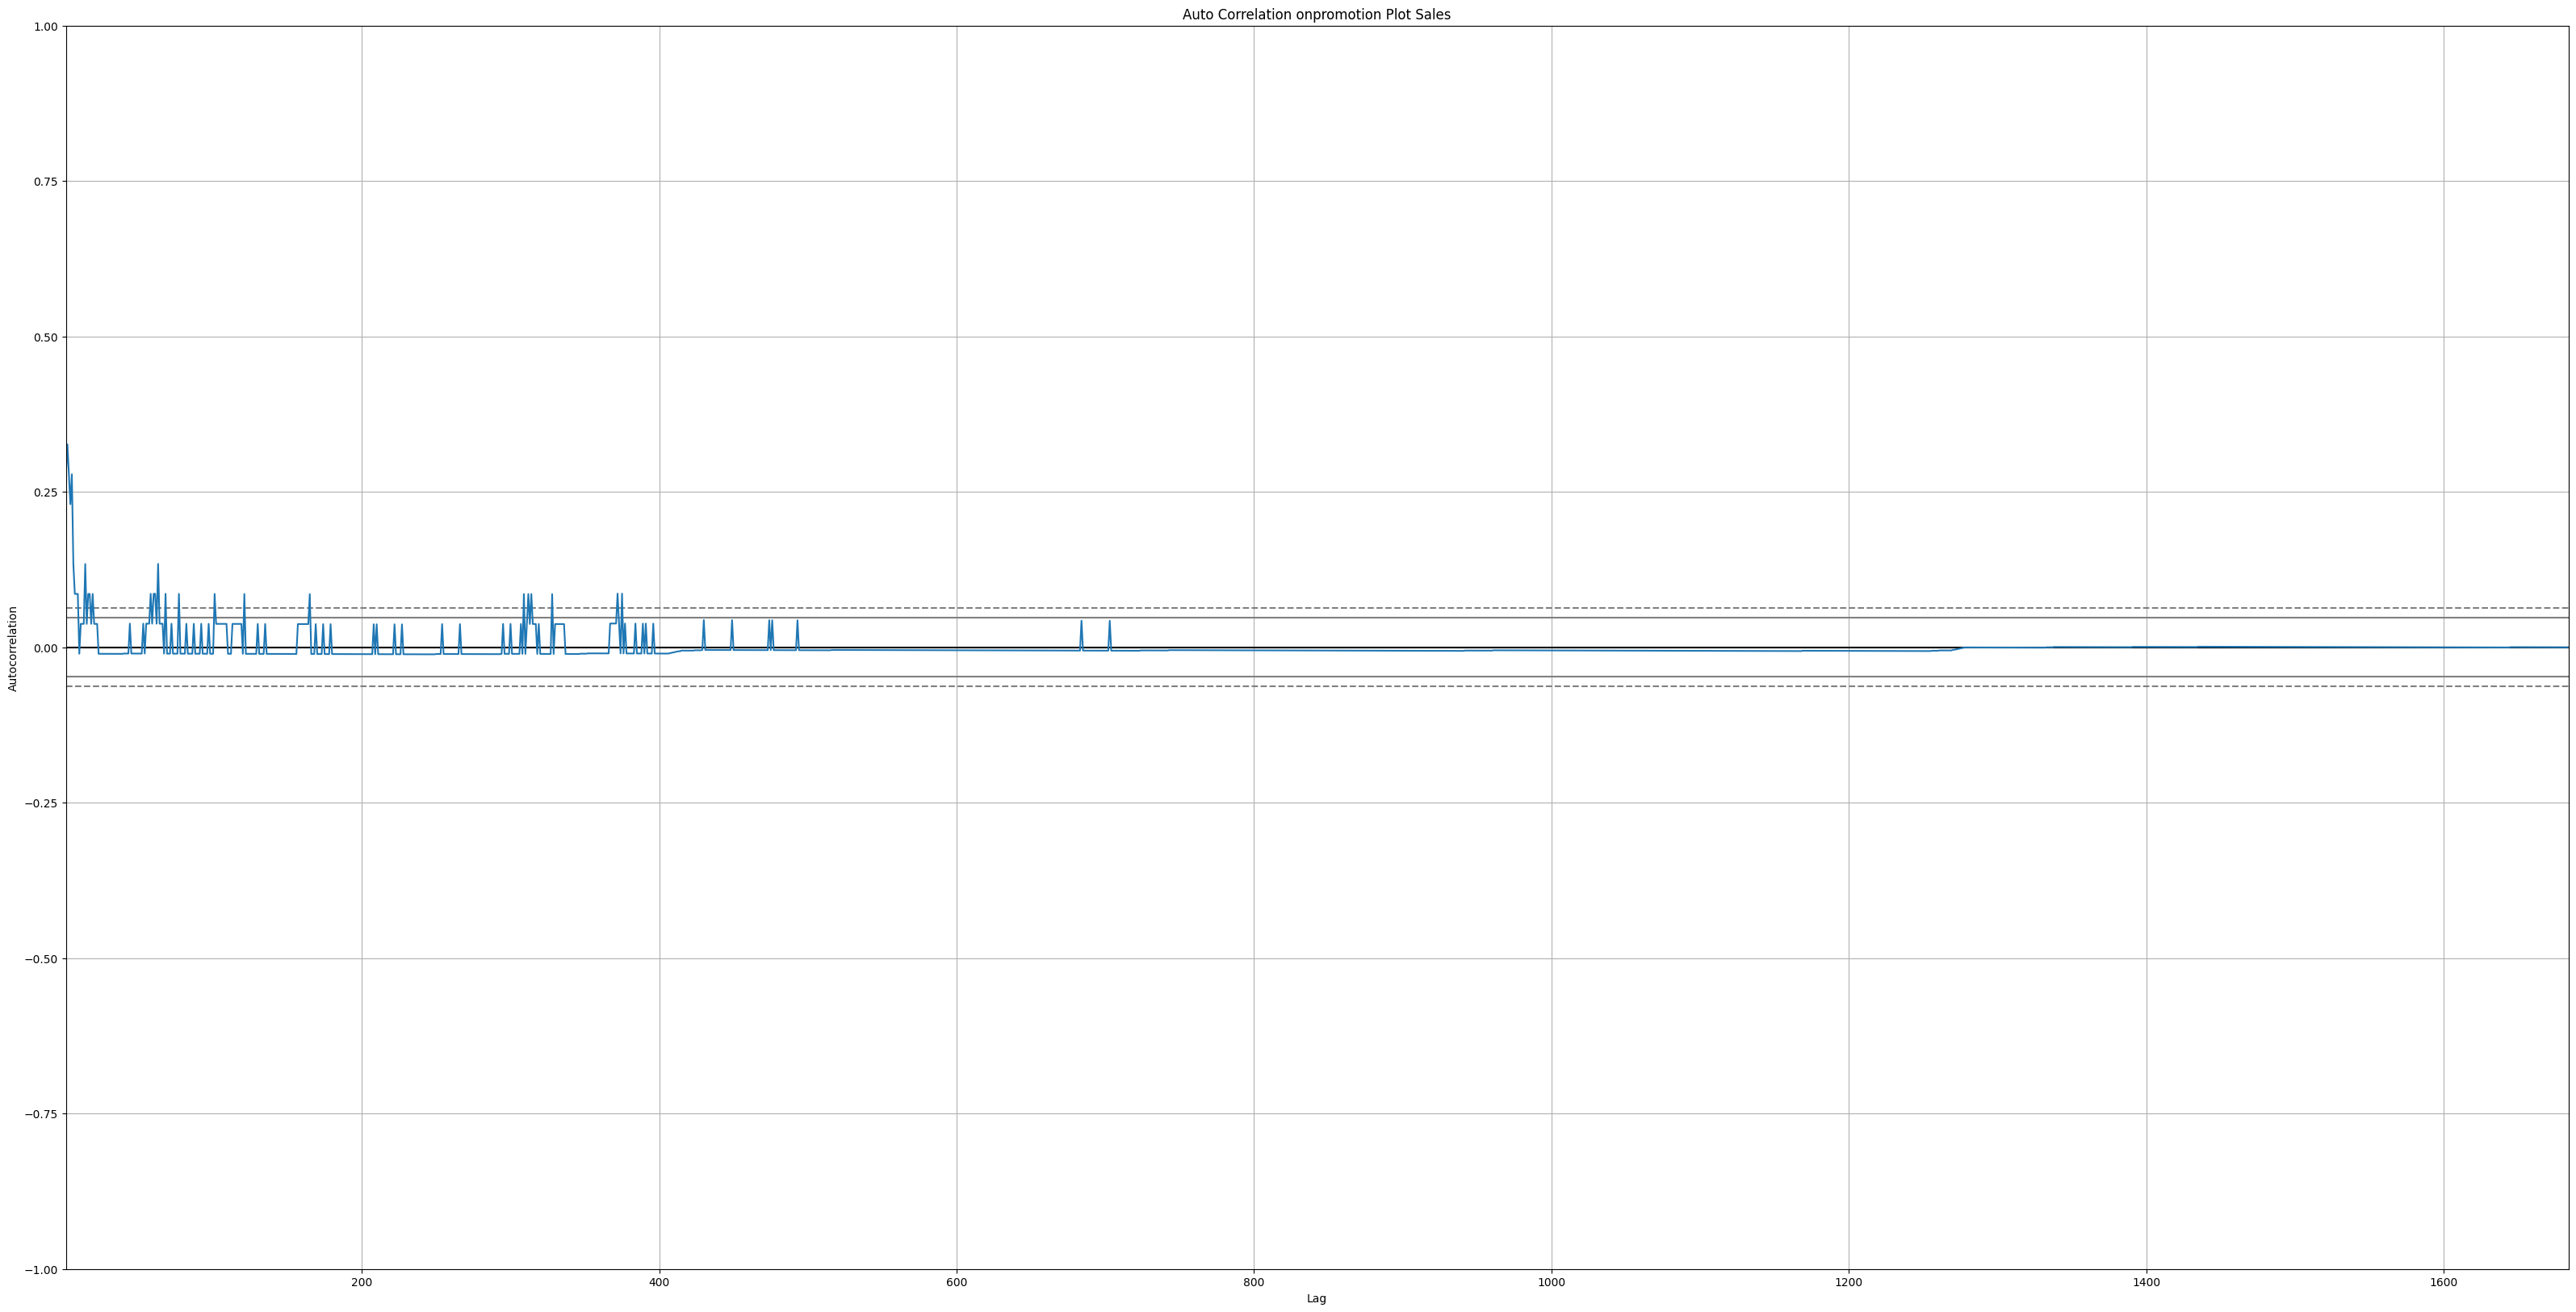

In [ ]:
# Auto Correlation Plot
features = ['sales', 'onpromotion']
for var in features:
  plt.figure(figsize=(40, 20))
  autocorrelation_plot(df_store_automotive_imp_int[var])
  plt.title(f'Auto Correlation {var} Plot Sales')
  plt.show()

#####2.1.1.E. ACF Plot

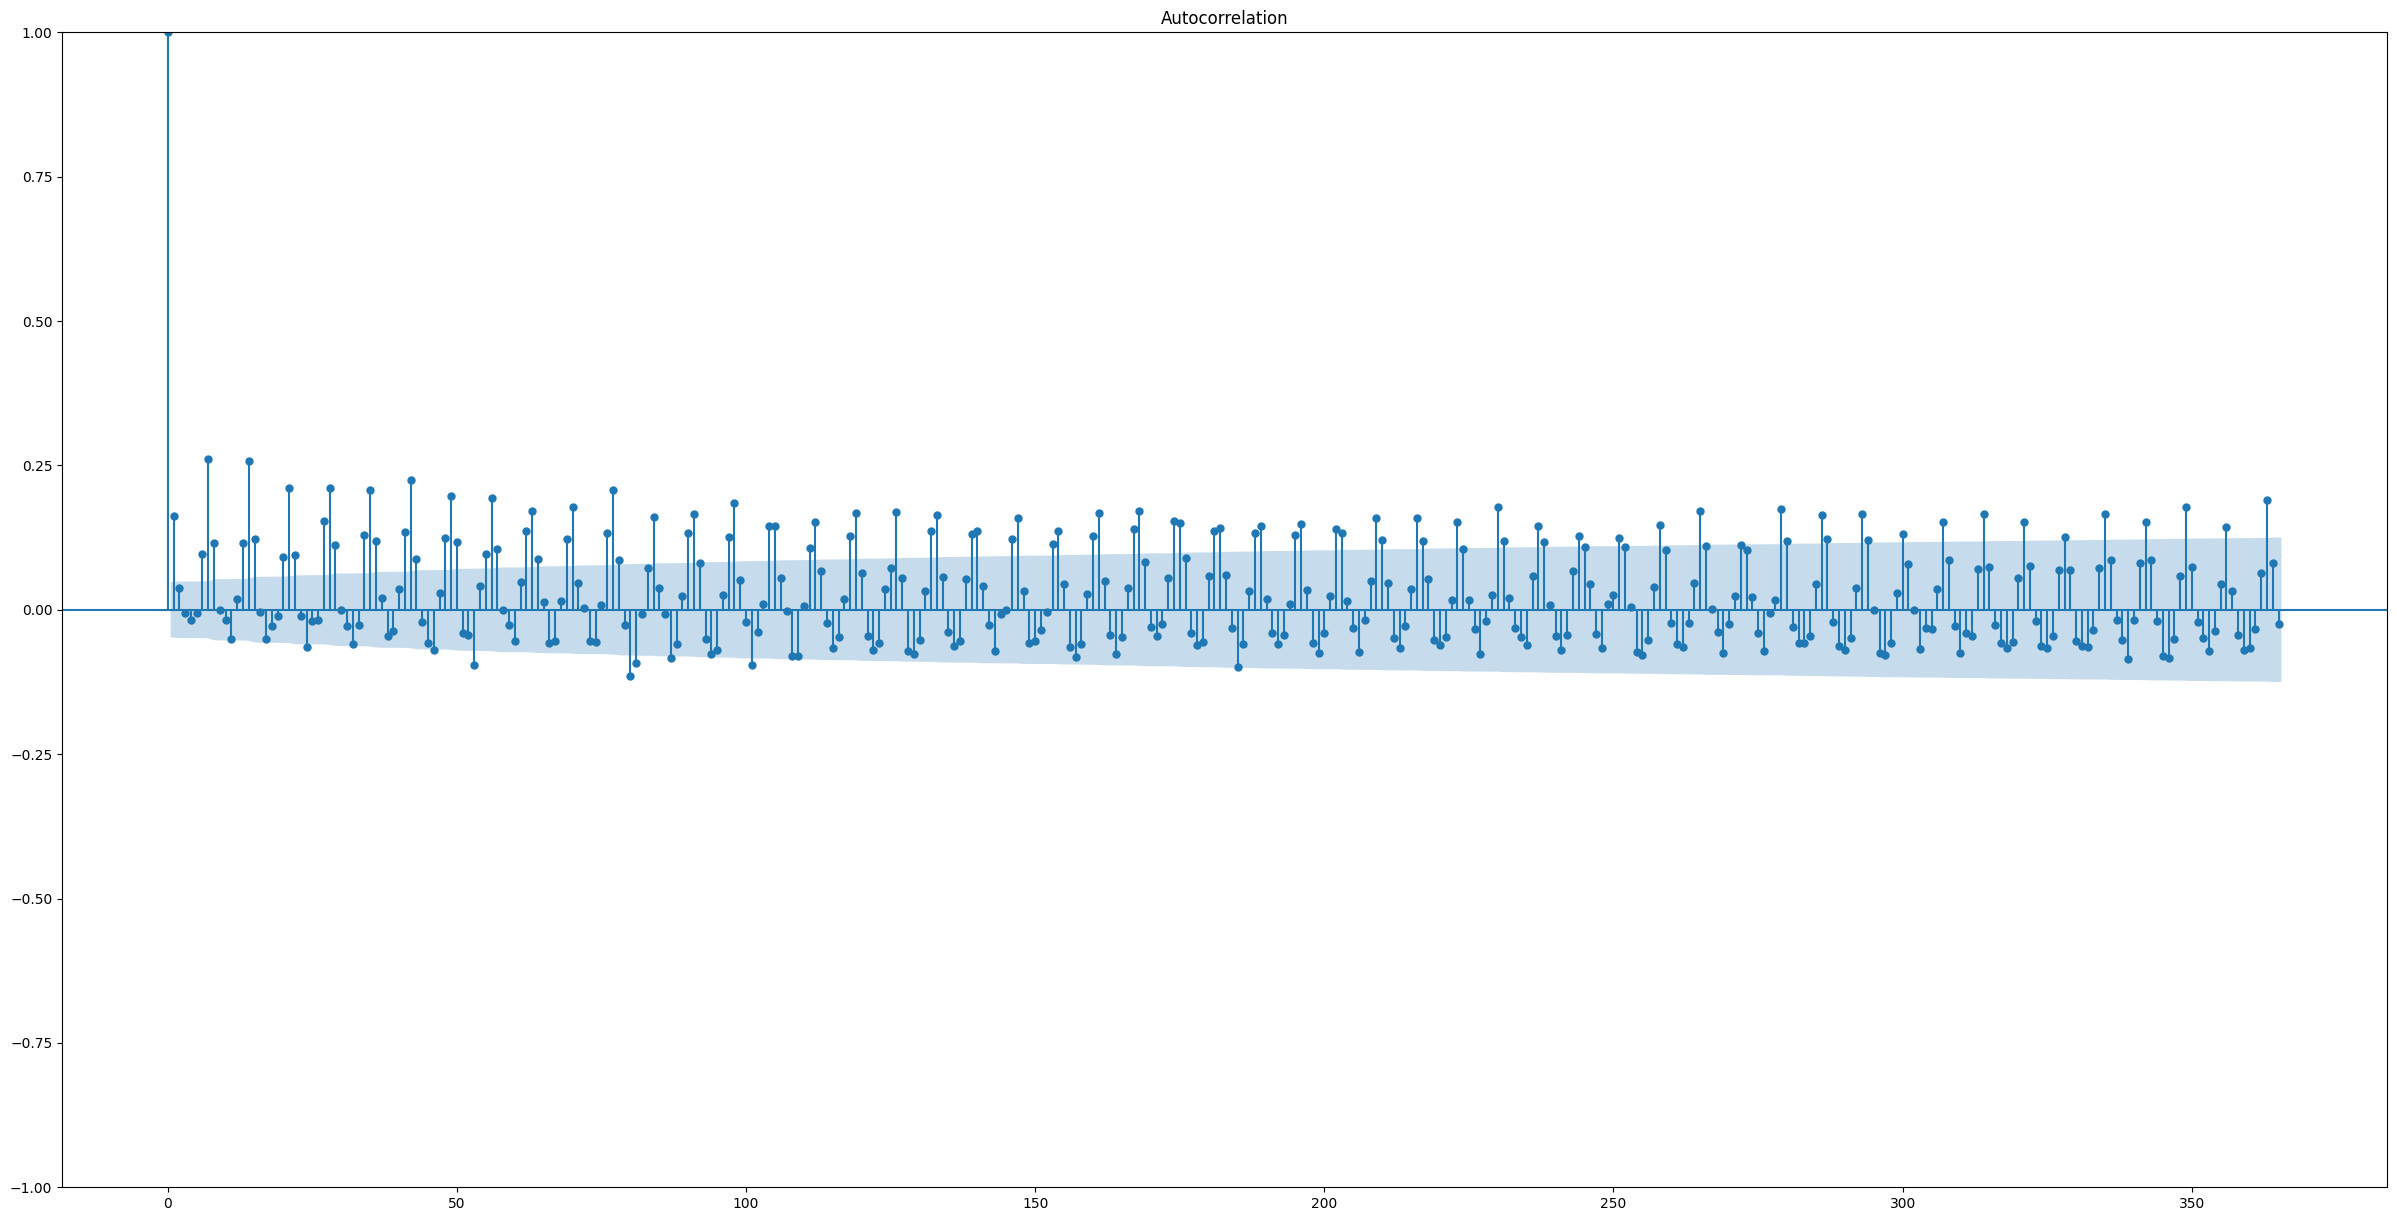

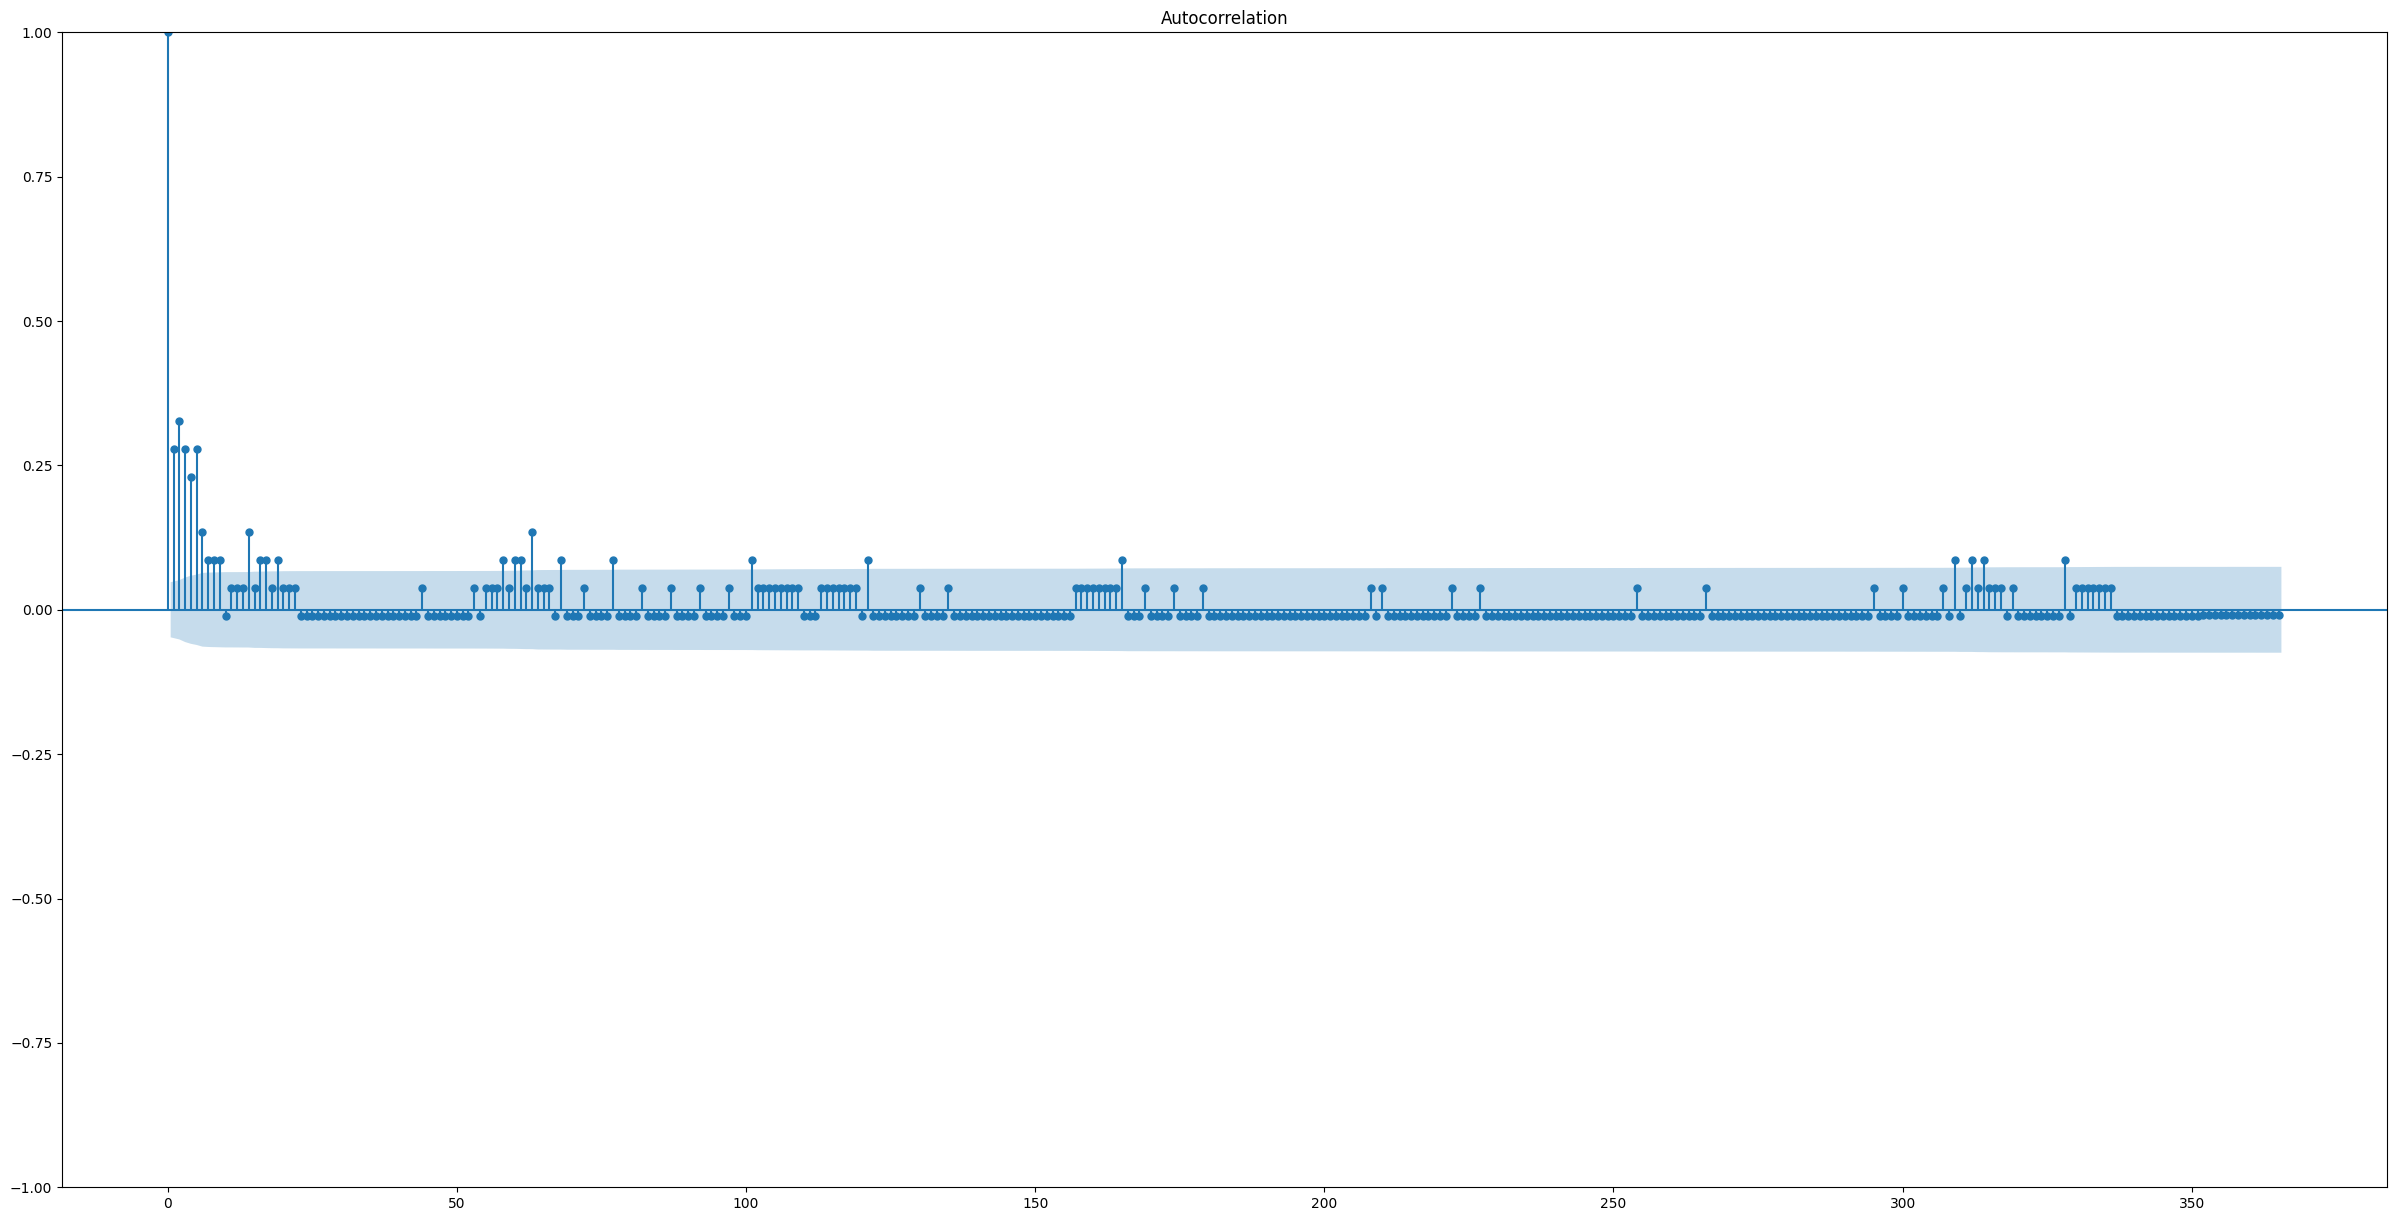

In [ ]:
features = ['sales', 'onpromotion']
for var in features:
  plot_acf(df_store_automotive_imp_int[var], lags=365)
  plt.show()

In [ ]:
#df_store_automotive_imp_int.reset_index(drop=True)

#####2.1.1.F. Plot ACF PACF

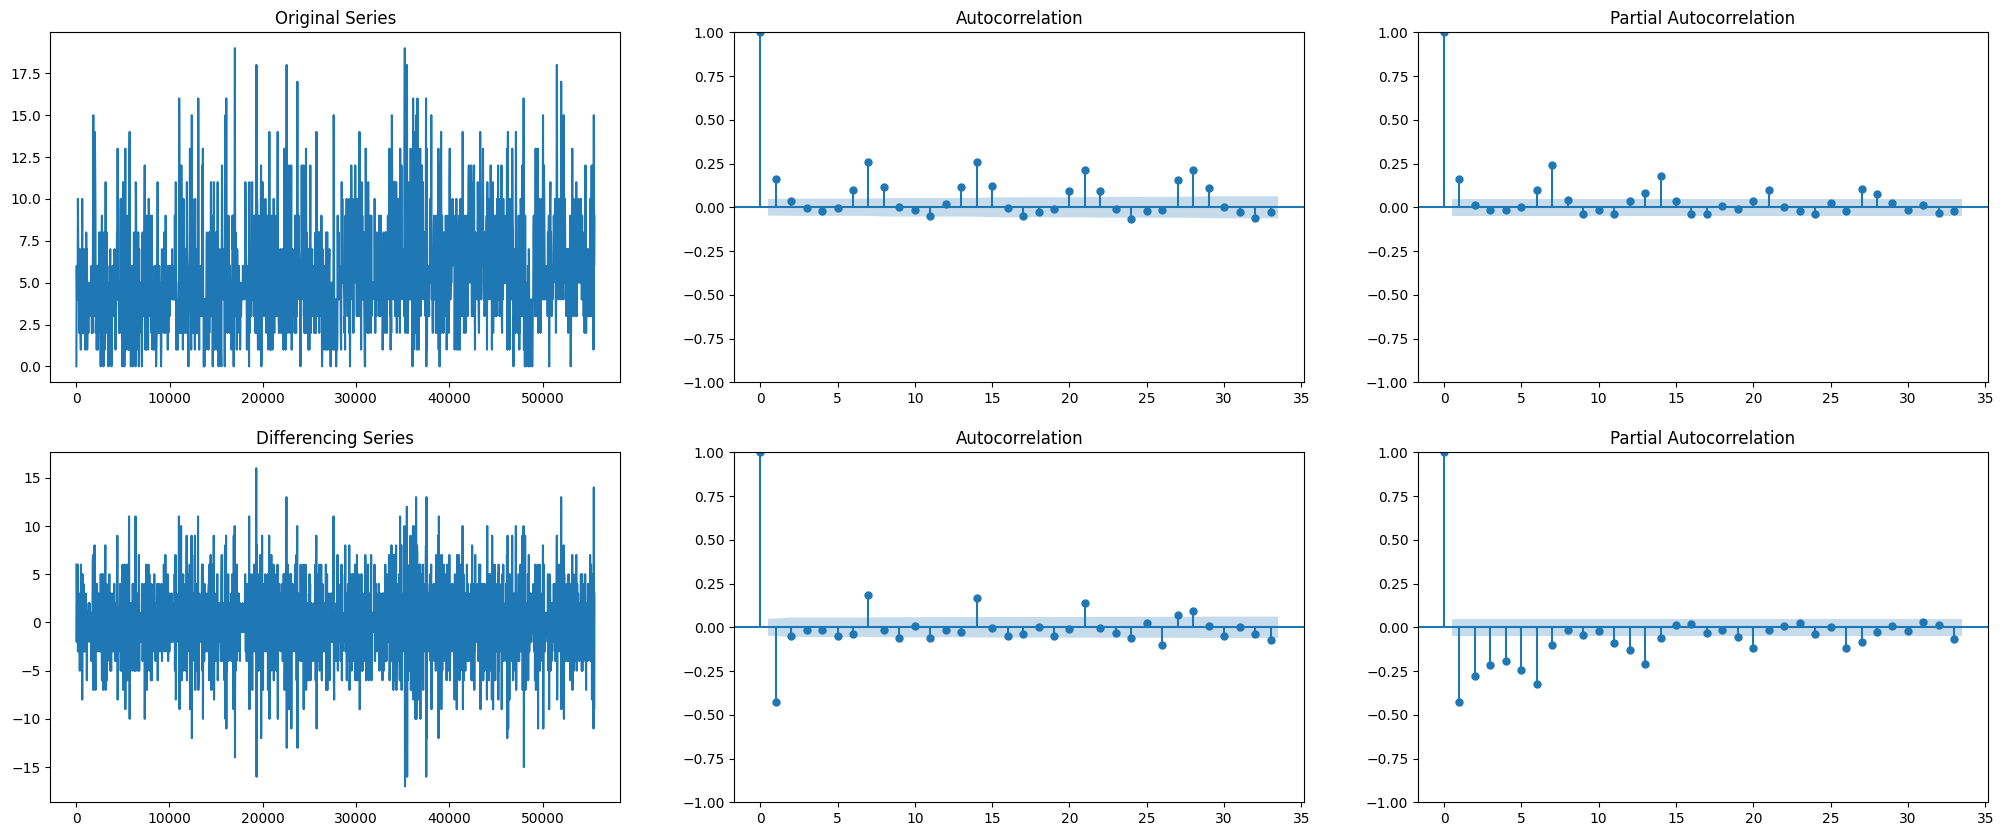

In [ ]:
#Plot ACF PACF feature 'sales'
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_store_automotive_imp_int['sales'])
ax[0, 1] = plot_acf(df_store_automotive_imp_int['sales'], ax=ax[0, 1])
ax[0, 2] = plot_pacf(df_store_automotive_imp_int['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_store_automotive_imp_int['sales'].diff().dropna())
ax[1, 1] = plot_acf(df_store_automotive_imp_int['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_pacf(df_store_automotive_imp_int['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

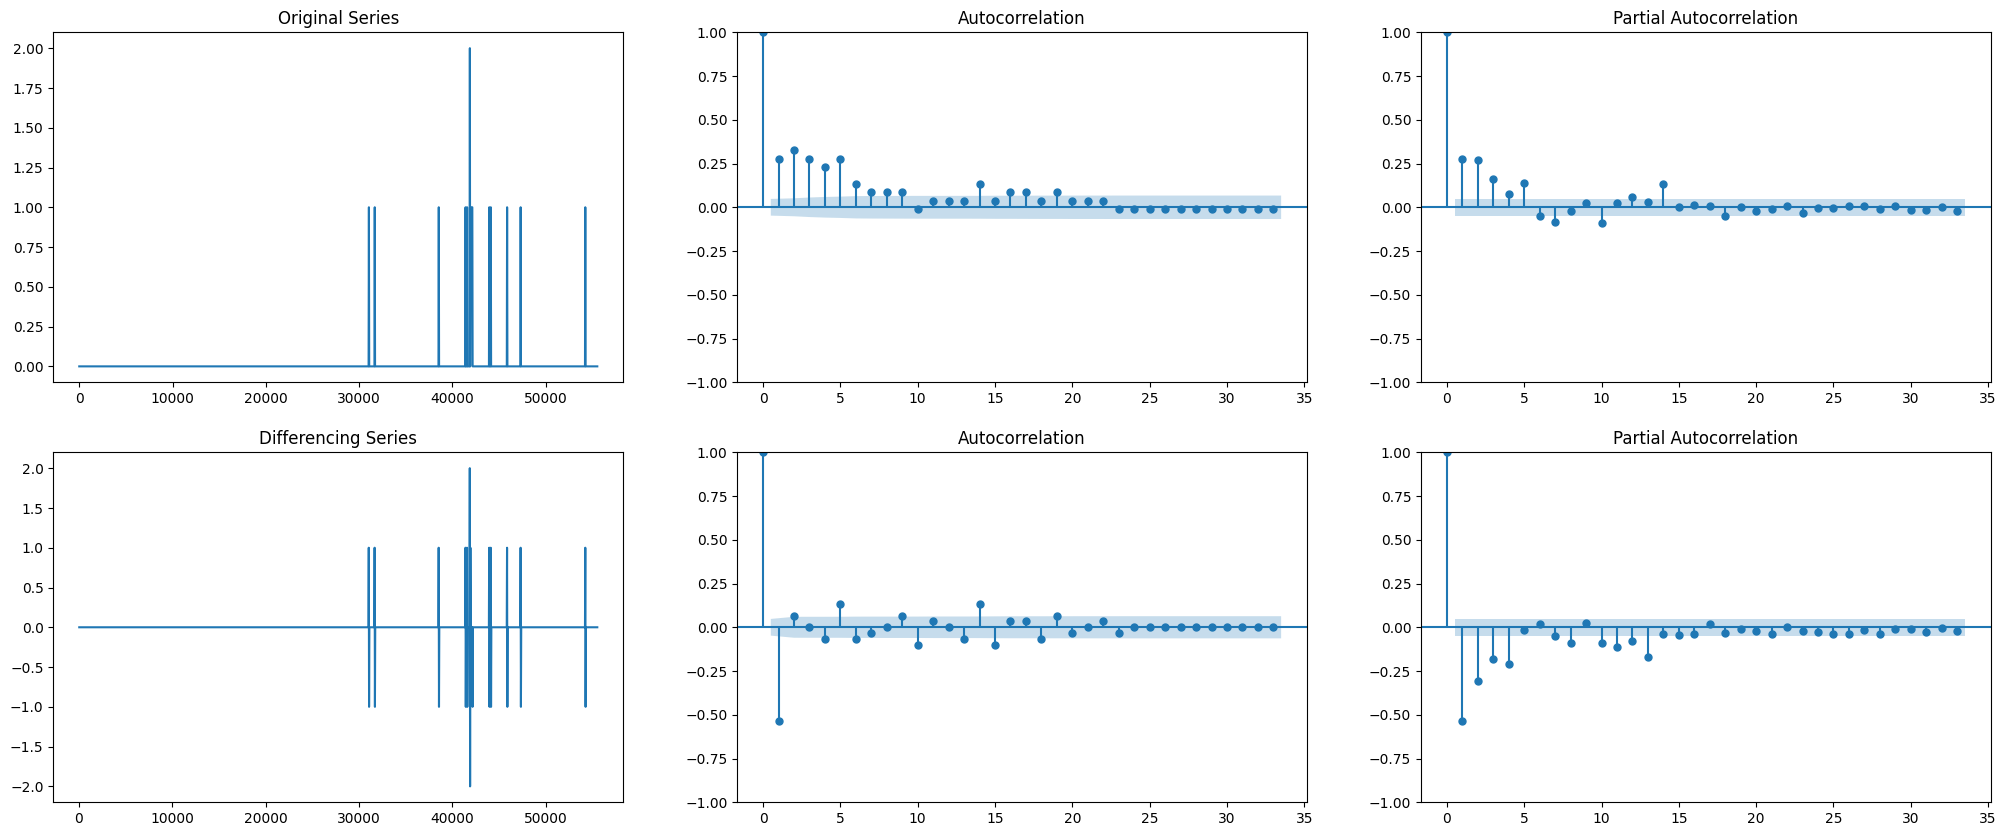

In [ ]:
#Plot ACF PACF feature 'onpromotion'
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_store_automotive_imp_int['onpromotion'])
ax[0, 1] = plot_acf(df_store_automotive_imp_int['onpromotion'], ax=ax[0, 1])
ax[0, 2] = plot_pacf(df_store_automotive_imp_int['onpromotion'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_store_automotive_imp_int['onpromotion'].diff().dropna())
ax[1, 1] = plot_acf(df_store_automotive_imp_int['onpromotion'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_pacf(df_store_automotive_imp_int['onpromotion'].diff().dropna(), ax=ax[1, 2])

plt.show()

#####2.1.1.G. Cek Stationarity Data

In [ ]:
for var in df_store_automotive_imp_int.columns:
  result_automotive = adfuller(df_store_automotive_imp_int[var])
  print(f'ADF Statistic {var}: %f' % result_automotive[0])
  print('p-value: %f' % result_automotive[1])

ADF Statistic date: 2.521772
p-value: 0.999057
ADF Statistic sales: -5.662511
p-value: 0.000001
ADF Statistic onpromotion: -7.680566
p-value: 0.000000
ADF Statistic dcoilwtico: -0.865176
p-value: 0.799224
ADF Statistic year: -0.500901
p-value: 0.891841
ADF Statistic month: -3.579220
p-value: 0.006171
ADF Statistic day: -26.867844
p-value: 0.000000


In [ ]:
df_store_automotive_imp_int.drop(columns=['month', 'day', 'year'], inplace=True)
df_store_automotive_imp_int

date  sales  onpromotion  dcoilwtico
0     2013-01-01    0.0            0   93.140000
33    2013-01-02    6.0            0   93.140000
66    2013-01-03    4.0            0   92.970000
99    2013-01-04    6.0            0   93.120000
132   2013-01-05    4.0            0   93.146667
...          ...    ...          ...         ...
55407 2017-08-11   12.0            0   48.810000
55440 2017-08-12    1.0            0   48.403333
55473 2017-08-13   15.0            0   47.996667
55506 2017-08-14    6.0            0   47.590000
55539 2017-08-15    9.0            0   47.570000

[1684 rows x 4 columns]

In [ ]:
df_store_automotive_imp_int = df_store_automotive_imp_int.set_index('date')

In [ ]:
for var in df_store_automotive_imp_int.columns:
  df_store_automotive_imp_int[var] = df_store_automotive_imp_int[var].diff().dropna()

In [ ]:
df_store_automotive_imp_int = df_store_automotive_imp_int.dropna()

In [ ]:
df_store_automotive.index[1]

33

In [ ]:
df_store_automotive_imp_int_addcol = df_store_automotive_imp_int.copy()
new_data = pd.DataFrame()
#Drop index ke-0 tujuannya untuk menyamakan jumlah row data yang sudah didifferencing
#karena pada data yang sudah didifferencing barisnya berkurang 1

new_data['day_of_week'] = df_store_automotive.drop(df_store_automotive.index[0])['date'].dt.day_name()
new_data['date'] = df_store_automotive.drop(df_store_automotive.index[0])['date']
new_data

day_of_week       date
33      Wednesday 2013-01-02
66       Thursday 2013-01-03
99         Friday 2013-01-04
132      Saturday 2013-01-05
165        Sunday 2013-01-06
...           ...        ...
55407      Friday 2017-08-11
55440    Saturday 2017-08-12
55473      Sunday 2017-08-13
55506      Monday 2017-08-14
55539     Tuesday 2017-08-15

[1683 rows x 2 columns]

In [ ]:
new_data = new_data.set_index('date')

In [ ]:
df_dummies = pd.get_dummies(new_data['day_of_week'])

df_store_automotive_imp_int_addcol = pd.concat([df_store_automotive_imp_int_addcol, df_dummies], axis=1)
df_store_automotive_imp_int_addcol

sales  onpromotion  dcoilwtico  Friday  Monday  Saturday  Sunday  \
date                                                                           
2013-01-02    6.0          0.0    0.000000   False   False     False   False   
2013-01-03   -2.0          0.0   -0.170000   False   False     False   False   
2013-01-04    2.0          0.0    0.150000    True   False     False   False   
2013-01-05   -2.0          0.0    0.026667   False   False      True   False   
2013-01-06    6.0          0.0    0.026667   False   False     False    True   
...           ...          ...         ...     ...     ...       ...     ...   
2017-08-11    5.0          0.0    0.270000    True   False     False   False   
2017-08-12  -11.0          0.0   -0.406667   False   False      True   False   
2017-08-13   14.0          0.0   -0.406667   False   False     False    True   
2017-08-14   -9.0          0.0   -0.406667   False    True     False   False   
2017-08-15    3.0          0.0   -0.020000   False   False     False   False   

            Thursday  Tuesday  Wednesday  
date                                      
2013-01-02     False    False       True  
2013-01-03      True    False      False  
2013-01-04     False    False      False  
2013-01-05     False    False      False  
2013-01-06     False    False      False  
...              ...      ...        ...  
2017-08-11     False    False      False  
2017-08-12     False    False      False  
2017-08-13     False    False      False  
2017-08-14     False    False      False  
2017-08-15     False     True      False  

[1683 rows x 10 columns]

In [ ]:
days = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
for day in days:
  df_store_automotive_imp_int_addcol[day] = df_store_automotive_imp_int_addcol[day].astype(int)
df_store_automotive_imp_int_addcol

sales  onpromotion  dcoilwtico  Friday  Monday  Saturday  Sunday  \
date                                                                           
2013-01-02    6.0          0.0    0.000000       0       0         0       0   
2013-01-03   -2.0          0.0   -0.170000       0       0         0       0   
2013-01-04    2.0          0.0    0.150000       1       0         0       0   
2013-01-05   -2.0          0.0    0.026667       0       0         1       0   
2013-01-06    6.0          0.0    0.026667       0       0         0       1   
...           ...          ...         ...     ...     ...       ...     ...   
2017-08-11    5.0          0.0    0.270000       1       0         0       0   
2017-08-12  -11.0          0.0   -0.406667       0       0         1       0   
2017-08-13   14.0          0.0   -0.406667       0       0         0       1   
2017-08-14   -9.0          0.0   -0.406667       0       1         0       0   
2017-08-15    3.0          0.0   -0.020000       0       0         0       0   

            Thursday  Tuesday  Wednesday  
date                                      
2013-01-02         0        0          1  
2013-01-03         1        0          0  
2013-01-04         0        0          0  
2013-01-05         0        0          0  
2013-01-06         0        0          0  
...              ...      ...        ...  
2017-08-11         0        0          0  
2017-08-12         0        0          0  
2017-08-13         0        0          0  
2017-08-14         0        0          0  
2017-08-15         0        1          0  

[1683 rows x 10 columns]

Variasi 1 (Tanpa Pola Seasonal)

In [ ]:
endog_vars_automotive_int = df_store_automotive_imp_int[['sales', 'onpromotion']].diff().dropna()  # Endogenous variables
exog_vars_automotive_int = df_store_automotive_imp_int['dcoilwtico'].diff().dropna()  # Exogenous variable

train_size_automotive_int = int(0.8 * len(df_store_automotive_imp_int))
endog_train_automotive_int, endog_test_automotive_int = endog_vars_automotive_int.iloc[:train_size_automotive_int], endog_vars_automotive_int.iloc[train_size_automotive_int:]
exog_train_automotive_int, exog_test_automotive_int = exog_vars_automotive_int.iloc[:train_size_automotive_int], exog_vars_automotive_int.iloc[train_size_automotive_int:]

In [ ]:
AIC_auto_int = []
BIC_auto_int = []
for p in range(2):
  for q in range(2):
    model_auto_int = VARMAX(endog_train_automotive_int, exog=exog_train_automotive_int, order=(p+1, q+1))
    results_auto_int = model_auto_int.fit(disp=False)
    AIC_auto_int.append(results_auto_int.aic)
    BIC_auto_int.append(results_auto_int.bic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically

In [ ]:
result_automotive_int = pd.DataFrame(AIC_auto_int, columns=['AIC'])
result_automotive_int['BIC'] = pd.DataFrame(BIC_auto_int)
result_automotive_int

AIC          BIC
0  5781.933045  5860.006433
1  6013.651087  6112.544045
2  5370.723859  5469.616816
3  5597.382471  5717.094999

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         sales  onpromotion
1346  6.874712    -0.008200
1347 -1.155610    -0.000722
1348 -0.824538     0.023402
1349  0.621389    -0.025805
1350 -0.124837     0.016430
...        ...          ...
1677 -0.038549     0.014865
1678  0.040388    -0.010332
1679  0.004408     0.003281
1680  0.017021     0.001185
1681 -0.005829     0.000749

[336 rows x 2 columns]
                              Statespace Model Results                              
Dep. Variable:     ['sales', 'onpromotion']   No. Observations:                 1346
Model:                          VARMAX(2,1)   Log Likelihood               -2666.362
                                + intercept   AIC                           5370.724
Date:                      Fri, 04 Oct 2024   BIC                           5469.617
Time:                              08:06:02   HQIC                          5407.765
Sample:                                   0                                         
                                     - 1346  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

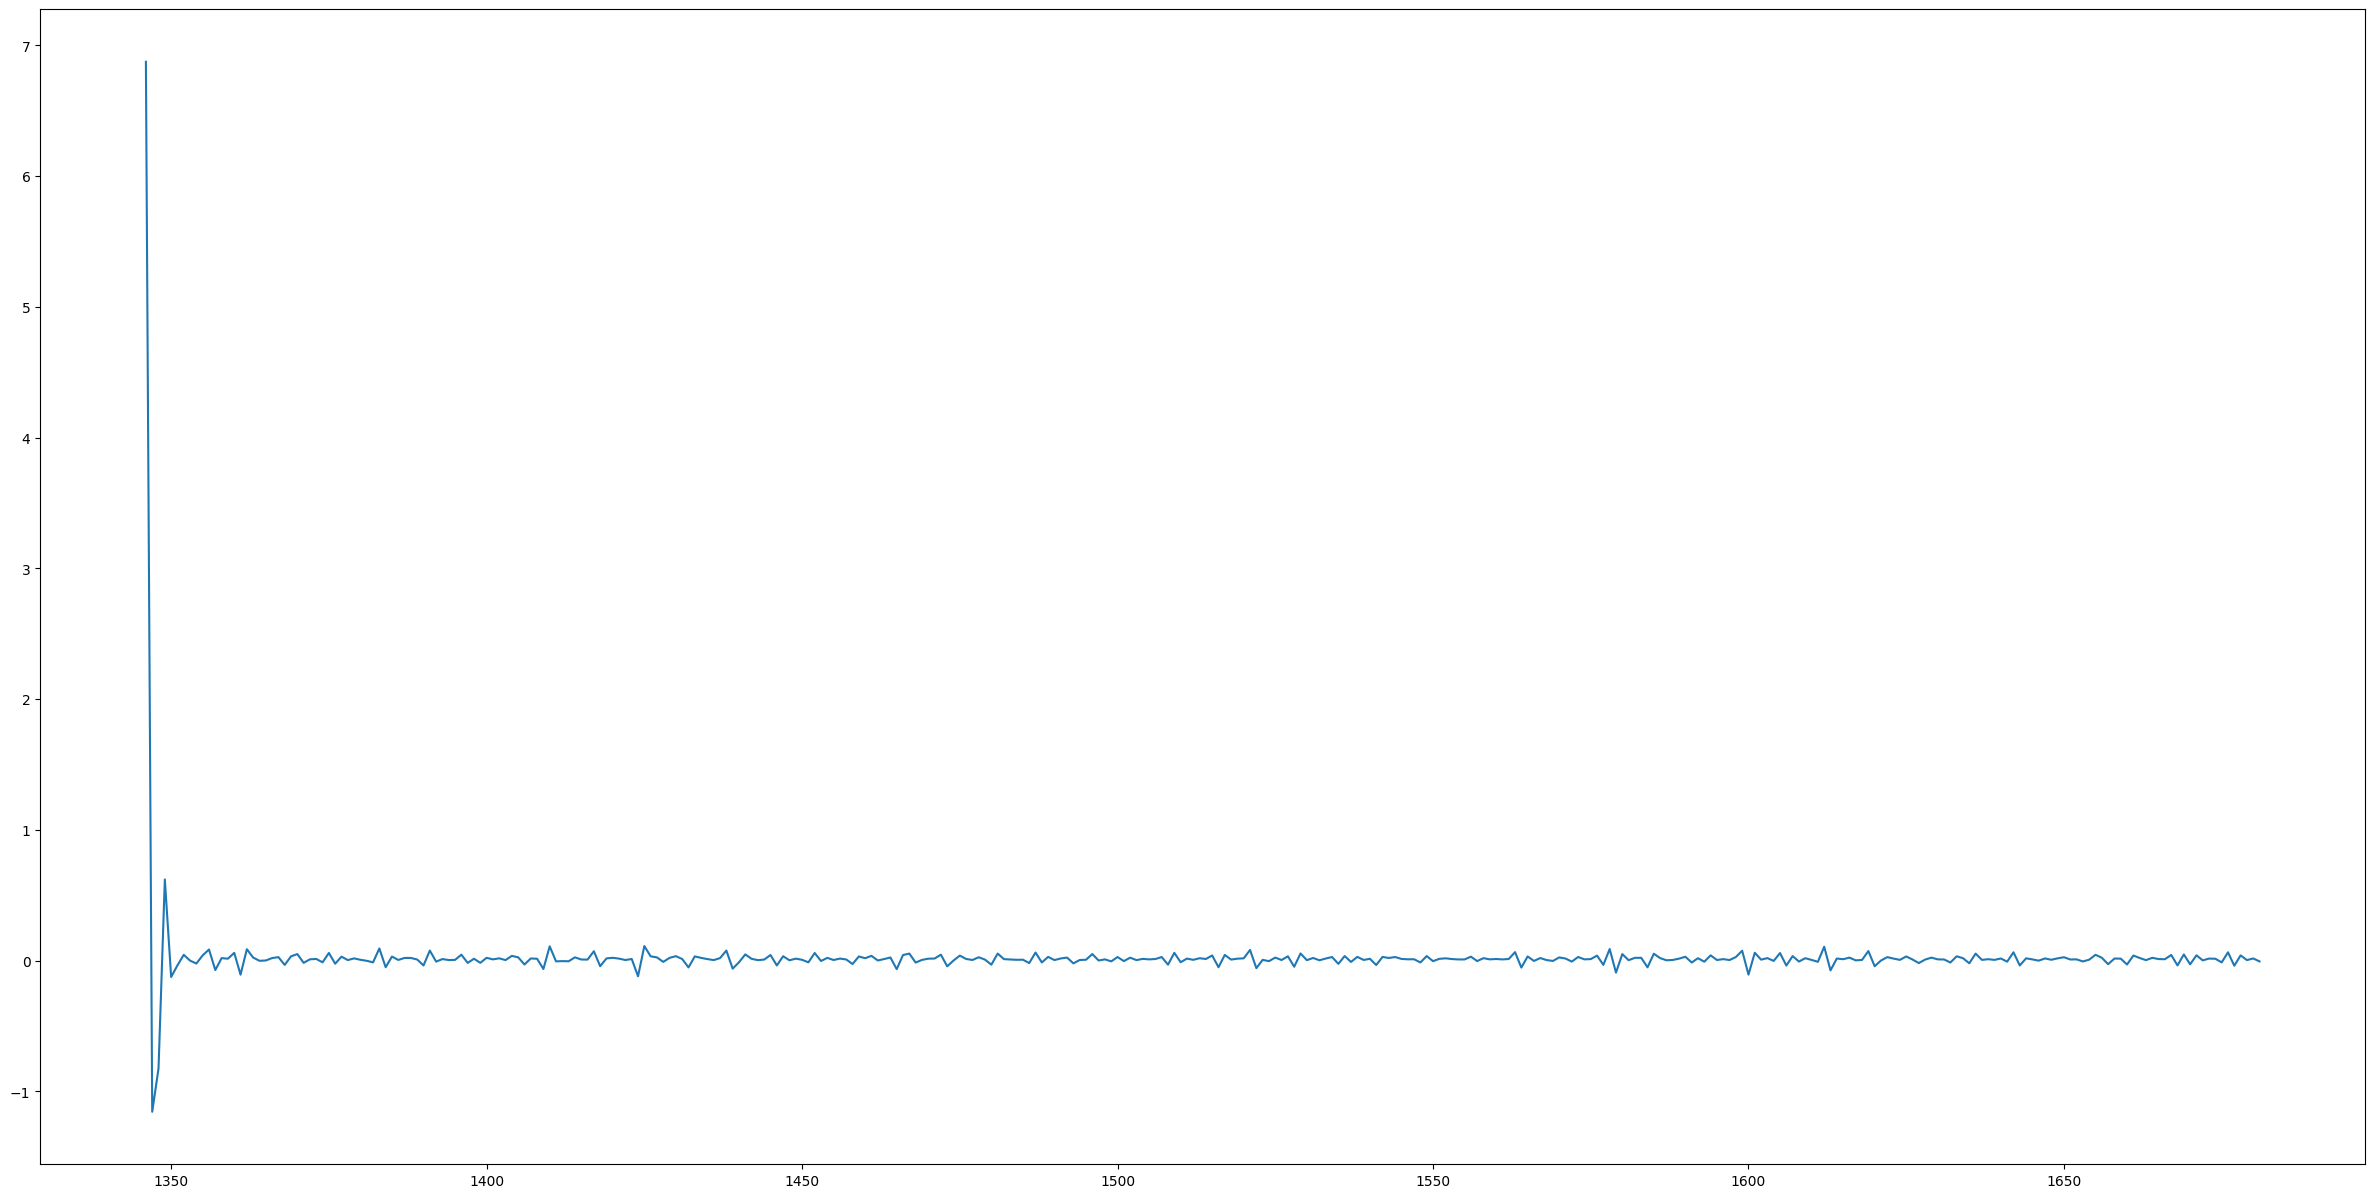

In [ ]:
model_final_auto_int = VARMAX(endog_train_automotive_int, exog=exog_train_automotive_int, order=(2, 1))
fitted_model_final_auto_int = model_final_auto_int.fit(disp=False)
forecast_auto_int = fitted_model_final_auto_int.forecast(steps=len(exog_test_automotive_int), exog=exog_test_automotive_int)
print(forecast_auto_int)
print(fitted_model_final_auto_int.summary())

plt.plot(forecast_auto_int.index, forecast_auto_int.sales)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

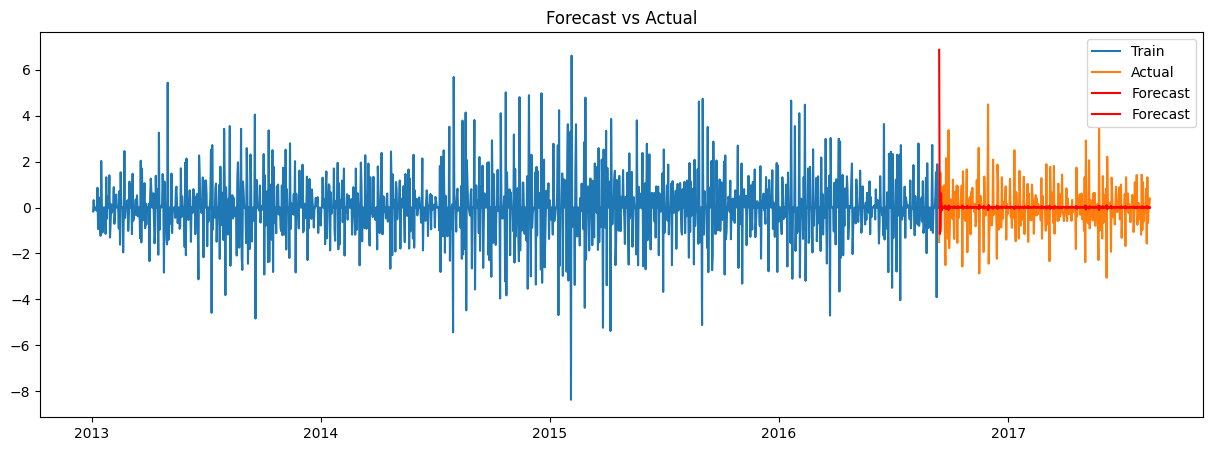

In [ ]:
# Prediction
forecast_auto_int = fitted_model_final_auto_int.predict(start=len(exog_train_automotive_int), end=len(exog_train_automotive_int)+len(exog_test_automotive_int)-1, exog=exog_test_automotive_int, typ='levels')
forecast_auto_int.index = exog_test_automotive_int.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_automotive_int, label='Train')
plt.plot(exog_test_automotive_int, label='Actual')
plt.plot(forecast_auto_int, label='Forecast', color='r')
plt.legend()

Variasi 2 (Dengan Pola Seasonal)

In [ ]:
endog_vars_automotive_int2 = df_store_automotive_imp_int_addcol[['sales', 'onpromotion']]  # Endogenous variables
exog_vars_automotive_int2 = df_store_automotive_imp_int_addcol[['dcoilwtico','Friday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Sunday', 'Thursday']]# Exogenous variable

train_size_automotive_int = int(0.8 * len(df_store_automotive_imp_int_addcol))
endog_train_automotive_int2, endog_test_automotive_int2 = endog_vars_automotive_int2.iloc[:train_size_automotive_int], endog_vars_automotive_int2.iloc[train_size_automotive_int:]
exog_train_automotive_int2, exog_test_automotive_int2 = exog_vars_automotive_int2.iloc[:train_size_automotive_int], exog_vars_automotive_int2.iloc[train_size_automotive_int:]

In [ ]:
AIC_auto_int2 = []
BIC_auto_int2 = []
for p in range(2):
  for q in range(2):
    model_auto_int2 = VARMAX(endog_train_automotive_int2, exog=exog_train_automotive_int2, order=(p+1, q+1))
    results_auto_int2 = model_auto_int2.fit(disp=False)
    AIC_auto_int2.append(results_auto_int2.aic)
    BIC_auto_int2.append(results_auto_int2.bic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically

In [ ]:
result_automotive_int2 = pd.DataFrame(AIC_auto_int2, columns=['AIC'])
result_automotive_int2['BIC'] = pd.DataFrame(BIC_auto_int2)
result_automotive_int2

AIC          BIC
0  4483.896031  4634.837914
1  4510.754246  4682.515699
2  4572.877559  4744.639012
3  4634.658719  4827.239742

In [ ]:
model_final_auto_int2 = VARMAX(endog_train_automotive_int2, exog=exog_train_automotive_int2, order=(1, 1))
fitted_model_final_auto_int2 = model_final_auto_int2.fit(disp=False)
forecast_auto_int2 = fitted_model_final_auto_int2.forecast(steps=len(exog_test_automotive_int2), exog=exog_test_automotive_int2)
print(forecast_auto_int2)
print(fitted_model_final_auto_int2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         sales  onpromotion
1346 -4.647830     0.003194
1347 -1.359881    -0.011885
1348 -0.099833     0.006791
1349 -1.229933     0.001455
1350  0.934182     0.005472
...        ...          ...
1678  0.934267     0.007321
1679  2.176728    -0.004491
1680  3.213351     0.023840
1681 -3.628708    -0.031538
1682 -1.359599    -0.004081

[337 rows x 2 columns]
                              Statespace Model Results                              
Dep. Variable:     ['sales', 'onpromotion']   No. Observations:                 1346
Model:                          VARMAX(1,1)   Log Likelihood               -2212.948
                                + intercept   AIC                           4483.896
Date:                      Fri, 04 Oct 2024   BIC                           4634.838
Time:                              05:59:29   HQIC                          4540.432
Sample:                                   0                                         
                                     - 1346  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

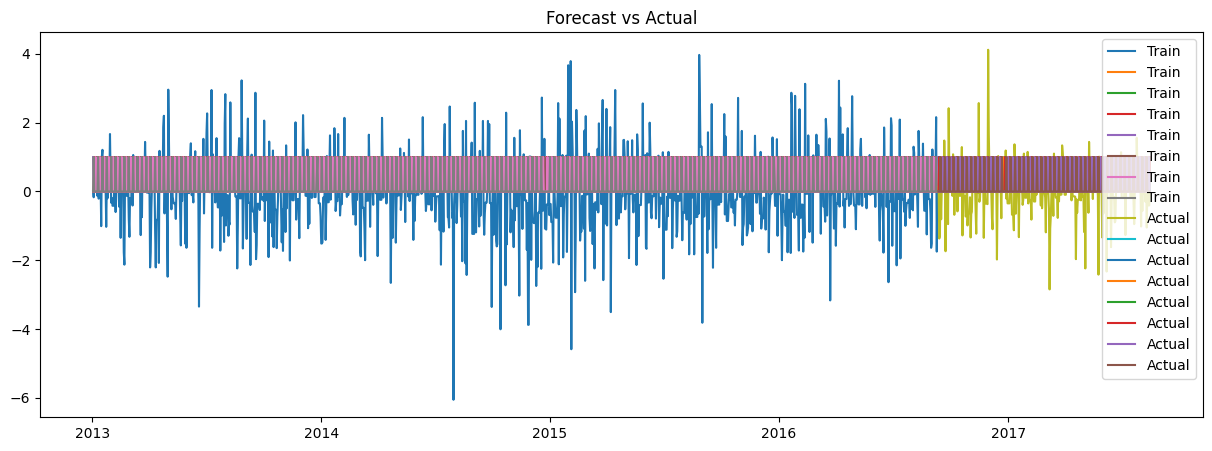

In [ ]:
# Prediction
predict_auto_int2 = fitted_model_final_auto_int2.predict(start=len(exog_train_automotive_int2), end=len(exog_train_automotive_int2)+len(exog_test_automotive_int2)-1, exog=exog_test_automotive_int2, typ='levels')
predict_auto_int2.index = exog_test_automotive_int2.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_automotive_int2, label='Train')
plt.plot(exog_test_automotive_int2, label='Actual')
#plt.plot(forecast_auto_int, label='Forecast', color='r')
plt.legend()

Variasi 3 (Periode Testing 1 tahun)

In [ ]:
df_store_automotive_v2 = df_store_automotive[df_store_automotive['date'] < '2016-08-15']

In [ ]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
var1 = endog_test_automotive_int['sales'].reset_index().drop(columns='date')
var1

In [ ]:
var2 = forecast_auto_int['sales'].reset_index().drop(columns='index')
var2

In [ ]:
calculate_mape(var1, var2)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mse = mean_squared_error(var1, var2)
mse

####2.1.2 AUTOMOTIVE Forward Fill

In [ ]:
df_store_automotive_imp_fwd = df_store_automotive.ffill()
df_store_automotive_imp_fwd

In [ ]:
missing_mask_automotive = df_store_automotive['dcoilwtico'].isna()

plt.figure(figsize=(80, 80))
plt.plot(df_store_automotive.index, df_store_automotive['dcoilwtico'], linestyle='-', color='blue', label='Original Data', lw=2)
plt.plot(df_store_automotive.index[missing_mask_automotive], df_store_automotive_imp_fwd.loc[missing_mask_automotive, 'dcoilwtico'], linestyle='-', color='yellow', label='Imputed Data', lw=5)

missing_indices_automotive = df_store_automotive_imp_fwd.isna()
plt.scatter(df_store_automotive.index[missing_mask_automotive], df_store_automotive.loc[missing_mask_automotive, 'dcoilwtico'], color='red', label='Missing Data', zorder=5)
plt.xlabel('Date')
plt.ylabel('Dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()
print(f"Jumlah missing value: {missing_indices_automotive['dcoilwtico'].sum()}")

In [ ]:
df_store_automotive_imp_fwd = df_store_automotive_imp_fwd.bfill()
print(f"Jumlah missing value: {df_store_automotive_imp_fwd['dcoilwtico'].isna().sum()}")
try:
  df_store_automotive_imp_fwd.drop(columns=['family'], inplace=True)
except KeyError:
  pass

df_store_automotive_imp_fwd

In [ ]:
#Di sini, ingin dicek berapa jumlah angka yang sama dan berbeda dari kedua dataframe feature 'dcoilwtico' dari masing
#masing variabel df_store yang sudah diimputasi dengan metode yang berbeda: interpolasi dan forward fill.
similarity = pd.DataFrame()
similarity['similar'] = df_store_automotive_imp_bwd['dcoilwtico'] == df_store_automotive_imp_int['dcoilwtico']
print(similarity.value_counts())

In [ ]:
df_store_automotive_imp_fwd = df_store_automotive_imp_fwd.set_index('date')

In [ ]:
for var in df_store_automotive_imp_fwd.columns:
  df_store_automotive_imp_fwd[var] = df_store_automotive_imp_fwd[var].diff().dropna()

In [ ]:
df_store_automotive_imp_fwd = df_store_automotive_imp_fwd.dropna()

In [ ]:
df_store_automotive_imp_fwd_addcol = df_store_automotive_imp_fwd.copy()
new_data = pd.DataFrame()
new_data['day_of_week'] = df_store_automotive.drop(df_store_automotive.index[0])['date'].dt.day_name()
new_data['date'] = df_store_automotive.drop(df_store_automotive.index[0])['date']

In [ ]:
new_data = new_data.set_index('date')

In [ ]:
df_dummies = pd.get_dummies(new_data['day_of_week'])

df_store_automotive_imp_fwd_addcol = pd.concat([df_store_automotive_imp_fwd_addcol, df_dummies], axis=1)
df_store_automotive_imp_fwd_addcol

In [ ]:
days = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
for day in days:
  df_store_automotive_imp_fwd_addcol[day] = df_store_automotive_imp_fwd_addcol[day].astype(int)
df_store_automotive_imp_fwd_addcol

In [ ]:
endog_vars_automotive_fwd = df_store_automotive_imp_fwd[['sales', 'onpromotion']].diff().dropna()  # Endogenous variables
exog_vars_automotive_fwd = df_store_automotive_imp_fwd['dcoilwtico'].diff().dropna()  # Exogenous variable

train_size_automotive_fwd = int(0.8 * len(df_store_automotive_imp_fwd))
endog_train_automotive_fwd, endog_test_automotive_fwd = endog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], endog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]
exog_train_automotive_fwd, exog_test_automotive_fwd = exog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], exog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]

In [ ]:
endog_vars_automotive_fwd = df_store_automotive_imp_fwd_addcol[['sales', 'onpromotion', 'Friday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Sunday', 'Thursday']]  # Endogenous variables
exog_vars_automotive_fwd = df_store_automotive_imp_fwd_addcol['dcoilwtico']# Exogenous variable

train_size_automotive_fwd = int(0.8 * len(df_store_automotive_imp_fwd_addcol))
endog_train_automotive_fwd, endog_test_automotive_fwd = endog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], endog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]
exog_train_automotive_fwd, exog_test_automotive_fwd = exog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], exog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]

In [ ]:
AIC_auto_fwd = []
BIC_auto_fwd = []
for p in range(3):
  for q in range(3):
    model_auto_fwd = VARMAX(endog_train_automotive_fwd, exog=exog_train_automotive_fwd, order=(p+1, q+1))
    results_auto_fwd = model_auto_fwd.fit(disp=False)
    AIC_auto_int.append(results_auto_fwd.aic)
    BIC_auto_int.append(results_auto_fwd.bic)

In [ ]:
result_automotive_fwd = pd.DataFrame(AIC_auto_fwd, columns=['AIC'])
result_automotive_fwd['BIC'] = pd.DataFrame(BIC_auto_fwd)
result_automotive_fwd

In [ ]:
model_final = VARMAX(endog_train_automotive_fwd, exog=exog_train_automotive_fwd, order=(2, 1), seasonal_order=(2, 1))
fitted_model_final = model_final.fit(disp=False)
forecast_auto_fwd = fitted_model_final.forecast(steps=len(exog_test_automotive_fwd), exog=exog_test_automotive_fwd)
print(forecast_auto_fwd)
print(fitted_model_final.summary())

In [ ]:
# Prediction
forecast_auto_fwd = fitted_model_final.predict(start=len(exog_train_automotive_fwd), end=len(exog_train_automotive_fwd)+len(exog_test_automotive_fwd)-1, exog=exog_test_automotive_fwd, typ='levels')
forecast_auto_fwd.index = exog_test_automotive_fwd.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_automotive_fwd, label='Train')
plt.plot(exog_test_automotive_fwd, label='Actual')
plt.plot(forecast_auto_fwd, label='Forecast', color='r')
plt.legend()

###2.2. BEAUTY

In [ ]:
df_store_beauty = df_store_prep[df_store_prep['family'] == 'BEAUTY']
df_store_beauty

date  family  sales  onpromotion  dcoilwtico
2     2013-01-01  BEAUTY    0.0            0         NaN
35    2013-01-02  BEAUTY    7.0            0       93.14
68    2013-01-03  BEAUTY    2.0            0       92.97
101   2013-01-04  BEAUTY    3.0            0       93.12
134   2013-01-05  BEAUTY    5.0            0         NaN
...          ...     ...    ...          ...         ...
55409 2017-08-11  BEAUTY    5.0            1       48.81
55442 2017-08-12  BEAUTY   10.0            2         NaN
55475 2017-08-13  BEAUTY    5.0            1         NaN
55508 2017-08-14  BEAUTY    6.0            1       47.59
55541 2017-08-15  BEAUTY    7.0            2       47.57

[1684 rows x 5 columns]

In [ ]:
df_store_beauty.describe()

date       sales  onpromotion   dcoilwtico
count                           1684  1684.00000  1684.000000  1163.000000
mean   2015-04-24 08:27:04.703088128     5.15677     0.154988    67.925589
min              2013-01-01 00:00:00     0.00000     0.000000    26.190000
25%              2014-02-26 18:00:00     3.00000     0.000000    46.390000
50%              2015-04-24 12:00:00     5.00000     0.000000    53.330000
75%              2016-06-19 06:00:00     7.00000     0.000000    95.790000
max              2017-08-15 00:00:00    25.00000     2.000000   110.620000
std                              NaN     3.13061     0.391948    25.677366

In [ ]:
df_store_beauty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1684 entries, 2 to 55541
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1684 non-null   datetime64[ns]
 1   family       1684 non-null   object        
 2   sales        1684 non-null   float64       
 3   onpromotion  1684 non-null   int64         
 4   dcoilwtico   1163 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 78.9+ KB


In [ ]:
#Data di mana missing value berada
df_store_beauty[df_store_beauty['dcoilwtico'].isna()]

date  family  sales  onpromotion  dcoilwtico
2     2013-01-01  BEAUTY    0.0            0         NaN
134   2013-01-05  BEAUTY    5.0            0         NaN
167   2013-01-06  BEAUTY    9.0            0         NaN
365   2013-01-12  BEAUTY    1.0            0         NaN
398   2013-01-13  BEAUTY    7.0            0         NaN
...          ...     ...    ...          ...         ...
55013 2017-07-30  BEAUTY    2.0            0         NaN
55211 2017-08-05  BEAUTY   17.0            2         NaN
55244 2017-08-06  BEAUTY   17.0            2         NaN
55442 2017-08-12  BEAUTY   10.0            2         NaN
55475 2017-08-13  BEAUTY    5.0            1         NaN

[521 rows x 5 columns]

In [ ]:
df_store_beauty.isna().sum()

date             0
family           0
sales            0
onpromotion      0
dcoilwtico     521
dtype: int64

In [ ]:
holiday_list = ['01-01', '05-01', '05-24', '08-10', '10-09', '11-02', '11-03', '12-25']
df_holiday = df_store_beauty[df_store_beauty['date'].dt.strftime('%m-%d').isin(holiday_list)]
df_holiday[df_holiday['sales'] == 0]

date  family  sales  onpromotion  dcoilwtico
2     2013-01-01  BEAUTY    0.0            0         NaN
12014 2014-01-01  BEAUTY    0.0            0         NaN
24026 2015-01-01  BEAUTY    0.0            0         NaN
36038 2016-01-01  BEAUTY    0.0            0         NaN
48083 2017-01-01  BEAUTY    0.0            0         NaN

<Axes: xlabel='date', ylabel='sales'>

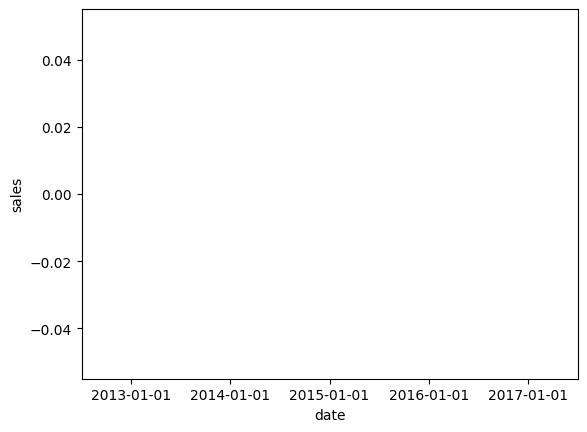

In [ ]:
sns.barplot(data=df_holiday, x=df_holiday[df_holiday['sales'] ==0]['date'], y=df_holiday[df_holiday['sales'] ==0]['sales'])

In [ ]:
df_store_beauty_imp_fwd = df_store_beauty.ffill()
df_store_beauty_imp_fwd

In [ ]:
missing_mask_beauty = df_store_beauty['dcoilwtico'].isna()

plt.figure(figsize=(80, 80))
plt.plot(df_store_beauty.index, df_store_beauty['dcoilwtico'], linestyle='-', color='blue', label='Original Data', lw=2)
plt.plot(df_store_beauty.index[missing_mask_beauty], df_store_beauty_imp_fwd.loc[missing_mask_beauty, 'dcoilwtico'], linestyle='-', color='yellow', label='Imputed Data', lw=5)

missing_indices_beauty = df_store_beauty_imp_fwd.isna()
plt.scatter(df_store_beauty.index[missing_mask_beauty], df_store_beauty.loc[missing_mask_beauty, 'dcoilwtico'], color='red', label='Missing Data', zorder=5)
plt.xlabel('Date')
plt.ylabel('Dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()
print(f"Jumlah missing value: {missing_indices_beauty['dcoilwtico'].sum()}")

In [ ]:
df_store_beauty_imp_fwd = df_store_beauty_imp_fwd.bfill()
print(f"Jumlah missing value: {df_store_beauty_imp_fwd['dcoilwtico'].isna().sum()}")
try:
  df_store_beauty_imp_fwd.drop(columns=['family'], inplace=True)
except KeyError:
  pass

df_store_beauty_imp_fwd

In [ ]:
df_store_beauty_imp_fwd = df_store_beauty_imp_fwd.set_index('date')

In [ ]:
for var in df_store_beauty_imp_fwd.columns:
  df_store_beauty_imp_fwd[var] = df_store_beauty_imp_fwd[var].diff().dropna()

In [ ]:
df_store_beauty_imp_fwd = df_store_beauty_imp_fwd.dropna()

In [ ]:
df_store_beauty_imp_fwd_addcol = df_store_beauty_imp_fwd.copy()
new_data = pd.DataFrame()
new_data['day_of_week'] = df_store_beauty.drop(df_store_beauty.index[0])['date'].dt.day_name()
new_data['date'] = df_store_beauty.drop(df_store_beauty.index[0])['date']

In [ ]:
new_data = new_data.set_index('date')

In [ ]:
df_dummies = pd.get_dummies(new_data['day_of_week'])

df_store_beauty_imp_fwd_addcol = pd.concat([df_store_beauty_imp_fwd_addcol, df_dummies], axis=1)
df_store_beauty_imp_fwd_addcol

In [ ]:
days = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
for day in days:
  df_store_beauty_imp_fwd_addcol[day] = df_store_beauty_imp_fwd_addcol[day].astype(int)
df_store_beauty_imp_fwd_addcol

In [ ]:
endog_vars_beauty_fwd = df_store_beauty_imp_fwd[['sales', 'onpromotion']].diff().dropna()  # Endogenous variables
exog_vars_beauty_fwd = df_store_beauty_imp_fwd['dcoilwtico'].diff().dropna()  # Exogenous variable

train_size_beauty_fwd = int(0.8 * len(df_store_beauty_imp_fwd))
endog_train_beauty_fwd, endog_test_beauty_fwd = endog_vars_beauty_fwd.iloc[:train_size_beauty_fwd], endog_vars_beauty_fwd.iloc[train_size_beauty_fwd:]
exog_train_beauty_fwd, exog_test_beauty_fwd = exog_vars_beauty_fwd.iloc[:train_size_beauty_fwd], exog_vars_beauty_fwd.iloc[train_size_beauty_fwd:]

In [ ]:
endog_vars_automotive_fwd = df_store_automotive_imp_fwd_addcol[['sales', 'onpromotion', 'Friday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Sunday', 'Thursday']]  # Endogenous variables
exog_vars_automotive_fwd = df_store_automotive_imp_fwd_addcol['dcoilwtico']# Exogenous variable

train_size_automotive_fwd = int(0.8 * len(df_store_automotive_imp_fwd_addcol))
endog_train_automotive_fwd, endog_test_automotive_fwd = endog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], endog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]
exog_train_automotive_fwd, exog_test_automotive_fwd = exog_vars_automotive_fwd.iloc[:train_size_automotive_fwd], exog_vars_automotive_fwd.iloc[train_size_automotive_fwd:]

In [ ]:
AIC_beau_fwd = []
BIC_beau_fwd = []
for p in range(3):
  for q in range(3):
    model_beau_fwd = VARMAX(endog_train_beauty_fwd, exog=exog_train_beauty_fwd, order=(p+1, q+1))
    results_beau_fwd = model_beau_fwd.fit(disp=False)
    AIC_beau_fwd.append(results_beau_fwd.aic)
    BIC_beau_fwd.append(results_beau_fwd.bic)

In [ ]:
result_beauty_fwd = pd.DataFrame(AIC_beau_fwd, columns=['AIC'])
result_beauty_fwd['BIC'] = pd.DataFrame(BIC_beau_fwd)
result_beauty_fwd

In [ ]:
model_final = VARMAX(endog_train_beauty_fwd, exog=exog_train_beauty_fwd, order=(2, 1), seasonal_order=(2, 1))
fitted_model_final = model_final.fit(disp=False)
forecast_beau_fwd = fitted_model_final.forecast(steps=len(exog_test_beauty_fwd), exog=exog_test_beauty_fwd)
print(forecast_beau_fwd)
print(fitted_model_final.summary())

In [ ]:
# Prediction
forecast_beau_fwd = fitted_model_final.predict(start=len(exog_train_beauty_fwd), end=len(exog_train_beauty_fwd)+len(exog_test_beauty_fwd)-1, exog=exog_test_beauty_fwd, typ='levels')
forecast_beau_fwd.index = exog_test_beauty_fwd.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_beauty_fwd, label='Train')
plt.plot(exog_test_beauty_fwd, label='Actual')
plt.plot(forecast_beau_fwd, label='Forecast', color='r')
plt.legend()

Interpolation

###2.3. GROCERY I

In [ ]:
df_store_grocery1 = df_store_prep[df_store_prep['family'] == 'GROCERY I']
df_store_grocery1

date     family   sales  onpromotion  dcoilwtico
12    2013-01-01  GROCERY I     0.0            0         NaN
45    2013-01-02  GROCERY I  4558.0            0       93.14
78    2013-01-03  GROCERY I  3260.0            0       92.97
111   2013-01-04  GROCERY I  3085.0            0       93.12
144   2013-01-05  GROCERY I  3398.0            0         NaN
...          ...        ...     ...          ...         ...
55419 2017-08-11  GROCERY I  2864.0           35       48.81
55452 2017-08-12  GROCERY I  2476.0           31         NaN
55485 2017-08-13  GROCERY I  3141.0           31         NaN
55518 2017-08-14  GROCERY I  2717.0           32       47.59
55551 2017-08-15  GROCERY I  2696.0           26       47.57

[1684 rows x 5 columns]

In [ ]:
df_store_grocery1.describe()

date        sales  onpromotion   dcoilwtico
count                           1684  1684.000000  1684.000000  1163.000000
mean   2015-04-24 08:27:04.703088128  3125.107873    22.163302    67.925589
min              2013-01-01 00:00:00     0.000000     0.000000    26.190000
25%              2014-02-26 18:00:00  2651.986000     0.000000    46.390000
50%              2015-04-24 12:00:00  2973.500000    10.000000    53.330000
75%              2016-06-19 06:00:00  3477.500000    36.000000    95.790000
max              2017-08-15 00:00:00  7656.000000   178.000000   110.620000
std                              NaN   732.038714    28.432155    25.677366

In [ ]:
df_store_grocery1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1684 entries, 12 to 55551
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1684 non-null   datetime64[ns]
 1   family       1684 non-null   object        
 2   sales        1684 non-null   float64       
 3   onpromotion  1684 non-null   int64         
 4   dcoilwtico   1163 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 78.9+ KB


In [ ]:
#Data di mana missing value berada
df_store_grocery1[df_store_grocery1['dcoilwtico'].isna()]

date     family   sales  onpromotion  dcoilwtico
12    2013-01-01  GROCERY I     0.0            0         NaN
144   2013-01-05  GROCERY I  3398.0            0         NaN
177   2013-01-06  GROCERY I  4643.0            0         NaN
375   2013-01-12  GROCERY I  2938.0            0         NaN
408   2013-01-13  GROCERY I  4064.0            0         NaN
...          ...        ...     ...          ...         ...
55023 2017-07-30  GROCERY I  3780.0           62         NaN
55221 2017-08-05  GROCERY I  3396.0           41         NaN
55254 2017-08-06  GROCERY I  3460.0           37         NaN
55452 2017-08-12  GROCERY I  2476.0           31         NaN
55485 2017-08-13  GROCERY I  3141.0           31         NaN

[521 rows x 5 columns]

In [ ]:
df_store_grocery1.isna().sum()

date             0
family           0
sales            0
onpromotion      0
dcoilwtico     521
dtype: int64

In [ ]:
holiday_list = ['01-01', '05-01', '05-24', '08-10', '10-09', '11-02', '11-03', '12-25']
df_holiday = df_store_grocery1[df_store_grocery1['date'].dt.strftime('%m-%d').isin(holiday_list)]
df_holiday[df_holiday['sales'] == 0]

date     family  sales  onpromotion  dcoilwtico
12    2013-01-01  GROCERY I    0.0            0         NaN
12024 2014-01-01  GROCERY I    0.0            0         NaN
24036 2015-01-01  GROCERY I    0.0            0         NaN
36048 2016-01-01  GROCERY I    0.0            0         NaN
48093 2017-01-01  GROCERY I    0.0            0         NaN

####Forward Fill

In [ ]:
df_store_grocery1_imp_fwd = df_store_grocery1.ffill()
df_store_grocery1_imp_fwd

date     family   sales  onpromotion  dcoilwtico
12    2013-01-01  GROCERY I     0.0            0         NaN
45    2013-01-02  GROCERY I  4558.0            0       93.14
78    2013-01-03  GROCERY I  3260.0            0       92.97
111   2013-01-04  GROCERY I  3085.0            0       93.12
144   2013-01-05  GROCERY I  3398.0            0       93.12
...          ...        ...     ...          ...         ...
55419 2017-08-11  GROCERY I  2864.0           35       48.81
55452 2017-08-12  GROCERY I  2476.0           31       48.81
55485 2017-08-13  GROCERY I  3141.0           31       48.81
55518 2017-08-14  GROCERY I  2717.0           32       47.59
55551 2017-08-15  GROCERY I  2696.0           26       47.57

[1684 rows x 5 columns]

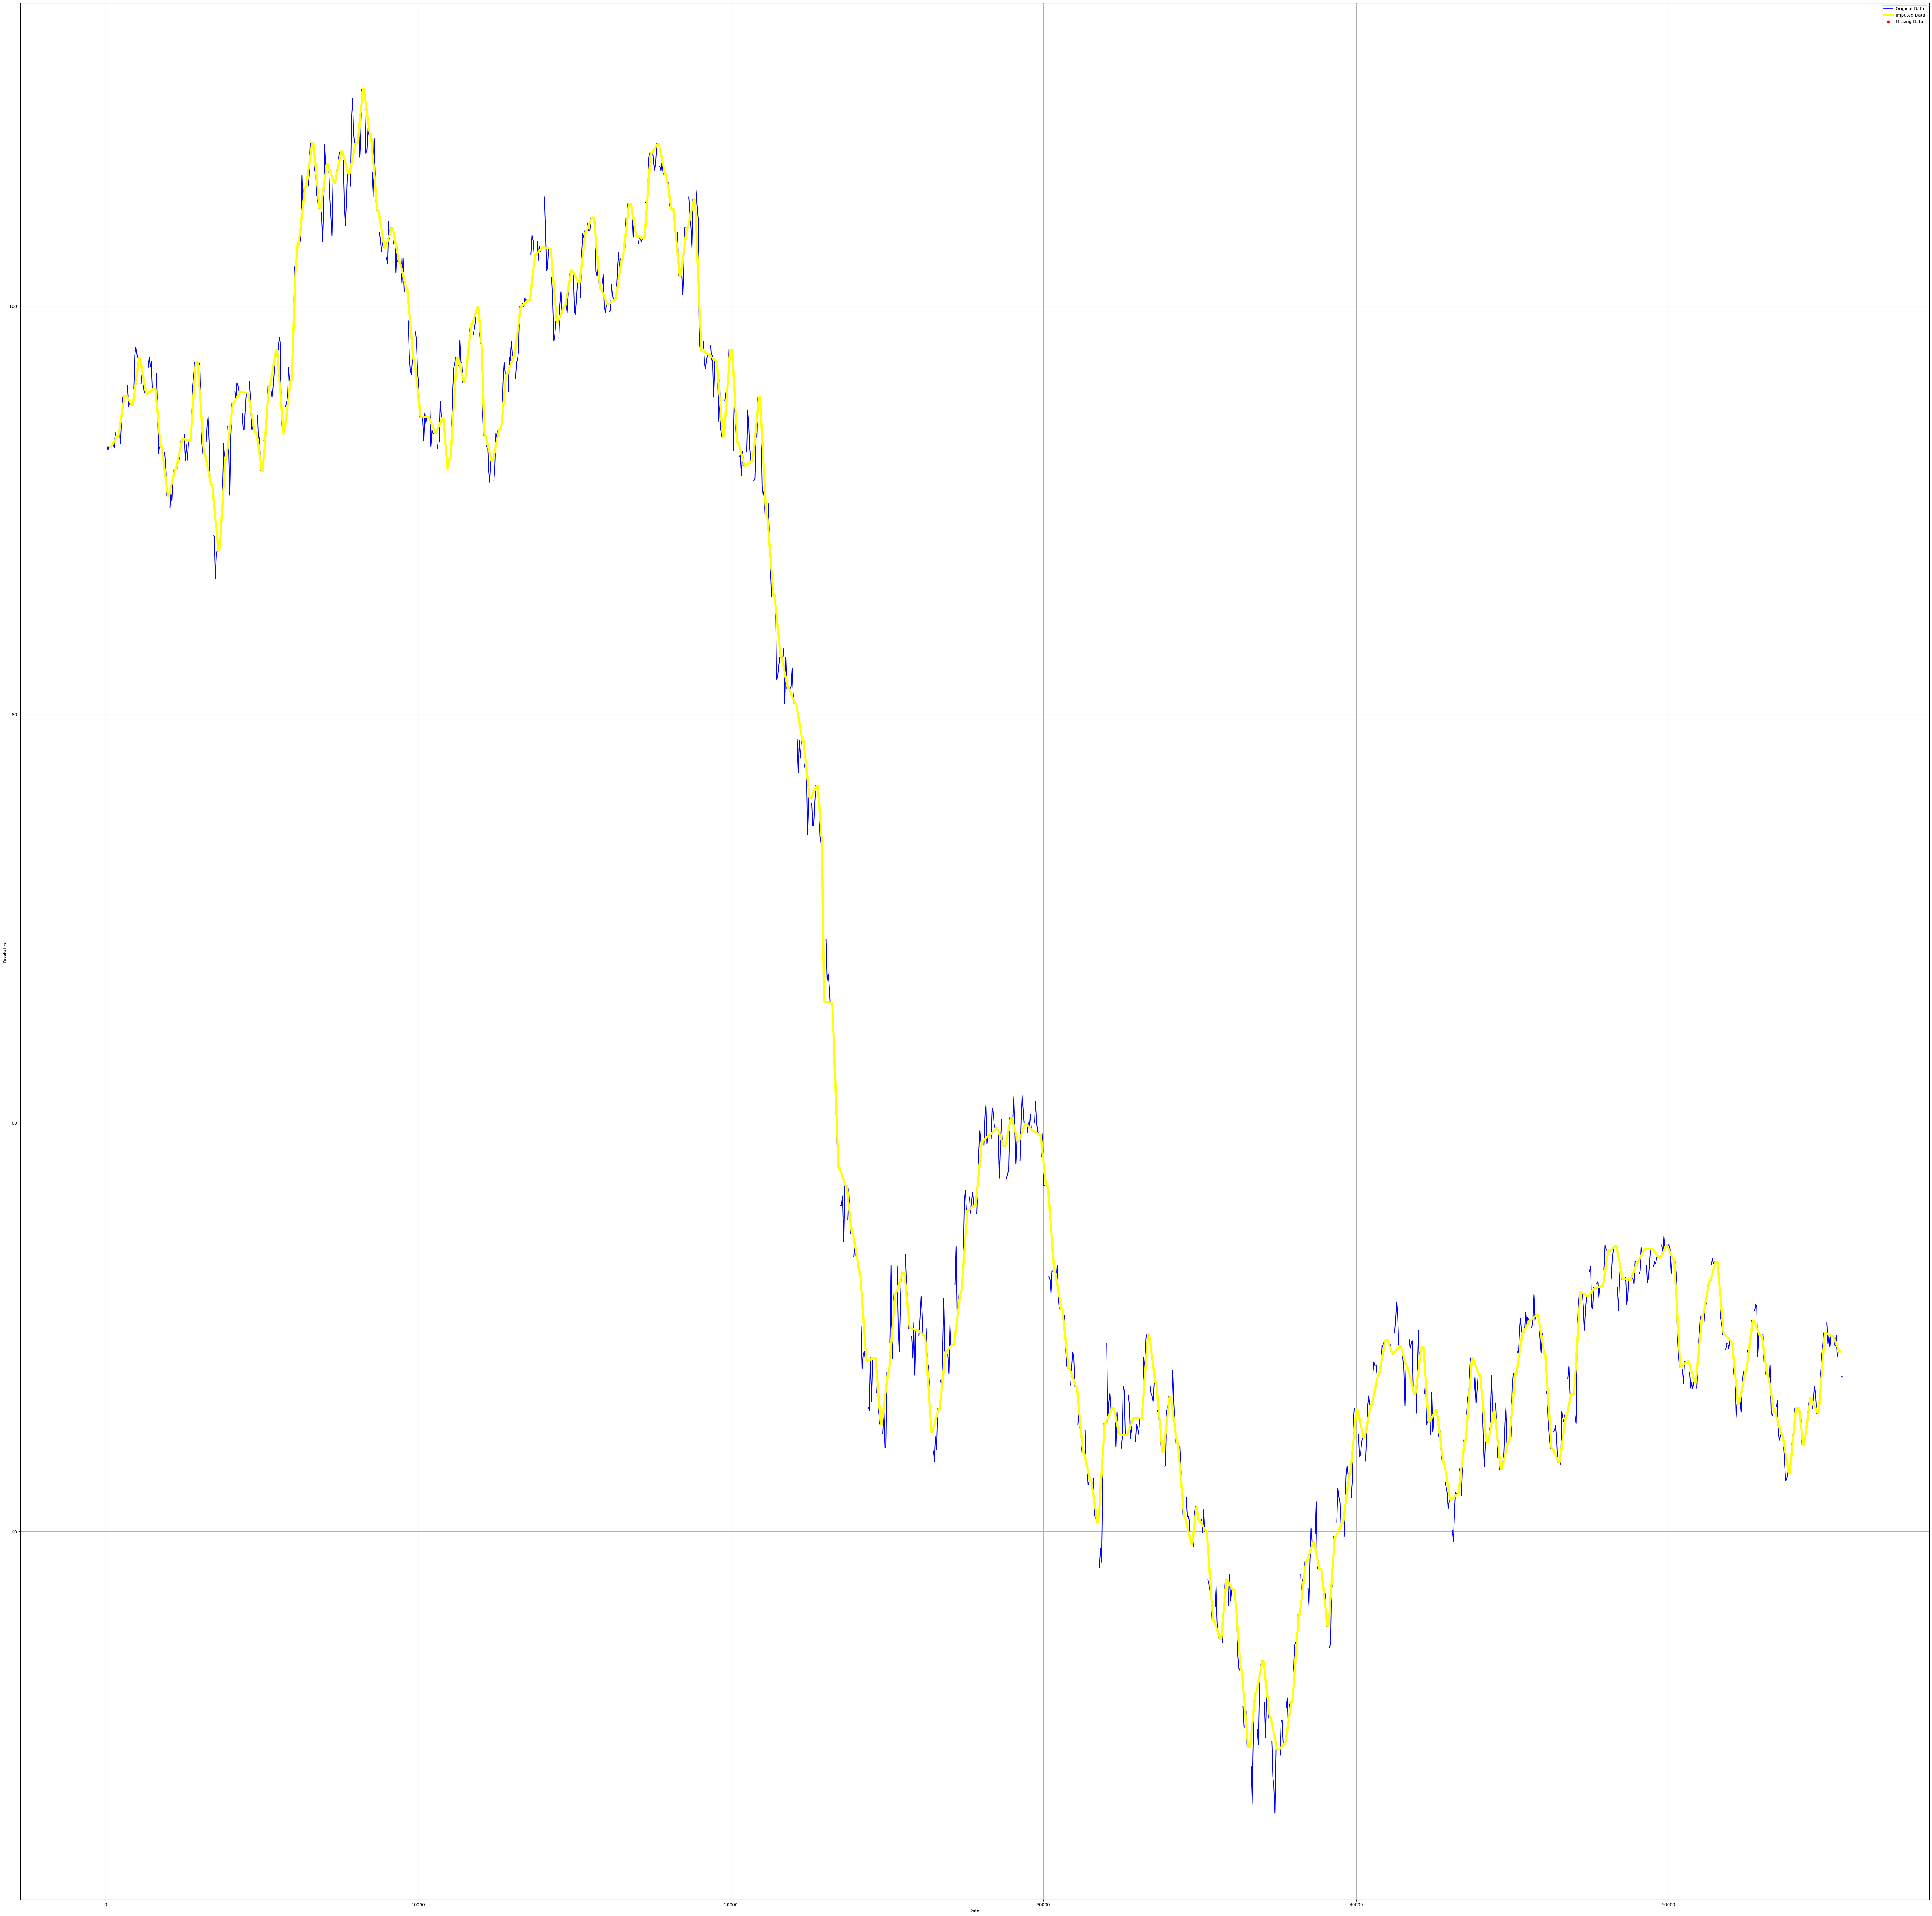

Jumlah missing value: 1


In [ ]:
missing_mask_grocery1 = df_store_grocery1['dcoilwtico'].isna()

plt.figure(figsize=(80, 80))
plt.plot(df_store_grocery1.index, df_store_grocery1['dcoilwtico'], linestyle='-', color='blue', label='Original Data', lw=2)
plt.plot(df_store_grocery1.index[missing_mask_grocery1], df_store_grocery1_imp_fwd.loc[missing_mask_grocery1, 'dcoilwtico'], linestyle='-', color='yellow', label='Imputed Data', lw=5)

missing_indices_grocery1 = df_store_grocery1_imp_fwd.isna()
plt.scatter(df_store_grocery1.index[missing_mask_grocery1], df_store_grocery1.loc[missing_mask_grocery1, 'dcoilwtico'], color='red', label='Missing Data', zorder=5)
plt.xlabel('Date')
plt.ylabel('Dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()
print(f"Jumlah missing value: {missing_indices_grocery1['dcoilwtico'].sum()}")

In [ ]:
df_store_grocery1_imp_fwd = df_store_grocery1_imp_fwd.bfill()
print(f"Jumlah missing value: {df_store_grocery1_imp_fwd['dcoilwtico'].isna().sum()}")
try:
  df_store_grocery1_imp_fwd.drop(columns=['family'], inplace=True)
except KeyError:
  pass

df_store_grocery1_imp_fwd

Jumlah missing value: 0


date   sales  onpromotion  dcoilwtico
12    2013-01-01     0.0            0       93.14
45    2013-01-02  4558.0            0       93.14
78    2013-01-03  3260.0            0       92.97
111   2013-01-04  3085.0            0       93.12
144   2013-01-05  3398.0            0       93.12
...          ...     ...          ...         ...
55419 2017-08-11  2864.0           35       48.81
55452 2017-08-12  2476.0           31       48.81
55485 2017-08-13  3141.0           31       48.81
55518 2017-08-14  2717.0           32       47.59
55551 2017-08-15  2696.0           26       47.57

[1684 rows x 4 columns]

In [ ]:
df_store_grocery1_imp_fwd = df_store_grocery1_imp_fwd.set_index('date')

In [ ]:
for var in df_store_grocery1_imp_fwd.columns:
  df_store_grocery1_imp_fwd[var] = df_store_grocery1_imp_fwd[var].diff().dropna()

In [ ]:
df_store_grocery1_imp_fwd = df_store_grocery1_imp_fwd.dropna()

In [ ]:
df_store_grocery1_imp_fwd_addcol = df_store_grocery1_imp_fwd.copy()
new_data = pd.DataFrame()
new_data['day_of_week'] = df_store_grocery1.drop(df_store_grocery1.index[0])['date'].dt.day_name()
new_data['date'] = df_store_grocery1.drop(df_store_grocery1.index[0])['date']

In [ ]:
new_data = new_data.set_index('date')

In [ ]:
df_dummies = pd.get_dummies(new_data['day_of_week'])

df_store_grocery1_imp_fwd_addcol = pd.concat([df_store_grocery1_imp_fwd_addcol, df_dummies], axis=1)
df_store_grocery1_imp_fwd_addcol

sales  onpromotion  dcoilwtico  Friday  Monday  Saturday  Sunday  \
date                                                                            
2013-01-02  4558.0          0.0        0.00   False   False     False   False   
2013-01-03 -1298.0          0.0       -0.17   False   False     False   False   
2013-01-04  -175.0          0.0        0.15    True   False     False   False   
2013-01-05   313.0          0.0        0.00   False   False      True   False   
2013-01-06  1245.0          0.0        0.00   False   False     False    True   
...            ...          ...         ...     ...     ...       ...     ...   
2017-08-11   177.0          2.0        0.27    True   False     False   False   
2017-08-12  -388.0         -4.0        0.00   False   False      True   False   
2017-08-13   665.0          0.0        0.00   False   False     False    True   
2017-08-14  -424.0          1.0       -1.22   False    True     False   False   
2017-08-15   -21.0         -6.0       -0.02   False   False     False   False   

            Thursday  Tuesday  Wednesday  
date                                      
2013-01-02     False    False       True  
2013-01-03      True    False      False  
2013-01-04     False    False      False  
2013-01-05     False    False      False  
2013-01-06     False    False      False  
...              ...      ...        ...  
2017-08-11     False    False      False  
2017-08-12     False    False      False  
2017-08-13     False    False      False  
2017-08-14     False    False      False  
2017-08-15     False     True      False  

[1683 rows x 10 columns]

In [ ]:
days = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
for day in days:
  df_store_grocery1_imp_fwd_addcol[day] = df_store_grocery1_imp_fwd_addcol[day].astype(int)
df_store_grocery1_imp_fwd_addcol

sales  onpromotion  dcoilwtico  Friday  Monday  Saturday  Sunday  \
date                                                                            
2013-01-02  4558.0          0.0        0.00       0       0         0       0   
2013-01-03 -1298.0          0.0       -0.17       0       0         0       0   
2013-01-04  -175.0          0.0        0.15       1       0         0       0   
2013-01-05   313.0          0.0        0.00       0       0         1       0   
2013-01-06  1245.0          0.0        0.00       0       0         0       1   
...            ...          ...         ...     ...     ...       ...     ...   
2017-08-11   177.0          2.0        0.27       1       0         0       0   
2017-08-12  -388.0         -4.0        0.00       0       0         1       0   
2017-08-13   665.0          0.0        0.00       0       0         0       1   
2017-08-14  -424.0          1.0       -1.22       0       1         0       0   
2017-08-15   -21.0         -6.0       -0.02       0       0         0       0   

            Thursday  Tuesday  Wednesday  
date                                      
2013-01-02         0        0          1  
2013-01-03         1        0          0  
2013-01-04         0        0          0  
2013-01-05         0        0          0  
2013-01-06         0        0          0  
...              ...      ...        ...  
2017-08-11         0        0          0  
2017-08-12         0        0          0  
2017-08-13         0        0          0  
2017-08-14         0        0          0  
2017-08-15         0        1          0  

[1683 rows x 10 columns]

Variasi 1

In [ ]:
endog_vars_grocery1_fwd = df_store_grocery1_imp_fwd[['sales', 'onpromotion']].diff().dropna()  # Endogenous variables
exog_vars_grocery1_fwd = df_store_grocery1_imp_fwd['dcoilwtico'].diff().dropna()  # Exogenous variable

train_size_grocery1_fwd = int(0.8 * len(df_store_grocery1_imp_fwd))
endog_train_grocery1_fwd, endog_test_grocery1_fwd = endog_vars_grocery1_fwd.iloc[:train_size_grocery1_fwd], endog_vars_grocery1_fwd.iloc[train_size_grocery1_fwd:]
exog_train_grocery1_fwd, exog_test_grocery1_fwd = exog_vars_grocery1_fwd.iloc[:train_size_grocery1_fwd], exog_vars_grocery1_fwd.iloc[train_size_grocery1_fwd:]

In [ ]:
AIC_grocery1_fwd = []
BIC_grocery1_fwd = []
for p in range(2):
  for q in range(2):
    model_grocery1_fwd = VARMAX(endog_train_grocery1_fwd, exog=exog_train_grocery1_fwd, order=(p+1, q+1))
    results_grocery1_fwd = model_grocery1_fwd.fit(disp=False)
    AIC_grocery1_fwd.append(results_grocery1_fwd.aic)
    BIC_grocery1_fwd.append(results_grocery1_fwd.bic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically

In [ ]:
result_grocery1_fwd = pd.DataFrame(AIC_grocery1_fwd, columns=['AIC'])
result_grocery1_fwd['BIC'] = pd.DataFrame(BIC_grocery1_fwd)
result_grocery1_fwd

AIC           BIC
0  30739.563174  30817.636562
1  30906.515426  31005.408383
2  30663.506378  30762.399336
3  30714.370757  30834.083285

In [ ]:
model_final_grocery1_fwd = VARMAX(endog_train_grocery1_fwd, exog=exog_train_grocery1_fwd, order=(2, 1))
fitted_model_final_grocery1_fwd = model_final_grocery1_fwd.fit(disp=False)
forecast_grocery1_fwd = fitted_model_final_grocery1_fwd.forecast(steps=len(exog_test_grocery1_fwd), exog=exog_test_grocery1_fwd)
print(forecast_grocery1_fwd)
print(fitted_model_final_grocery1_fwd.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


           sales  onpromotion
1346  408.283463    10.282568
1347   72.718071    -3.126918
1348  -73.401948     0.807729
1349  -39.321902     0.032823
1350   32.325199     0.134120
...          ...          ...
1677   24.275729     0.609384
1678  -10.311432    -0.168537
1679  -11.052999     0.135521
1680  -27.798114    -0.238191
1681   24.382872     0.504960

[336 rows x 2 columns]
                              Statespace Model Results                              
Dep. Variable:     ['sales', 'onpromotion']   No. Observations:                 1346
Model:                          VARMAX(2,1)   Log Likelihood              -15312.753
                                + intercept   AIC                          30663.506
Date:                      Fri, 04 Oct 2024   BIC                          30762.399
Time:                              05:38:34   HQIC                         30700.547
Sample:                                   0                                         
                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

In [ ]:
# Prediction
forecast_grocery1_fwd = fitted_model_final_grocery1_fwd.predict(start=len(exog_train_grocery1_fwd), end=len(exog_train_grocery1_fwd)+len(exog_test_grocery1_fwd)-1, exog=exog_test_grocery1_fwd, typ='levels')
forecast_grocery1_fwd.index = exog_test_grocery1_fwd.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_grocery1_fwd, label='Train')
plt.plot(exog_test_grocery1_fwd, label='Actual')
plt.plot(forecast_auto_fwd, label='Forecast', color='r')
plt.legend()

Variasi 2

In [ ]:
endog_vars_grocery1_fwd2 = df_store_grocery1_imp_fwd_addcol[['sales', 'onpromotion']]  # Endogenous variables
exog_vars_grocery1_fwd2 = df_store_grocery1_imp_fwd_addcol[['dcoilwtico','Friday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Sunday', 'Thursday']]# Exogenous variable

train_size_grocery1_fwd = int(0.8 * len(df_store_grocery1_imp_fwd_addcol))
endog_train_grocery1_fwd2, endog_test_grocery1_fwd2 = endog_vars_grocery1_fwd2.iloc[:train_size_grocery1_fwd], endog_vars_grocery1_fwd2.iloc[train_size_grocery1_fwd:]
exog_train_grocery1_fwd2, exog_test_grocery1_fwd2 = exog_vars_grocery1_fwd2.iloc[:train_size_grocery1_fwd], exog_vars_grocery1_fwd2.iloc[train_size_grocery1_fwd:]

In [ ]:
AIC_grocery1_fwd2 = []
BIC_grocery1_fwd2 = []
for p in range(3):
  for q in range(3):
    model_grocery1_fwd2 = VARMAX(endog_train_grocery1_fwd2, exog=exog_train_grocery1_fwd2, order=(p+1, q+1))
    results_grocery1_fwd2 = model_grocery1_fwd2.fit(disp=False)
    AIC_grocery1_fwd2.append(results_grocery1_fwd2.aic)
    BIC_grocery1_fwd2.append(results_grocery1_fwd2.bic)

In [ ]:
# Prediction
forecast_grocery1_fwd = fitted_model_final.predict(start=len(exog_train_grocery1_fwd), end=len(exog_train_grocery1_fwd)+len(exog_test_grocery1_fwd)-1, exog=exog_test_grocery1_fwd, typ='levels')
forecast_grocery1_fwd.index = exog_test_grocery1_fwd.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_grocery1_fwd, label='Train')
plt.plot(exog_test_grocery1_fwd, label='Actual')
plt.plot(forecast_grocery1_fwd, label='Forecast', color='r')
plt.legend()

In [ ]:
model_final = VARMAX(endog_train_grocery1_fwd, exog=exog_train_grocery1_fwd, order=(2, 1))
fitted_model_final = model_final.fit(disp=False)
forecast_grocery1_fwd = fitted_model_final.forecast(steps=len(exog_test_grocery1_fwd), exog=exog_test_grocery1_fwd)
print(forecast_grocery1_fwd)
print(fitted_model_final.summary())

####Interpolation

In [ ]:
df_store_grocery1_imp_int = df_store_grocery1.interpolate(method='linear')
df_store_grocery1_imp_int

In [ ]:
missing_mask_grocery1 = df_store_grocery1['dcoilwtico'].isna()

plt.figure(figsize=(80, 80))
plt.plot(df_store_grocery1.index, df_store_grocery1['dcoilwtico'], linestyle='-', color='blue', label='Original Data', lw=2)
plt.plot(df_store_grocery1.index[missing_mask_grocery1], df_store_grocery1_imp_int.loc[missing_mask_grocery1, 'dcoilwtico'], linestyle='-', color='yellow', label='Imputed Data', lw=5)

missing_indices_grocery1 = df_store_grocery1_imp_int.isna()
plt.scatter(df_store_grocery1.index[missing_mask_grocery1], df_store_grocery1.loc[missing_mask_grocery1, 'dcoilwtico'], color='red', label='Missing Data', zorder=5)
plt.xlabel('Date')
plt.ylabel('Dcoilwtico')
plt.legend()
plt.grid(True)
plt.show()
print(f"Jumlah missing value: {missing_indices_grocery1['dcoilwtico'].sum()}")

In [ ]:
#Imputasi diatas dilanjutkan Backward Fill karena masih ada nilai missing value
df_store_grocery1_imp_int = df_store_grocery1_imp_int.bfill()
print(f"Jumlah missing value: {df_store_grocery1_imp_int['dcoilwtico'].isna().sum()}")

try:
  df_store_grocery1_imp_int.drop(columns=['family'], inplace=True)
except KeyError:
  pass

df_store_grocery1_imp_int

#####2.1.1.B. Lineplot

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('')
plt.plot(df_store_grocery1_imp_int['date'], df_store_grocery1_imp_int['sales'])
plt.show()

Melihat Lineplot lebih kecil lagi

In [ ]:
df_filtered = df_store_grocery1_imp_int[(df_store_grocery1_imp_int['date']>='2015-01-01') & (df_store_grocery1_imp_int['date'] <='2015-12-31')]

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('')
plt.plot(df_filtered['date'], df_filtered['sales'])
plt.show()

#####2.1.1.C. Seasonal Decomposition

In [ ]:
#Seasonal Component weekly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_grocery1_imp_int[var], model='add', period=7).plot()

In [ ]:
#Komponen seasonal monthly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_grocery1_imp_int[var], model='add', period=30).plot()

In [ ]:
#Komponen seasonal yearly
features = ['sales','onpromotion']
for var in features:
  plt.rcParams['figure.figsize'] = (30, 15)
  seasonal_decompose(df_store_grocery1_imp_int[var], model='add', period=365).plot()

#####2.1.1.D. Autocorrelation Plot

In [ ]:
# Auto Correlation Plot
features = ['sales', 'onpromotion']
for var in features:
  plt.figure(figsize=(40, 20))
  autocorrelation_plot(df_store_grocery1_imp_int[var])
  plt.title(f'Auto Correlation {var} Plot Sales')
  plt.show()

#####2.1.1.E. ACF Plot

In [ ]:
features = ['sales', 'onpromotion']
for var in features:
  plot_acf(df_store_grocery1_imp_int[var], lags=365)
  plt.show()

In [ ]:
#df_store_automotive_imp_int.reset_index(drop=True)

#####2.1.1.F. Plot ACF PACF

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_store_automotive_imp_int['sales'])
ax[0, 1] = plot_acf(df_store_automotive_imp_int['sales'], ax=ax[0, 1])
ax[0, 2] = plot_pacf(df_store_automotive_imp_int['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_store_automotive_imp_int['sales'].diff().dropna())
ax[1, 1] = plot_acf(df_store_automotive_imp_int['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_pacf(df_store_automotive_imp_int['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_store_automotive_imp_int['onpromotion'])
ax[0, 1] = plot_acf(df_store_automotive_imp_int['onpromotion'], ax=ax[0, 1])
ax[0, 2] = plot_pacf(df_store_automotive_imp_int['onpromotion'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_store_automotive_imp_int['onpromotion'].diff().dropna())
ax[1, 1] = plot_acf(df_store_automotive_imp_int['onpromotion'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_pacf(df_store_automotive_imp_int['onpromotion'].diff().dropna(), ax=ax[1, 2])

plt.show()

#####2.1.1.G. Cek Stationarity Data

In [ ]:
for var in df_store_automotive_imp_int.columns:
  result_automotive = adfuller(df_store_automotive_imp_int[var])
  print(f'ADF Statistic {var}: %f' % result_automotive[0])
  print('p-value: %f' % result_automotive[1])

In [ ]:
df_store_automotive_imp_int.drop(columns=['month', 'day', 'year'], inplace=True)
df_store_automotive_imp_int

In [ ]:
df_store_automotive_imp_int = df_store_automotive_imp_int.set_index('date')

In [ ]:
for var in df_store_automotive_imp_int.columns:
  df_store_automotive_imp_int[var] = df_store_automotive_imp_int[var].diff().dropna()

In [ ]:
df_store_automotive_imp_int = df_store_automotive_imp_int.dropna()

In [ ]:
df_store_automotive_imp_int_addcol = df_store_automotive_imp_int.copy()
new_data = pd.DataFrame()
new_data['day_of_week'] = df_store_automotive.drop(df_store_automotive.index[0])['date'].dt.day_name()
new_data['date'] = df_store_automotive.drop(df_store_automotive.index[0])['date']

In [ ]:
new_data = new_data.set_index('date')

In [ ]:
df_dummies = pd.get_dummies(new_data['day_of_week'])

df_store_automotive_imp_int_addcol = pd.concat([df_store_automotive_imp_int_addcol, df_dummies], axis=1)
df_store_automotive_imp_int_addcol

In [ ]:
days = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
for day in days:
  df_store_automotive_imp_int_addcol[day] = df_store_automotive_imp_int_addcol[day].astype(int)
df_store_automotive_imp_int_addcol

Split Training-Testing

In [ ]:
endog_vars_automotive_int = df_store_automotive_imp_int[['sales', 'onpromotion']].diff().dropna()  # Endogenous variables
exog_vars_automotive_int = df_store_automotive_imp_int['dcoilwtico'].diff().dropna()  # Exogenous variable

train_size_automotive_int = int(0.8 * len(df_store_automotive_imp_int))
endog_train_automotive_int, endog_test_automotive_int = endog_vars_automotive_int.iloc[:train_size_automotive_int], endog_vars_automotive_int.iloc[train_size_automotive_int:]
exog_train_automotive_int, exog_test_automotive_int = exog_vars_automotive_int.iloc[:train_size_automotive_int], exog_vars_automotive_int.iloc[train_size_automotive_int:]

In [ ]:
endog_vars_automotive_int = df_store_automotive_imp_int_addcol[['sales', 'onpromotion', 'Friday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Sunday', 'Thursday']]  # Endogenous variables
exog_vars_automotive_int = df_store_automotive_imp_int_addcol['dcoilwtico']# Exogenous variable

train_size_automotive_int = int(0.8 * len(df_store_automotive_imp_int_addcol))
endog_train_automotive_int, endog_test_automotive_int = endog_vars_automotive_int.iloc[:train_size_automotive_int], endog_vars_automotive_int.iloc[train_size_automotive_int:]
exog_train_automotive_int, exog_test_automotive_int = exog_vars_automotive_int.iloc[:train_size_automotive_int], exog_vars_automotive_int.iloc[train_size_automotive_int:]

In [ ]:
AIC_auto_int = []
BIC_auto_int = []
for p in range(3):
  for q in range(3):
    model_auto_int = VARMAX(endog_train_automotive_int, exog=exog_train_automotive_int, order=(p+1, q+1))
    results_auto_int = model_auto_int.fit(disp=False)
    AIC_auto_int.append(results_auto_int.aic)
    BIC_auto_int.append(results_auto_int.bic)

In [ ]:
result_automotive_int = pd.DataFrame(AIC_auto_int, columns=['AIC'])
result_automotive_int['BIC'] = pd.DataFrame(BIC_auto_int)
result_automotive_int

In [ ]:
model_final = VARMAX(endog_train_automotive_int, exog=exog_train_automotive_int, order=(2, 1), seasonal_order=(2, 1))
fitted_model_final = model_final.fit(disp=False)
forecast_auto_int = fitted_model_final.forecast(steps=len(exog_test_automotive_int), exog=exog_test_automotive_int)
print(forecast_auto_int)
print(fitted_model_final.summary())

In [ ]:
# Prediction
forecast_auto_int = fitted_model_final.predict(start=len(exog_train_automotive_int), end=len(exog_train_automotive_int)+len(exog_test_automotive_int)-1, exog=exog_test_automotive_int, typ='levels')
forecast_auto_int.index = exog_test_automotive_int.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(exog_train_automotive_int, label='Train')
plt.plot(exog_test_automotive_int, label='Actual')
plt.plot(forecast_auto_int, label='Forecast', color='r')
plt.legend()

# Import Data
!pip install bayesian-optimization
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
## Exploratory Data Analysis
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Indonesia AI/store5.csv')
df.head()
df['family'].value_counts()
df.isna().sum()
#
df.set_index("date", inplace = True)
df.index = pd.to_datetime(df.index)
df.head()
# Pemisahan data df_automotive, df_grocery1, dan df_beauty
df_automotive = df[df.family == 'AUTOMOTIVE']
df_automotive.head()
df_automotive.shape
df_grocery1 = df[df.family == 'GROCERY I']
df_grocery1.head()
df_beauty = df[df.family == 'BEAUTY']
df_beauty.head()
# LSTM for df_automotive
## Fill Blank Data
df_grocery1 = df_grocery1.fillna(method='ffill')
df_grocery1 = df_grocery1.fillna(method='bfill')
df_grocery1.isna().sum()
## VISUAL
plt.figure(figsize=(25, 10))
sns.lineplot(data=df_automotive, x='date', y='dcoilwtico', palette='tab10', lw=1)
plt.show()
plt.figure(figsize=(25, 10))
sns.lineplot(data=df_grocery1, x='date', y='sales', palette='tab11', lw=1)
plt.show()
plt.figure(figsize=(25, 10))
sns.lineplot(data=df_grocery1, x='date', y='onpromotion', palette='tab11', lw=1)
plt.show()
plt.rcParams['figure.figsize'] = (20, 10)
plot_decompose = seasonal_decompose(df_automotive['sales'][len(df_grocery1)-243:], model='add', period = 7)
plot_decompose.plot()
## training testing
# Split data
# Scalling

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
#x = df_automotive['dcoilwtico'].copy()
#y = df_automotive[['sales','onpromotion']].copy()

#x['dcoilwtico'] = x_scaler.fit_transform(x)
#y = y_scaler.fit_transform(y.values.reshape(-1, 1))
x = df_grocery1[['dcoilwtico','sales', 'onpromotion']].copy()  # Exogenous variable
y = df_grocery1[['sales', 'onpromotion']].copy()  # Endogenous variables
x_scaled = x_scaler.fit_transform(x)  # No need to reshape, since x is now 2D
y_scaled = y_scaler.fit_transform(y)
def create_sequences(X, Y, time_steps):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        Y_seq.append(Y[i + time_steps])
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Contoh jumlah time steps
X_seq, Y_seq = create_sequences(x_scaled, y_scaled, time_steps)
print(X_seq.shape)
print(Y_seq.shape)
test_size = 300

X_train = X_seq[:-test_size]
y_train = Y_seq[:-test_size]
X_test = X_seq[-test_size:]
y_test = Y_seq[-test_size:]

# Check the shapes of the splits
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
## SINGLE LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define your model training function
def lstm_model_optimizer(units, dropout, num_layers, learning_rate, batch_size, epochs):
    model = Sequential()

    # Explicitly define input layer
    model.add(Input(shape=(time_steps, 3)))

    # First LSTM layer
    model.add(LSTM(int(units)))
    model.add(Dropout(dropout))

    # Additional dense layers
    for _ in range(int(num_layers)):
        model.add(Dense(int(units), activation='tanh'))

    # Output layer
    model.add(Dense(2, activation='tanh'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=int(epochs),
                        batch_size=int(batch_size),
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)

    # Get the validation loss
    val_loss = np.min(history.history['val_loss'])

    return -val_loss  # Return the negative val_loss as we are minimizing
# Define bounds of the hyperparameters
pbounds = {
    'units': (32, 256),             # Number of LSTM units
    'dropout': (0.0, 0.5),          # Dropout rate
    'num_layers': (1, 3),           # Number of dense layers
    'learning_rate': (1e-4, 1e-2),  # Learning rate
    'batch_size': (8, 64),          # Batch size
    'epochs': (10, 100)             # Number of epochs
}

# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(
    f=lstm_model_optimizer,
    pbounds=pbounds,
    random_state=42,
    verbose=2  # For detailed output
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=10)

# Print the best result
print(optimizer.max)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Buat model LSTM
model = Sequential()

# Tambahkan layer LSTM
model.add(LSTM(114, input_shape=(time_steps, 3)))
#model.add(BatchNormalization())
model.add(Dropout(0.5))

#model.add(LSTM(units=114))
#model.add(Dropout(0.5))
# The output layer
#model.add(Dense(units=114, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=114, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=2, kernel_initializer='uniform', activation='tanh'))

# Compile model
model.compile(optimizer='adam', loss='mse')

# Latih model
#history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Latih model dengan early stopping dan checkpoint
history1 = model.fit(X_train, y_train, epochs=65, batch_size=32, validation_data=(X_test, y_test),
          callbacks=early_stopping)
# Prediksi
Y_pred_scaled = model.predict(X_test)

# Inverse transform hasil prediksi dan data target
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)
Y_true = y_scaler.inverse_transform(y_test)

%matplotlib inline
losses = pd.DataFrame(history1.history)
losses.plot()
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Menghitung MSE, RMSE, dan MAE untuk Y1 dan Y2
mse_Y1 = mean_squared_error(Y_true[:, 0], Y_pred[:, 0])
mse_Y2 = mean_squared_error(Y_true[:, 1], Y_pred[:, 1])

rmse_Y1 = np.sqrt(mse_Y1)
rmse_Y2 = np.sqrt(mse_Y2)

mae_Y1 = mean_absolute_error(Y_true[:, 0], Y_pred[:, 0])
mae_Y2 = mean_absolute_error(Y_true[:, 1], Y_pred[:, 1])

# Menampilkan hasil
print(f'MSE Y1: {mse_Y1}')
print(f'RMSE Y1: {rmse_Y1}')
print(f'MAE Y1: {mae_Y1}\n')

print(f'MSE Y2: {mse_Y2}')
print(f'RMSE Y2: {rmse_Y2}')
print(f'MAE Y2: {mae_Y2}')

import seaborn as sns
import matplotlib.pyplot as plt

# Plot hasil prediksi vs nilai asli untuk Y1 dan Y2
plt.figure(figsize=(14, 7))

# Visualisasi untuk Y1
plt.subplot(2, 1, 1)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 0], label='True Y1', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 0], label='Predicted Y1', color='red')
plt.title('True vs Predicted Y1')
plt.legend()

# Visualisasi untuk Y2
plt.subplot(2, 1, 2)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 1], label='True Y2', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 1], label='Predicted Y2', color='red')
plt.title('True vs Predicted Y2')
plt.legend()

plt.tight_layout()
plt.show()


## STACKED LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define your model training function
def lstm_model_optimizer(units, dropout, num_layers, learning_rate, batch_size, epochs):
    model2 = Sequential()

    # Explicitly define input layer
    model2.add(Input(shape=(time_steps, 3)))

    # First LSTM layer
    model2.add(LSTM(int(units)))
    model2.add(Dropout(dropout))

    # Additional dense layers
    for _ in range(int(num_layers)):
        model2.add(Dense(int(units), activation='tanh'))

    # Output layer
    model2.add(Dense(2, activation='tanh'))

    # Compile model
    model2.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history2 = model.fit(X_train, y_train,
                        epochs=int(epochs),
                        batch_size=int(batch_size),
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)

    # Get the validation loss
    val_loss = np.min(history2.history['val_loss'])

    return -val_loss  # Return the negative val_loss as we are minimizing
# Define bounds of the hyperparameters
pbounds = {
    'units': (32, 256),             # Number of LSTM units
    'dropout': (0.0, 0.5),          # Dropout rate
    'num_layers': (1, 3),           # Number of dense layers
    'learning_rate': (1e-4, 1e-2),  # Learning rate
    'batch_size': (8, 64),          # Batch size
    'epochs': (10, 100)             # Number of epochs
}

# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(
    f=lstm_model_optimizer,
    pbounds=pbounds,
    random_state=42,
    verbose=2  # For detailed output
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=10)

# Print the best result
print(optimizer.max)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Buat model LSTM
model2 = Sequential()

# Tambahkan layer LSTM
model2.add(LSTM(58, input_shape=(time_steps, 3),return_sequences=True))
#model.add(BatchNormalization())
model2.add(Dropout(0.28))

model2.add(LSTM(units=58))
model2.add(Dropout(0.28))
# The output layer
#model.add(Dense(units=114, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=58, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=2, kernel_initializer='uniform', activation='tanh'))

# Compile model
model2.compile(optimizer='adam', loss='mse')

# Latih model
#history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Latih model dengan early stopping dan checkpoint
history2 = model2.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_test, y_test),
          callbacks=early_stopping)
# Prediksi
Y_pred_scaled = model2.predict(X_test)

# Inverse transform hasil prediksi dan data target
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)
Y_true = y_scaler.inverse_transform(y_test)

%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Menghitung MSE, RMSE, dan MAE untuk Y1 dan Y2
mse_Y1 = mean_squared_error(Y_true[:, 0], Y_pred[:, 0])
mse_Y2 = mean_squared_error(Y_true[:, 1], Y_pred[:, 1])

rmse_Y1 = np.sqrt(mse_Y1)
rmse_Y2 = np.sqrt(mse_Y2)

mae_Y1 = mean_absolute_error(Y_true[:, 0], Y_pred[:, 0])
mae_Y2 = mean_absolute_error(Y_true[:, 1], Y_pred[:, 1])

# Menampilkan hasil
print(f'MSE Y1: {mse_Y1}')
print(f'RMSE Y1: {rmse_Y1}')
print(f'MAE Y1: {mae_Y1}\n')

print(f'MSE Y2: {mse_Y2}')
print(f'RMSE Y2: {rmse_Y2}')
print(f'MAE Y2: {mae_Y2}')

import seaborn as sns
import matplotlib.pyplot as plt

# Plot hasil prediksi vs nilai asli untuk Y1 dan Y2
plt.figure(figsize=(14, 7))

# Visualisasi untuk Y1
plt.subplot(2, 1, 1)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 0], label='True Y1', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 0], label='Predicted Y1', color='red')
plt.title('True vs Predicted Y1')
plt.legend()

# Visualisasi untuk Y2
plt.subplot(2, 1, 2)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 1], label='True Y2', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 1], label='Predicted Y2', color='red')
plt.title('True vs Predicted Y2')
plt.legend()

plt.tight_layout()
plt.show()


## SINGLE LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define your model training function
def lstm_model_optimizer(units, dropout, num_layers, learning_rate, batch_size, epochs):
    model3 = Sequential()

    # Explicitly define input layer
    model3.add(Input(shape=(time_steps, 3)))

    # First LSTM layer
    model3.add(GRU(int(units)))
    model3.add(Dropout(dropout))

    # Additional dense layers
    for _ in range(int(num_layers)):
        model3.add(Dense(int(units), activation='tanh'))

    # Output layer
    model3.add(Dense(2, activation='tanh'))

    # Compile model
    model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model3.fit(X_train, y_train,
                        epochs=int(epochs),
                        batch_size=int(batch_size),
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)

    # Get the validation loss
    val_loss = np.min(history.history['val_loss'])

    return -val_loss  # Return the negative val_loss as we are minimizing
# Define bounds of the hyperparameters
pbounds = {
    'units': (32, 256),             # Number of LSTM units
    'dropout': (0.0, 0.5),          # Dropout rate
    'num_layers': (1, 3),           # Number of dense layers
    'learning_rate': (1e-4, 1e-2),  # Learning rate
    'batch_size': (8, 64),          # Batch size
    'epochs': (10, 100)             # Number of epochs
}

# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(
    f=lstm_model_optimizer,
    pbounds=pbounds,
    random_state=42,
    verbose=2  # For detailed output
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=10)

# Print the best result
print(optimizer.max)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Buat model LSTM
model3 = Sequential()

# Tambahkan layer LSTM
model3.add(GRU(133, input_shape=(time_steps, 3)))
#model.add(BatchNormalization())
model3.add(Dropout(0.3))

#model.add(LSTM(units=114))
#model.add(Dropout(0.5))
# The output layer
#model.add(Dense(units=114, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=114, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=2, kernel_initializer='uniform', activation='tanh'))

# Compile model
model3.compile(optimizer='adam', loss='mse')

# Latih model
#history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Latih model dengan early stopping dan checkpoint
history3 = model3.fit(X_train, y_train, epochs=76, batch_size=13, validation_data=(X_test, y_test),
          callbacks=early_stopping)
# Prediksi
Y_pred_scaled = model3.predict(X_test)

# Inverse transform hasil prediksi dan data target
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)
Y_true = y_scaler.inverse_transform(y_test)

%matplotlib inline
losses = pd.DataFrame(history3.history)
losses.plot()
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Menghitung MSE, RMSE, dan MAE untuk Y1 dan Y2
mse_Y1 = mean_squared_error(Y_true[:, 0], Y_pred[:, 0])
mse_Y2 = mean_squared_error(Y_true[:, 1], Y_pred[:, 1])

rmse_Y1 = np.sqrt(mse_Y1)
rmse_Y2 = np.sqrt(mse_Y2)

mae_Y1 = mean_absolute_error(Y_true[:, 0], Y_pred[:, 0])
mae_Y2 = mean_absolute_error(Y_true[:, 1], Y_pred[:, 1])

# Menampilkan hasil
print(f'MSE Y1: {mse_Y1}')
print(f'RMSE Y1: {rmse_Y1}')
print(f'MAE Y1: {mae_Y1}\n')

print(f'MSE Y2: {mse_Y2}')
print(f'RMSE Y2: {rmse_Y2}')
print(f'MAE Y2: {mae_Y2}')

import seaborn as sns
import matplotlib.pyplot as plt

# Plot hasil prediksi vs nilai asli untuk Y1 dan Y2
plt.figure(figsize=(14, 7))

# Visualisasi untuk Y1
plt.subplot(2, 1, 1)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 0], label='True Y1', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 0], label='Predicted Y1', color='red')
plt.title('True vs Predicted Y1')
plt.legend()

# Visualisasi untuk Y2
plt.subplot(2, 1, 2)
sns.lineplot(x=range(len(Y_true)), y=Y_true[:, 1], label='True Y2', color='blue')
sns.lineplot(x=range(len(Y_pred)), y=Y_pred[:, 1], label='Predicted Y2', color='red')
plt.title('True vs Predicted Y2')
plt.legend()

plt.tight_layout()
plt.show()

